In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
from keras.models import Sequential
from keras.layers import Dense, Activation,Input,InputLayer
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
import tensorflow as tf
from plot_keras_history import show_history, plot_history

In [4]:
df = pd.read_csv('E:\\My files\\Dr Buzna\\trips\\NN\\NN-based_distance\\tripdf_ph_sphs.csv', index_col=0)
print(df.shape)
df.tail()

(15763, 9)


,travel time,real travel time,euc_dist,distance,hour of day,O lat,O lon,D lat,D lon
15758,1649,1662.0,0.129056,24589.872,21,49.309629,18.768167,49.438600,18.772845
15759,1385,1397.0,0.149682,22240.005,1,49.332364,18.877966,49.438794,18.772717
15760,1217,1230.0,0.141945,22198.850,2,49.297270,18.784647,49.438729,18.772910
15761,1189,1202.0,0.142260,22353.817,22,49.296787,18.782995,49.438686,18.772867
15762,1112,1124.0,0.094627,14764.019,6,49.438536,18.772888,49.365483,18.833034


In [5]:
# cyclical feature transformation hour
df['hr_sin'] = np.sin(df['hour of day']*(2.*np.pi/24))
df['hr_cos'] = np.cos(df['hour of day']*(2.*np.pi/24))

In [6]:
# df = pd.merge(df0,df3, on = ['travel time','distance','hour of day'])
df = df.drop(['travel time','distance','O lat','O lon','D lat','D lon','hour of day'],axis=1)
df.rename(columns = {'real travel time':'travel time'}, inplace = True)
df = pd.concat([df.iloc[:,-5:].reset_index(drop=True) , df.iloc[:,0:-5].reset_index(drop=True)] , axis=1)
df.head(2)
df

,travel time,euc_dist,hr_sin,hr_cos
0,1165.0,0.164905,-1.000000,-1.836970e-16
1,436.0,0.003779,-0.707107,7.071068e-01
2,772.0,0.114731,-0.965926,2.588190e-01
3,606.0,0.007145,-0.866025,-5.000000e-01
4,384.0,0.016538,-0.965926,-2.588190e-01
...,...,...,...,...
15758,1662.0,0.129056,-0.707107,7.071068e-01
15759,1397.0,0.149682,0.258819,9.659258e-01
15760,1230.0,0.141945,0.500000,8.660254e-01
15761,1202.0,0.142260,-0.500000,8.660254e-01


In [6]:
# sns.lmplot(x='euc_dist',y='travel time',data=df, height=3, aspect=1.5)

In [7]:
# If you have multiple columns in your dataframe and would like to
# remove all rows that have outliers in at least one column,
# the following expression would do that in one shot.
# from scipy import stats
# df = df[(np.abs(stats.zscore(df['euc_dist'])) < 3)]
# df.shape

# NN-model

In [7]:
def nnmodel(*num_neuron,num_hlayers,Epoch):

    if num_hlayers == 1:
        model = Sequential()
        model.add(InputLayer(input_shape=(X_train.shape[1], )))
        model.add(Dense(num_neuron[0], activation='relu'))
        model.add(Dense(1))
    else:
        model = Sequential()
        model.add(InputLayer(input_shape=(X_train.shape[1], )))
        model.add(Dense(num_neuron[0], activation='relu'))
        model.add(Dense(num_neuron[1], activation='relu'))
        model.add(Dense(1))
    # model.compile(loss='mse', optimizer='adam')
    learning_rate = 0.5
    model.compile(optimizer='adam',
                  loss=tf.keras.metrics.mean_squared_error,
                  metrics=['mape',tf.keras.metrics.RootMeanSquaredError(name='rmse')])
    history = model.fit(X_train, y_train, verbose=1, epochs=Epoch,
                       validation_data=(X_test, y_test))  
    print('minimum testing RMSE: ',min(history.history['val_rmse'])/60)
    print('minimum testing MAPE: ',min(history.history['val_mape'])/100)
    return history

In [8]:
def nnmodel_(*num_neuron,num_hlayers,Epoch):

    if num_hlayers == 1:
        model = Sequential()
        model.add(InputLayer(input_shape=(X_train.shape[1], )))
        model.add(Dense(num_neuron[0], activation='relu'))
        model.add(Dense(1))
    elif num_hlayers == 2:
        model = Sequential()
        model.add(InputLayer(input_shape=(X_train.shape[1], )))
        model.add(Dense(num_neuron[0], activation='relu'))
        model.add(Dense(num_neuron[1], activation='relu'))
        model.add(Dense(1))
    else:
        model = Sequential()
        model.add(InputLayer(input_shape=(X_train.shape[1], )))
        model.add(Dense(num_neuron[0], activation='relu'))
        model.add(Dense(num_neuron[1], activation='relu'))
        model.add(Dense(num_neuron[2], activation='relu'))
        model.add(Dense(1))        
    # model.compile(loss='mse', optimizer='adam')
    learning_rate = 0.5
    model.compile(optimizer='adam',
                  loss=tf.keras.metrics.mean_squared_error,
                  metrics=['mape',tf.keras.metrics.RootMeanSquaredError(name='rmse')])
    X_train0 = tf.convert_to_tensor(X_train,dtype = tf.float32)
    y_train0 = tf.convert_to_tensor(y_train,dtype = tf.float32)
    X_test0 = tf.convert_to_tensor(X_test,dtype = tf.float32)
    y_test0 = tf.convert_to_tensor(y_test,dtype = tf.float32)
    history = model.fit(X_train0, y_train0, verbose=1, epochs=Epoch,
                       validation_data=(X_test0, y_test0))  
    print('minimum testing RMSE: ',min(history.history['val_rmse'])/60)
    print('minimum testing MAPE: ',min(history.history['val_mape'])/100)
    
    return history

In [10]:
def plotme(model):

    # Plot the training and validation accuracy and loss at each epoch
    loss1 = [f/60 for f in model.history['rmse']]
    val_loss1 = [f/60 for f in model.history['val_rmse']]
    loss2 = model.history['mape']
    val_loss2 = model.history['val_mape']
    epochs = range(1, len(model.history['loss'])+1)
    plt.figure(figsize=(5, 3))
    plt.plot(epochs, val_loss1, 'r', label='Validation rmse')
    plt.plot(epochs, loss1, 'y', label='Trainnig rmse')
    plt.plot(epochs, val_loss2, 'k', label='Validation mape')
    plt.plot(epochs, loss2, 'b', label='Trainnig mape')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Metrics')
    #plt.xlim(lims)
    yli = max(model.history['val_mape'])
    plt.ylim([-1, yli+10])
    plt.legend()
    plt.show()

## sub-problem 1:     ******* input:distance *********

In [9]:
x = np.array(df[['euc_dist']])
y = np.array(df['travel time'])
# x

In [10]:
#split data into test & train
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=42)

In [11]:
print(X_train.shape)
print(X_test.shape)
# X_train

(12610, 1)
(3153, 1)


In [12]:
# inputs: distance
model1_1 = nnmodel(5, num_hlayers=1,Epoch=600)
model1_1

Epoch 1/600
395/395 [==============================] - 1s 946us/step - loss: 1426999.5000 - mape: 99.9516 - rmse: 1194.5708 - val_loss: 1423631.3750 - val_mape: 99.8860 - val_rmse: 1193.1603
Epoch 2/600
395/395 [==============================] - 0s 696us/step - loss: 1424221.8750 - mape: 99.7919 - rmse: 1193.4077 - val_loss: 1420002.8750 - val_mape: 99.6717 - val_rmse: 1191.6388
Epoch 3/600
395/395 [==============================] - 0s 689us/step - loss: 1419761.7500 - mape: 99.5326 - rmse: 1191.5376 - val_loss: 1414792.2500 - val_mape: 99.3638 - val_rmse: 1189.4504
Epoch 4/600
395/395 [==============================] - 0s 695us/step - loss: 1413821.2500 - mape: 99.1871 - rmse: 1189.0421 - val_loss: 1408192.8750 - val_mape: 98.9731 - val_rmse: 1186.6730
Epoch 5/600
395/395 [==============================] - 0s 683us/step - loss: 1406556.8750 - mape: 98.7645 - rmse: 1185.9835 - val_loss: 1400363.6250 - val_mape: 98.5082 - val_rmse: 1183.3696
Epoch 6/600
395/395 [========================

395/395 [==============================] - 0s 698us/step - loss: 671509.2500 - mape: 50.5440 - rmse: 819.4567 - val_loss: 662773.2500 - val_mape: 49.7325 - val_rmse: 814.1089
Epoch 45/600
395/395 [==============================] - 0s 688us/step - loss: 649481.3125 - mape: 49.4096 - rmse: 805.9041 - val_loss: 641079.9375 - val_mape: 48.7353 - val_rmse: 800.6747
Epoch 46/600
395/395 [==============================] - 0s 706us/step - loss: 627736.6250 - mape: 48.3757 - rmse: 792.2983 - val_loss: 619628.1250 - val_mape: 47.8346 - val_rmse: 787.1646
Epoch 47/600
395/395 [==============================] - 0s 739us/step - loss: 606340.8750 - mape: 47.4586 - rmse: 778.6790 - val_loss: 598591.1250 - val_mape: 47.0557 - val_rmse: 773.6867
Epoch 48/600
395/395 [==============================] - 0s 702us/step - loss: 585341.1875 - mape: 46.6324 - rmse: 765.0759 - val_loss: 577912.8750 - val_mape: 46.3653 - val_rmse: 760.2058
Epoch 49/600
395/395 [==============================] - 0s 687us/step - l

Epoch 88/600
395/395 [==============================] - 0s 697us/step - loss: 238146.8750 - mape: 57.0455 - rmse: 488.0030 - val_loss: 245698.1094 - val_mape: 58.8437 - val_rmse: 495.6794
Epoch 89/600
395/395 [==============================] - 0s 694us/step - loss: 237585.9688 - mape: 57.0201 - rmse: 487.4279 - val_loss: 245118.5000 - val_mape: 58.7726 - val_rmse: 495.0944
Epoch 90/600
395/395 [==============================] - 0s 689us/step - loss: 237025.1875 - mape: 56.9779 - rmse: 486.8523 - val_loss: 244535.0625 - val_mape: 58.7182 - val_rmse: 494.5049
Epoch 91/600
395/395 [==============================] - 0s 722us/step - loss: 236461.4688 - mape: 56.8944 - rmse: 486.2730 - val_loss: 243950.0000 - val_mape: 58.6799 - val_rmse: 493.9129
Epoch 92/600
395/395 [==============================] - 0s 709us/step - loss: 235899.0938 - mape: 56.8832 - rmse: 485.6945 - val_loss: 243366.9062 - val_mape: 58.6001 - val_rmse: 493.3223
Epoch 93/600
395/395 [==============================] - 0s 6

395/395 [==============================] - 0s 667us/step - loss: 213823.2344 - mape: 53.9485 - rmse: 462.4102 - val_loss: 220318.4219 - val_mape: 55.5866 - val_rmse: 469.3809
Epoch 132/600
395/395 [==============================] - 0s 693us/step - loss: 213268.2188 - mape: 53.8882 - rmse: 461.8097 - val_loss: 219733.5156 - val_mape: 55.4922 - val_rmse: 468.7574
Epoch 133/600
395/395 [==============================] - 0s 730us/step - loss: 212717.0312 - mape: 53.8263 - rmse: 461.2126 - val_loss: 219155.7500 - val_mape: 55.4345 - val_rmse: 468.1407
Epoch 134/600
395/395 [==============================] - 0s 707us/step - loss: 212163.0938 - mape: 53.7345 - rmse: 460.6117 - val_loss: 218565.4062 - val_mape: 55.3042 - val_rmse: 467.5098
Epoch 135/600
395/395 [==============================] - 0s 699us/step - loss: 211608.5312 - mape: 53.6243 - rmse: 460.0093 - val_loss: 217987.5469 - val_mape: 55.2376 - val_rmse: 466.8914
Epoch 136/600
395/395 [==============================] - 0s 694us/ste

395/395 [==============================] - 0s 672us/step - loss: 190365.9688 - mape: 50.1258 - rmse: 436.3095 - val_loss: 195510.3438 - val_mape: 51.5679 - val_rmse: 442.1655
Epoch 175/600
395/395 [==============================] - 0s 697us/step - loss: 189845.2344 - mape: 49.9963 - rmse: 435.7123 - val_loss: 194952.8125 - val_mape: 51.4793 - val_rmse: 441.5346
Epoch 176/600
395/395 [==============================] - 0s 710us/step - loss: 189326.7188 - mape: 49.9571 - rmse: 435.1169 - val_loss: 194401.9531 - val_mape: 51.3893 - val_rmse: 440.9104
Epoch 177/600
395/395 [==============================] - 0s 688us/step - loss: 188812.8125 - mape: 49.8571 - rmse: 434.5260 - val_loss: 193854.9688 - val_mape: 51.2956 - val_rmse: 440.2896
Epoch 178/600
395/395 [==============================] - 0s 685us/step - loss: 188301.3750 - mape: 49.7337 - rmse: 433.9371 - val_loss: 193310.1406 - val_mape: 51.1884 - val_rmse: 439.6705
Epoch 179/600
395/395 [==============================] - 0s 710us/ste

395/395 [==============================] - 0s 687us/step - loss: 170871.2031 - mape: 46.0829 - rmse: 413.3657 - val_loss: 174487.7031 - val_mape: 47.3921 - val_rmse: 417.7173
Epoch 218/600
395/395 [==============================] - 0s 733us/step - loss: 170501.0000 - mape: 46.0008 - rmse: 412.9177 - val_loss: 174081.6250 - val_mape: 47.2953 - val_rmse: 417.2309
Epoch 219/600
395/395 [==============================] - 0s 679us/step - loss: 170137.0312 - mape: 45.8552 - rmse: 412.4767 - val_loss: 173679.4844 - val_mape: 47.1938 - val_rmse: 416.7487
Epoch 220/600
395/395 [==============================] - 0s 746us/step - loss: 169772.3750 - mape: 45.7848 - rmse: 412.0344 - val_loss: 173275.4219 - val_mape: 47.1024 - val_rmse: 416.2636
Epoch 221/600
395/395 [==============================] - 0s 676us/step - loss: 169416.0938 - mape: 45.6909 - rmse: 411.6019 - val_loss: 172890.1094 - val_mape: 47.0402 - val_rmse: 415.8006
Epoch 222/600
395/395 [==============================] - 0s 683us/ste

395/395 [==============================] - 0s 677us/step - loss: 159078.3750 - mape: 42.5304 - rmse: 398.8463 - val_loss: 161221.5781 - val_mape: 43.6460 - val_rmse: 401.5241
Epoch 261/600
395/395 [==============================] - 0s 738us/step - loss: 158903.1875 - mape: 42.4307 - rmse: 398.6266 - val_loss: 161015.3594 - val_mape: 43.5773 - val_rmse: 401.2672
Epoch 262/600
395/395 [==============================] - 0s 696us/step - loss: 158731.5312 - mape: 42.3491 - rmse: 398.4113 - val_loss: 160813.2500 - val_mape: 43.5236 - val_rmse: 401.0153
Epoch 263/600
395/395 [==============================] - 0s 670us/step - loss: 158566.2656 - mape: 42.2846 - rmse: 398.2038 - val_loss: 160614.9844 - val_mape: 43.4326 - val_rmse: 400.7680
Epoch 264/600
395/395 [==============================] - 0s 691us/step - loss: 158407.3125 - mape: 42.2499 - rmse: 398.0042 - val_loss: 160428.9844 - val_mape: 43.3193 - val_rmse: 400.5359
Epoch 265/600
395/395 [==============================] - 0s 728us/ste

395/395 [==============================] - 0s 690us/step - loss: 154594.4531 - mape: 40.1664 - rmse: 393.1850 - val_loss: 155668.7812 - val_mape: 41.1557 - val_rmse: 394.5488
Epoch 304/600
395/395 [==============================] - 0s 679us/step - loss: 154543.9375 - mape: 40.1152 - rmse: 393.1208 - val_loss: 155601.5000 - val_mape: 41.1243 - val_rmse: 394.4636
Epoch 305/600
395/395 [==============================] - 0s 713us/step - loss: 154498.3125 - mape: 40.1001 - rmse: 393.0627 - val_loss: 155537.8594 - val_mape: 41.1085 - val_rmse: 394.3829
Epoch 306/600
395/395 [==============================] - 0s 737us/step - loss: 154455.6250 - mape: 40.0973 - rmse: 393.0084 - val_loss: 155479.5000 - val_mape: 41.0998 - val_rmse: 394.3089
Epoch 307/600
395/395 [==============================] - 0s 698us/step - loss: 154414.1094 - mape: 40.0436 - rmse: 392.9556 - val_loss: 155418.2969 - val_mape: 41.0561 - val_rmse: 394.2313
Epoch 308/600
395/395 [==============================] - 0s 729us/ste

395/395 [==============================] - 0s 692us/step - loss: 153487.1406 - mape: 38.9889 - rmse: 391.7744 - val_loss: 153982.9219 - val_mape: 39.9343 - val_rmse: 392.4066
Epoch 347/600
395/395 [==============================] - 0s 671us/step - loss: 153478.7344 - mape: 39.0370 - rmse: 391.7636 - val_loss: 153963.9688 - val_mape: 39.9203 - val_rmse: 392.3824
Epoch 348/600
395/395 [==============================] - 0s 684us/step - loss: 153468.2188 - mape: 38.9844 - rmse: 391.7502 - val_loss: 153944.6719 - val_mape: 39.8939 - val_rmse: 392.3578
Epoch 349/600
395/395 [==============================] - 0s 677us/step - loss: 153458.5156 - mape: 38.9667 - rmse: 391.7378 - val_loss: 153925.7031 - val_mape: 39.8698 - val_rmse: 392.3336
Epoch 350/600
395/395 [==============================] - 0s 677us/step - loss: 153449.7344 - mape: 38.9411 - rmse: 391.7266 - val_loss: 153908.3750 - val_mape: 39.8293 - val_rmse: 392.3116
Epoch 351/600
395/395 [==============================] - 0s 695us/ste

395/395 [==============================] - 0s 694us/step - loss: 153270.9219 - mape: 38.5098 - rmse: 391.4983 - val_loss: 153494.3125 - val_mape: 39.4047 - val_rmse: 391.7835
Epoch 390/600
395/395 [==============================] - 0s 720us/step - loss: 153268.3125 - mape: 38.4715 - rmse: 391.4950 - val_loss: 153488.2344 - val_mape: 39.3991 - val_rmse: 391.7758
Epoch 391/600
395/395 [==============================] - 0s 722us/step - loss: 153265.0469 - mape: 38.4500 - rmse: 391.4908 - val_loss: 153482.5781 - val_mape: 39.3906 - val_rmse: 391.7685
Epoch 392/600
395/395 [==============================] - 0s 734us/step - loss: 153264.7969 - mape: 38.5008 - rmse: 391.4905 - val_loss: 153477.3906 - val_mape: 39.3859 - val_rmse: 391.7619
Epoch 393/600
395/395 [==============================] - 0s 681us/step - loss: 153262.7344 - mape: 38.4114 - rmse: 391.4879 - val_loss: 153472.5938 - val_mape: 39.3429 - val_rmse: 391.7558
Epoch 394/600
395/395 [==============================] - 0s 660us/ste

395/395 [==============================] - 0s 680us/step - loss: 153229.9219 - mape: 38.2333 - rmse: 391.4459 - val_loss: 153341.3594 - val_mape: 39.1373 - val_rmse: 391.5883
Epoch 433/600
395/395 [==============================] - 0s 709us/step - loss: 153230.5625 - mape: 38.2431 - rmse: 391.4467 - val_loss: 153339.6719 - val_mape: 39.1378 - val_rmse: 391.5861
Epoch 434/600
395/395 [==============================] - 0s 670us/step - loss: 153230.4688 - mape: 38.2374 - rmse: 391.4466 - val_loss: 153338.7500 - val_mape: 39.1139 - val_rmse: 391.5849
Epoch 435/600
395/395 [==============================] - 0s 693us/step - loss: 153230.4531 - mape: 38.2086 - rmse: 391.4466 - val_loss: 153335.5625 - val_mape: 39.1628 - val_rmse: 391.5808
Epoch 436/600
395/395 [==============================] - 0s 692us/step - loss: 153230.4062 - mape: 38.2578 - rmse: 391.4466 - val_loss: 153334.2031 - val_mape: 39.1403 - val_rmse: 391.5791
Epoch 437/600
395/395 [==============================] - 0s 703us/ste

395/395 [==============================] - 0s 668us/step - loss: 153225.1406 - mape: 38.1164 - rmse: 391.4398 - val_loss: 153280.9688 - val_mape: 39.0704 - val_rmse: 391.5111
Epoch 476/600
395/395 [==============================] - 0s 666us/step - loss: 153223.3594 - mape: 38.1477 - rmse: 391.4376 - val_loss: 153279.9531 - val_mape: 39.0797 - val_rmse: 391.5098
Epoch 477/600
395/395 [==============================] - 0s 673us/step - loss: 153224.5000 - mape: 38.1399 - rmse: 391.4390 - val_loss: 153279.0938 - val_mape: 39.0731 - val_rmse: 391.5087
Epoch 478/600
395/395 [==============================] - 0s 696us/step - loss: 153224.3594 - mape: 38.1859 - rmse: 391.4388 - val_loss: 153278.6875 - val_mape: 39.0848 - val_rmse: 391.5082
Epoch 479/600
395/395 [==============================] - 0s 698us/step - loss: 153223.4062 - mape: 38.1753 - rmse: 391.4376 - val_loss: 153277.9844 - val_mape: 39.0837 - val_rmse: 391.5073
Epoch 480/600
395/395 [==============================] - 0s 712us/ste

395/395 [==============================] - 0s 723us/step - loss: 153223.2188 - mape: 38.1375 - rmse: 391.4374 - val_loss: 153259.6250 - val_mape: 39.0134 - val_rmse: 391.4839
Epoch 519/600
395/395 [==============================] - 0s 682us/step - loss: 153224.2500 - mape: 38.1065 - rmse: 391.4387 - val_loss: 153258.7031 - val_mape: 39.0305 - val_rmse: 391.4827
Epoch 520/600
395/395 [==============================] - 0s 674us/step - loss: 153222.1875 - mape: 38.1298 - rmse: 391.4361 - val_loss: 153258.7812 - val_mape: 39.0097 - val_rmse: 391.4828
Epoch 521/600
395/395 [==============================] - 0s 682us/step - loss: 153223.6875 - mape: 38.0743 - rmse: 391.4380 - val_loss: 153257.6875 - val_mape: 39.0029 - val_rmse: 391.4814
Epoch 522/600
395/395 [==============================] - 0s 706us/step - loss: 153222.5781 - mape: 38.0735 - rmse: 391.4366 - val_loss: 153257.6875 - val_mape: 39.0060 - val_rmse: 391.4814
Epoch 523/600
395/395 [==============================] - 0s 706us/ste

395/395 [==============================] - 0s 687us/step - loss: 153222.8594 - mape: 38.1402 - rmse: 391.4369 - val_loss: 153250.2031 - val_mape: 39.0293 - val_rmse: 391.4718
Epoch 562/600
395/395 [==============================] - 0s 663us/step - loss: 153222.9844 - mape: 38.1079 - rmse: 391.4371 - val_loss: 153249.6250 - val_mape: 39.0270 - val_rmse: 391.4711
Epoch 563/600
395/395 [==============================] - 0s 731us/step - loss: 153220.7344 - mape: 38.1090 - rmse: 391.4342 - val_loss: 153249.7656 - val_mape: 39.0185 - val_rmse: 391.4713
Epoch 564/600
395/395 [==============================] - 0s 724us/step - loss: 153222.4062 - mape: 38.1437 - rmse: 391.4363 - val_loss: 153249.3125 - val_mape: 39.0368 - val_rmse: 391.4707
Epoch 565/600
395/395 [==============================] - 0s 668us/step - loss: 153221.5781 - mape: 38.1143 - rmse: 391.4353 - val_loss: 153249.0312 - val_mape: 39.0206 - val_rmse: 391.4703
Epoch 566/600
395/395 [==============================] - 0s 689us/ste

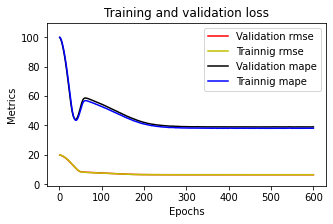

In [15]:
plotme(model1_1)

In [13]:
# inputs: distance
model1_2 = nnmodel(10, num_hlayers=1,Epoch=600)
model1_2

Epoch 1/600
395/395 [==============================] - 0s 842us/step - loss: 1426903.1250 - mape: 99.9458 - rmse: 1194.5305 - val_loss: 1423055.3750 - val_mape: 99.8527 - val_rmse: 1192.9188
Epoch 2/600
395/395 [==============================] - 0s 726us/step - loss: 1422366.3750 - mape: 99.6850 - rmse: 1192.6300 - val_loss: 1416576.7500 - val_mape: 99.4719 - val_rmse: 1190.2003
Epoch 3/600
395/395 [==============================] - 0s 730us/step - loss: 1414213.6250 - mape: 99.2168 - rmse: 1189.2072 - val_loss: 1406925.1250 - val_mape: 98.9021 - val_rmse: 1186.1388
Epoch 4/600
395/395 [==============================] - 0s 710us/step - loss: 1403142.6250 - mape: 98.5716 - rmse: 1184.5432 - val_loss: 1394592.3750 - val_mape: 98.1705 - val_rmse: 1180.9286
Epoch 5/600
395/395 [==============================] - 0s 680us/step - loss: 1389534.7500 - mape: 97.7806 - rmse: 1178.7853 - val_loss: 1379879.2500 - val_mape: 97.2925 - val_rmse: 1174.6826
Epoch 6/600
395/395 [========================

395/395 [==============================] - 0s 691us/step - loss: 331923.5000 - mape: 45.0452 - rmse: 576.1281 - val_loss: 329747.5625 - val_mape: 46.3599 - val_rmse: 574.2365
Epoch 45/600
395/395 [==============================] - 0s 695us/step - loss: 316653.0000 - mape: 45.7152 - rmse: 562.7193 - val_loss: 315482.6562 - val_mape: 47.1720 - val_rmse: 561.6784
Epoch 46/600
395/395 [==============================] - 0s 680us/step - loss: 302991.9375 - mape: 46.5483 - rmse: 550.4470 - val_loss: 302842.3438 - val_mape: 48.0838 - val_rmse: 550.3112
Epoch 47/600
395/395 [==============================] - 0s 711us/step - loss: 290836.8438 - mape: 47.4124 - rmse: 539.2929 - val_loss: 291729.9688 - val_mape: 49.0951 - val_rmse: 540.1203
Epoch 48/600
395/395 [==============================] - 0s 672us/step - loss: 280344.5000 - mape: 48.3809 - rmse: 529.4757 - val_loss: 282237.3750 - val_mape: 50.1600 - val_rmse: 531.2602
Epoch 49/600
395/395 [==============================] - 0s 718us/step - l

Epoch 88/600
395/395 [==============================] - 0s 661us/step - loss: 217047.0469 - mape: 54.3994 - rmse: 465.8831 - val_loss: 223571.5469 - val_mape: 56.0515 - val_rmse: 472.8335
Epoch 89/600
395/395 [==============================] - 0s 717us/step - loss: 216256.9844 - mape: 54.2690 - rmse: 465.0344 - val_loss: 222740.6562 - val_mape: 55.9111 - val_rmse: 471.9541
Epoch 90/600
395/395 [==============================] - 0s 681us/step - loss: 215469.5156 - mape: 54.1780 - rmse: 464.1870 - val_loss: 221917.1719 - val_mape: 55.8127 - val_rmse: 471.0808
Epoch 91/600
395/395 [==============================] - 0s 674us/step - loss: 214677.5156 - mape: 54.0523 - rmse: 463.3330 - val_loss: 221086.8906 - val_mape: 55.6705 - val_rmse: 470.1988
Epoch 92/600
395/395 [==============================] - 0s 684us/step - loss: 213894.9062 - mape: 53.9443 - rmse: 462.4877 - val_loss: 220262.1250 - val_mape: 55.5421 - val_rmse: 469.3209
Epoch 93/600
395/395 [==============================] - 0s 6

395/395 [==============================] - 0s 703us/step - loss: 184660.3281 - mape: 49.1300 - rmse: 429.7212 - val_loss: 189329.8594 - val_mape: 50.5143 - val_rmse: 435.1205
Epoch 132/600
395/395 [==============================] - 0s 704us/step - loss: 184006.9688 - mape: 48.9676 - rmse: 428.9603 - val_loss: 188630.9375 - val_mape: 50.3333 - val_rmse: 434.3166
Epoch 133/600
395/395 [==============================] - 0s 696us/step - loss: 183357.3750 - mape: 48.8376 - rmse: 428.2025 - val_loss: 187918.4062 - val_mape: 50.2018 - val_rmse: 433.4956
Epoch 134/600
395/395 [==============================] - 0s 678us/step - loss: 182694.2656 - mape: 48.6622 - rmse: 427.4275 - val_loss: 187203.3438 - val_mape: 50.0587 - val_rmse: 432.6700
Epoch 135/600
395/395 [==============================] - 0s 640us/step - loss: 182032.2812 - mape: 48.5408 - rmse: 426.6524 - val_loss: 186484.3750 - val_mape: 49.8925 - val_rmse: 431.8384
Epoch 136/600
395/395 [==============================] - 0s 666us/ste

395/395 [==============================] - 0s 742us/step - loss: 162078.8594 - mape: 43.5935 - rmse: 402.5902 - val_loss: 164626.9062 - val_mape: 44.7915 - val_rmse: 405.7424
Epoch 175/600
395/395 [==============================] - 0s 672us/step - loss: 161746.2031 - mape: 43.5243 - rmse: 402.1768 - val_loss: 164251.2031 - val_mape: 44.6715 - val_rmse: 405.2792
Epoch 176/600
395/395 [==============================] - 0s 693us/step - loss: 161426.9062 - mape: 43.3146 - rmse: 401.7797 - val_loss: 163888.5000 - val_mape: 44.5947 - val_rmse: 404.8315
Epoch 177/600
395/395 [==============================] - 0s 676us/step - loss: 161108.9844 - mape: 43.2661 - rmse: 401.3839 - val_loss: 163522.2188 - val_mape: 44.4248 - val_rmse: 404.3788
Epoch 178/600
395/395 [==============================] - 0s 678us/step - loss: 160806.8594 - mape: 43.1648 - rmse: 401.0073 - val_loss: 163181.8750 - val_mape: 44.3362 - val_rmse: 403.9578
Epoch 179/600
395/395 [==============================] - 0s 694us/ste

395/395 [==============================] - 0s 712us/step - loss: 154461.6406 - mape: 40.0916 - rmse: 393.0161 - val_loss: 155474.2344 - val_mape: 41.0982 - val_rmse: 394.3022
Epoch 218/600
395/395 [==============================] - 0s 694us/step - loss: 154401.9844 - mape: 40.0044 - rmse: 392.9402 - val_loss: 155386.0312 - val_mape: 40.9832 - val_rmse: 394.1903
Epoch 219/600
395/395 [==============================] - 0s 710us/step - loss: 154342.1875 - mape: 39.9681 - rmse: 392.8641 - val_loss: 155301.9375 - val_mape: 40.9258 - val_rmse: 394.0837
Epoch 220/600
395/395 [==============================] - 0s 665us/step - loss: 154282.4844 - mape: 39.8689 - rmse: 392.7881 - val_loss: 155219.7656 - val_mape: 40.9098 - val_rmse: 393.9794
Epoch 221/600
395/395 [==============================] - 0s 726us/step - loss: 154229.5625 - mape: 39.8581 - rmse: 392.7207 - val_loss: 155142.4688 - val_mape: 40.8470 - val_rmse: 393.8813
Epoch 222/600
395/395 [==============================] - 0s 705us/ste

395/395 [==============================] - 0s 675us/step - loss: 153341.5781 - mape: 38.6835 - rmse: 391.5885 - val_loss: 153674.6875 - val_mape: 39.6264 - val_rmse: 392.0136
Epoch 261/600
395/395 [==============================] - 0s 681us/step - loss: 153333.2188 - mape: 38.6415 - rmse: 391.5779 - val_loss: 153659.5000 - val_mape: 39.6074 - val_rmse: 391.9943
Epoch 262/600
395/395 [==============================] - 0s 698us/step - loss: 153326.4844 - mape: 38.6908 - rmse: 391.5692 - val_loss: 153644.8438 - val_mape: 39.5574 - val_rmse: 391.9756
Epoch 263/600
395/395 [==============================] - 0s 735us/step - loss: 153321.5938 - mape: 38.6047 - rmse: 391.5630 - val_loss: 153630.3125 - val_mape: 39.5283 - val_rmse: 391.9570
Epoch 264/600
395/395 [==============================] - 0s 709us/step - loss: 153319.1250 - mape: 38.6125 - rmse: 391.5599 - val_loss: 153617.8438 - val_mape: 39.5214 - val_rmse: 391.9411
Epoch 265/600
395/395 [==============================] - 0s 710us/ste

395/395 [==============================] - 0s 675us/step - loss: 153235.5156 - mape: 38.2546 - rmse: 391.4531 - val_loss: 153343.0000 - val_mape: 39.1841 - val_rmse: 391.5903
Epoch 304/600
395/395 [==============================] - 0s 724us/step - loss: 153233.9688 - mape: 38.2781 - rmse: 391.4511 - val_loss: 153339.9375 - val_mape: 39.1661 - val_rmse: 391.5864
Epoch 305/600
395/395 [==============================] - 0s 661us/step - loss: 153231.0625 - mape: 38.2307 - rmse: 391.4474 - val_loss: 153337.4688 - val_mape: 39.1752 - val_rmse: 391.5833
Epoch 306/600
395/395 [==============================] - 0s 694us/step - loss: 153231.3281 - mape: 38.2512 - rmse: 391.4477 - val_loss: 153334.3750 - val_mape: 39.1772 - val_rmse: 391.5793
Epoch 307/600
395/395 [==============================] - 0s 707us/step - loss: 153229.6094 - mape: 38.2138 - rmse: 391.4455 - val_loss: 153331.8594 - val_mape: 39.1532 - val_rmse: 391.5761
Epoch 308/600
395/395 [==============================] - 0s 708us/ste

395/395 [==============================] - 0s 658us/step - loss: 153222.0156 - mape: 38.1264 - rmse: 391.4359 - val_loss: 153270.9688 - val_mape: 39.0341 - val_rmse: 391.4984
Epoch 347/600
395/395 [==============================] - 0s 675us/step - loss: 153223.8281 - mape: 38.0772 - rmse: 391.4381 - val_loss: 153269.8906 - val_mape: 39.0304 - val_rmse: 391.4970
Epoch 348/600
395/395 [==============================] - 0s 693us/step - loss: 153226.3594 - mape: 38.1438 - rmse: 391.4414 - val_loss: 153269.6562 - val_mape: 39.0167 - val_rmse: 391.4967
Epoch 349/600
395/395 [==============================] - 0s 677us/step - loss: 153225.5625 - mape: 38.0825 - rmse: 391.4404 - val_loss: 153270.4844 - val_mape: 39.0263 - val_rmse: 391.4977
Epoch 350/600
395/395 [==============================] - 0s 673us/step - loss: 153224.6875 - mape: 38.0848 - rmse: 391.4392 - val_loss: 153269.5781 - val_mape: 39.0715 - val_rmse: 391.4966
Epoch 351/600
395/395 [==============================] - 0s 675us/ste

395/395 [==============================] - 0s 682us/step - loss: 153223.9219 - mape: 38.1185 - rmse: 391.4383 - val_loss: 153250.3906 - val_mape: 39.0268 - val_rmse: 391.4721
Epoch 390/600
395/395 [==============================] - 0s 701us/step - loss: 153223.8438 - mape: 38.1603 - rmse: 391.4382 - val_loss: 153249.5312 - val_mape: 39.0024 - val_rmse: 391.4710
Epoch 391/600
395/395 [==============================] - 0s 699us/step - loss: 153223.6719 - mape: 38.0859 - rmse: 391.4380 - val_loss: 153249.2188 - val_mape: 39.0330 - val_rmse: 391.4706
Epoch 392/600
395/395 [==============================] - 0s 725us/step - loss: 153222.3750 - mape: 38.1366 - rmse: 391.4363 - val_loss: 153249.2812 - val_mape: 39.0233 - val_rmse: 391.4707
Epoch 393/600
395/395 [==============================] - 0s 703us/step - loss: 153222.7812 - mape: 38.1051 - rmse: 391.4368 - val_loss: 153249.6094 - val_mape: 38.9625 - val_rmse: 391.4711
Epoch 394/600
395/395 [==============================] - 0s 712us/ste

395/395 [==============================] - 0s 718us/step - loss: 153222.5312 - mape: 38.0853 - rmse: 391.4365 - val_loss: 153248.7031 - val_mape: 39.0386 - val_rmse: 391.4699
Epoch 433/600
395/395 [==============================] - 0s 747us/step - loss: 153225.8438 - mape: 38.1844 - rmse: 391.4407 - val_loss: 153247.9375 - val_mape: 39.0096 - val_rmse: 391.4689
Epoch 434/600
395/395 [==============================] - 0s 697us/step - loss: 153225.6875 - mape: 38.0972 - rmse: 391.4405 - val_loss: 153248.0156 - val_mape: 38.9668 - val_rmse: 391.4691
Epoch 435/600
395/395 [==============================] - 0s 705us/step - loss: 153225.1406 - mape: 38.0582 - rmse: 391.4398 - val_loss: 153247.8281 - val_mape: 38.9860 - val_rmse: 391.4688
Epoch 436/600
395/395 [==============================] - 0s 731us/step - loss: 153223.1250 - mape: 38.0880 - rmse: 391.4373 - val_loss: 153246.7344 - val_mape: 38.9991 - val_rmse: 391.4674
Epoch 437/600
395/395 [==============================] - 0s 763us/ste

395/395 [==============================] - 0s 683us/step - loss: 153223.2031 - mape: 38.0905 - rmse: 391.4373 - val_loss: 153242.9688 - val_mape: 39.0279 - val_rmse: 391.4626
Epoch 476/600
395/395 [==============================] - 0s 672us/step - loss: 153221.1406 - mape: 38.1275 - rmse: 391.4347 - val_loss: 153242.8594 - val_mape: 39.0161 - val_rmse: 391.4625
Epoch 477/600
395/395 [==============================] - 0s 705us/step - loss: 153223.9219 - mape: 38.1024 - rmse: 391.4383 - val_loss: 153242.2812 - val_mape: 39.0003 - val_rmse: 391.4617
Epoch 478/600
395/395 [==============================] - 0s 704us/step - loss: 153222.5000 - mape: 38.1572 - rmse: 391.4365 - val_loss: 153241.9375 - val_mape: 38.9764 - val_rmse: 391.4613
Epoch 479/600
395/395 [==============================] - 0s 703us/step - loss: 153224.0938 - mape: 38.1210 - rmse: 391.4385 - val_loss: 153241.5469 - val_mape: 38.9976 - val_rmse: 391.4608
Epoch 480/600
395/395 [==============================] - 0s 753us/ste

395/395 [==============================] - 0s 693us/step - loss: 153224.1562 - mape: 38.1234 - rmse: 391.4386 - val_loss: 153242.4531 - val_mape: 38.9513 - val_rmse: 391.4619
Epoch 519/600
395/395 [==============================] - 0s 731us/step - loss: 153226.3281 - mape: 37.9702 - rmse: 391.4413 - val_loss: 153241.9844 - val_mape: 38.9786 - val_rmse: 391.4613
Epoch 520/600
395/395 [==============================] - 0s 687us/step - loss: 153223.8125 - mape: 38.0592 - rmse: 391.4381 - val_loss: 153241.5781 - val_mape: 39.0020 - val_rmse: 391.4608
Epoch 521/600
395/395 [==============================] - 0s 708us/step - loss: 153223.3438 - mape: 38.0833 - rmse: 391.4375 - val_loss: 153242.2812 - val_mape: 38.9643 - val_rmse: 391.4617
Epoch 522/600
395/395 [==============================] - 0s 693us/step - loss: 153225.3438 - mape: 38.0809 - rmse: 391.4401 - val_loss: 153242.0000 - val_mape: 38.9533 - val_rmse: 391.4614
Epoch 523/600
395/395 [==============================] - 0s 692us/ste

395/395 [==============================] - 0s 693us/step - loss: 153224.0781 - mape: 38.0653 - rmse: 391.4385 - val_loss: 153243.3438 - val_mape: 39.0417 - val_rmse: 391.4631
Epoch 562/600
395/395 [==============================] - 0s 711us/step - loss: 153223.3125 - mape: 38.0441 - rmse: 391.4375 - val_loss: 153242.5625 - val_mape: 39.0134 - val_rmse: 391.4621
Epoch 563/600
395/395 [==============================] - 0s 693us/step - loss: 153224.5625 - mape: 38.1200 - rmse: 391.4391 - val_loss: 153243.8750 - val_mape: 39.0579 - val_rmse: 391.4637
Epoch 564/600
395/395 [==============================] - 0s 720us/step - loss: 153225.2656 - mape: 38.1781 - rmse: 391.4400 - val_loss: 153243.6719 - val_mape: 39.0407 - val_rmse: 391.4635
Epoch 565/600
395/395 [==============================] - 0s 711us/step - loss: 153224.2812 - mape: 38.0577 - rmse: 391.4387 - val_loss: 153242.8906 - val_mape: 38.9862 - val_rmse: 391.4625
Epoch 566/600
395/395 [==============================] - 0s 711us/ste

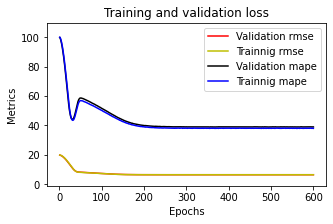

In [17]:
plotme(model1_2)

In [14]:
# inputs: distance
model1_3 = nnmodel(20, num_hlayers=1,Epoch=600)
model1_3

Epoch 1/600
395/395 [==============================] - 1s 922us/step - loss: 1425944.7500 - mape: 99.8932 - rmse: 1194.1293 - val_loss: 1420596.7500 - val_mape: 99.7125 - val_rmse: 1191.8879
Epoch 2/600
395/395 [==============================] - 0s 724us/step - loss: 1416337.3750 - mape: 99.3418 - rmse: 1190.0997 - val_loss: 1406077.8750 - val_mape: 98.8618 - val_rmse: 1185.7815
Epoch 3/600
395/395 [==============================] - 0s 684us/step - loss: 1397594.3750 - mape: 98.2570 - rmse: 1182.1990 - val_loss: 1383607.1250 - val_mape: 97.5303 - val_rmse: 1176.2683
Epoch 4/600
395/395 [==============================] - 0s 702us/step - loss: 1371686.7500 - mape: 96.7470 - rmse: 1171.1903 - val_loss: 1354660.6250 - val_mape: 95.7940 - val_rmse: 1163.8989
Epoch 5/600
395/395 [==============================] - 0s 710us/step - loss: 1339791.2500 - mape: 94.8658 - rmse: 1157.4935 - val_loss: 1320317.6250 - val_mape: 93.7030 - val_rmse: 1149.0508
Epoch 6/600
395/395 [========================

395/395 [==============================] - 0s 693us/step - loss: 230999.8594 - mape: 56.1910 - rmse: 480.6245 - val_loss: 237915.8125 - val_mape: 57.9811 - val_rmse: 487.7661
Epoch 45/600
395/395 [==============================] - 0s 647us/step - loss: 229762.4844 - mape: 56.1181 - rmse: 479.3354 - val_loss: 236626.1250 - val_mape: 57.8242 - val_rmse: 486.4423
Epoch 46/600
395/395 [==============================] - 0s 686us/step - loss: 228520.6406 - mape: 55.9164 - rmse: 478.0383 - val_loss: 235334.7344 - val_mape: 57.7036 - val_rmse: 485.1131
Epoch 47/600
395/395 [==============================] - 0s 683us/step - loss: 227281.0781 - mape: 55.8623 - rmse: 476.7401 - val_loss: 234036.7188 - val_mape: 57.5387 - val_rmse: 483.7734
Epoch 48/600
395/395 [==============================] - 0s 656us/step - loss: 226028.8125 - mape: 55.6993 - rmse: 475.4249 - val_loss: 232727.6406 - val_mape: 57.3337 - val_rmse: 482.4185
Epoch 49/600
395/395 [==============================] - 0s 660us/step - l

Epoch 88/600
395/395 [==============================] - 0s 725us/step - loss: 179052.3750 - mape: 47.8831 - rmse: 423.1458 - val_loss: 183088.6719 - val_mape: 49.3064 - val_rmse: 427.8886
Epoch 89/600
395/395 [==============================] - 0s 692us/step - loss: 178054.9688 - mape: 47.8771 - rmse: 421.9656 - val_loss: 182016.2500 - val_mape: 48.9826 - val_rmse: 426.6336
Epoch 90/600
395/395 [==============================] - 0s 647us/step - loss: 177092.0469 - mape: 47.5600 - rmse: 420.8231 - val_loss: 180970.8438 - val_mape: 48.6634 - val_rmse: 425.4067
Epoch 91/600
395/395 [==============================] - 0s 688us/step - loss: 176141.5156 - mape: 47.1526 - rmse: 419.6922 - val_loss: 179941.2812 - val_mape: 48.4857 - val_rmse: 424.1949
Epoch 92/600
395/395 [==============================] - 0s 677us/step - loss: 175209.8125 - mape: 46.9664 - rmse: 418.5807 - val_loss: 178945.7812 - val_mape: 48.3981 - val_rmse: 423.0198
Epoch 93/600
395/395 [==============================] - 0s 7

395/395 [==============================] - 0s 676us/step - loss: 155286.7812 - mape: 40.5865 - rmse: 394.0645 - val_loss: 156527.5469 - val_mape: 41.6839 - val_rmse: 395.6356
Epoch 132/600
395/395 [==============================] - 0s 682us/step - loss: 155131.2344 - mape: 40.5433 - rmse: 393.8670 - val_loss: 156334.0312 - val_mape: 41.5202 - val_rmse: 395.3910
Epoch 133/600
395/395 [==============================] - 0s 670us/step - loss: 154994.7344 - mape: 40.4573 - rmse: 393.6937 - val_loss: 156147.8750 - val_mape: 41.4216 - val_rmse: 395.1555
Epoch 134/600
395/395 [==============================] - 0s 739us/step - loss: 154860.9219 - mape: 40.3567 - rmse: 393.5237 - val_loss: 155975.2500 - val_mape: 41.3365 - val_rmse: 394.9370
Epoch 135/600
395/395 [==============================] - 0s 664us/step - loss: 154733.4062 - mape: 40.2879 - rmse: 393.3617 - val_loss: 155807.7500 - val_mape: 41.2447 - val_rmse: 394.7249
Epoch 136/600
395/395 [==============================] - 0s 722us/ste

395/395 [==============================] - 0s 685us/step - loss: 153279.3750 - mape: 38.4652 - rmse: 391.5091 - val_loss: 153506.0312 - val_mape: 39.4651 - val_rmse: 391.7985
Epoch 175/600
395/395 [==============================] - 0s 693us/step - loss: 153282.9219 - mape: 38.5117 - rmse: 391.5136 - val_loss: 153491.6250 - val_mape: 39.3685 - val_rmse: 391.7801
Epoch 176/600
395/395 [==============================] - 0s 697us/step - loss: 153272.3594 - mape: 38.4014 - rmse: 391.5002 - val_loss: 153479.6719 - val_mape: 39.3450 - val_rmse: 391.7648
Epoch 177/600
395/395 [==============================] - 0s 646us/step - loss: 153266.6562 - mape: 38.4350 - rmse: 391.4929 - val_loss: 153468.3906 - val_mape: 39.4049 - val_rmse: 391.7504
Epoch 178/600
395/395 [==============================] - 0s 661us/step - loss: 153270.1562 - mape: 38.4540 - rmse: 391.4973 - val_loss: 153455.7656 - val_mape: 39.3741 - val_rmse: 391.7343
Epoch 179/600
395/395 [==============================] - 0s 669us/ste

395/395 [==============================] - 0s 702us/step - loss: 153228.2188 - mape: 38.0956 - rmse: 391.4438 - val_loss: 153274.0000 - val_mape: 39.1142 - val_rmse: 391.5022
Epoch 218/600
395/395 [==============================] - 0s 737us/step - loss: 153232.3438 - mape: 38.1319 - rmse: 391.4490 - val_loss: 153272.0469 - val_mape: 39.0629 - val_rmse: 391.4997
Epoch 219/600
395/395 [==============================] - 0s 685us/step - loss: 153229.0156 - mape: 38.1335 - rmse: 391.4448 - val_loss: 153272.0000 - val_mape: 38.9978 - val_rmse: 391.4997
Epoch 220/600
395/395 [==============================] - 0s 667us/step - loss: 153230.6719 - mape: 38.1026 - rmse: 391.4469 - val_loss: 153270.3906 - val_mape: 39.1036 - val_rmse: 391.4976
Epoch 221/600
395/395 [==============================] - 0s 658us/step - loss: 153225.5469 - mape: 38.1611 - rmse: 391.4403 - val_loss: 153269.4688 - val_mape: 39.0507 - val_rmse: 391.4965
Epoch 222/600
395/395 [==============================] - 0s 720us/ste

395/395 [==============================] - 0s 690us/step - loss: 153230.0156 - mape: 38.1544 - rmse: 391.4460 - val_loss: 153243.5312 - val_mape: 39.0236 - val_rmse: 391.4633
Epoch 261/600
395/395 [==============================] - 0s 698us/step - loss: 153228.0781 - mape: 38.1421 - rmse: 391.4436 - val_loss: 153242.8594 - val_mape: 39.0041 - val_rmse: 391.4625
Epoch 262/600
395/395 [==============================] - 0s 679us/step - loss: 153226.2188 - mape: 38.1131 - rmse: 391.4412 - val_loss: 153243.0000 - val_mape: 38.9490 - val_rmse: 391.4626
Epoch 263/600
395/395 [==============================] - 0s 674us/step - loss: 153228.0312 - mape: 38.0067 - rmse: 391.4435 - val_loss: 153244.5469 - val_mape: 38.9224 - val_rmse: 391.4646
Epoch 264/600
395/395 [==============================] - 0s 710us/step - loss: 153227.7188 - mape: 38.0210 - rmse: 391.4431 - val_loss: 153243.7812 - val_mape: 39.0189 - val_rmse: 391.4637
Epoch 265/600
395/395 [==============================] - 0s 707us/ste

395/395 [==============================] - 0s 677us/step - loss: 153232.2031 - mape: 38.0876 - rmse: 391.4489 - val_loss: 153239.3906 - val_mape: 38.9736 - val_rmse: 391.4580
Epoch 304/600
395/395 [==============================] - 0s 660us/step - loss: 153226.7188 - mape: 38.0741 - rmse: 391.4418 - val_loss: 153239.7344 - val_mape: 38.9832 - val_rmse: 391.4585
Epoch 305/600
395/395 [==============================] - 0s 723us/step - loss: 153230.2812 - mape: 38.0905 - rmse: 391.4464 - val_loss: 153241.2188 - val_mape: 38.9006 - val_rmse: 391.4604
Epoch 306/600
395/395 [==============================] - 0s 674us/step - loss: 153228.0625 - mape: 38.0158 - rmse: 391.4436 - val_loss: 153238.4531 - val_mape: 38.9991 - val_rmse: 391.4568
Epoch 307/600
395/395 [==============================] - 0s 690us/step - loss: 153222.6875 - mape: 37.9726 - rmse: 391.4367 - val_loss: 153238.8594 - val_mape: 39.0187 - val_rmse: 391.4574
Epoch 308/600
395/395 [==============================] - 0s 638us/ste

395/395 [==============================] - 0s 645us/step - loss: 153227.7812 - mape: 38.1222 - rmse: 391.4432 - val_loss: 153236.7500 - val_mape: 39.0010 - val_rmse: 391.4547
Epoch 347/600
395/395 [==============================] - 0s 695us/step - loss: 153224.7656 - mape: 38.0903 - rmse: 391.4394 - val_loss: 153237.9375 - val_mape: 38.9302 - val_rmse: 391.4562
Epoch 348/600
395/395 [==============================] - 0s 664us/step - loss: 153231.6875 - mape: 38.0669 - rmse: 391.4482 - val_loss: 153237.7344 - val_mape: 38.9378 - val_rmse: 391.4559
Epoch 349/600
395/395 [==============================] - 0s 737us/step - loss: 153224.3281 - mape: 38.0882 - rmse: 391.4388 - val_loss: 153237.4844 - val_mape: 38.9271 - val_rmse: 391.4556
Epoch 350/600
395/395 [==============================] - 0s 683us/step - loss: 153230.2656 - mape: 38.0059 - rmse: 391.4464 - val_loss: 153236.8594 - val_mape: 38.9910 - val_rmse: 391.4548
Epoch 351/600
395/395 [==============================] - 0s 668us/ste

395/395 [==============================] - 0s 667us/step - loss: 153229.6406 - mape: 38.0361 - rmse: 391.4456 - val_loss: 153238.4844 - val_mape: 38.9322 - val_rmse: 391.4569
Epoch 390/600
395/395 [==============================] - 0s 725us/step - loss: 153226.3906 - mape: 38.0875 - rmse: 391.4414 - val_loss: 153238.4531 - val_mape: 38.9469 - val_rmse: 391.4568
Epoch 391/600
395/395 [==============================] - 0s 718us/step - loss: 153226.7969 - mape: 38.0241 - rmse: 391.4420 - val_loss: 153237.6406 - val_mape: 38.9808 - val_rmse: 391.4558
Epoch 392/600
395/395 [==============================] - 0s 690us/step - loss: 153224.2656 - mape: 38.1200 - rmse: 391.4387 - val_loss: 153238.3750 - val_mape: 38.9496 - val_rmse: 391.4567
Epoch 393/600
395/395 [==============================] - 0s 668us/step - loss: 153227.0000 - mape: 38.0675 - rmse: 391.4422 - val_loss: 153238.5469 - val_mape: 38.9342 - val_rmse: 391.4569
Epoch 394/600
395/395 [==============================] - 0s 697us/ste

395/395 [==============================] - 0s 714us/step - loss: 153225.3906 - mape: 38.0948 - rmse: 391.4402 - val_loss: 153240.1406 - val_mape: 38.9725 - val_rmse: 391.4590
Epoch 433/600
395/395 [==============================] - 0s 700us/step - loss: 153222.2031 - mape: 37.9701 - rmse: 391.4361 - val_loss: 153240.4844 - val_mape: 39.0476 - val_rmse: 391.4594
Epoch 434/600
395/395 [==============================] - 0s 712us/step - loss: 153227.5000 - mape: 38.1311 - rmse: 391.4428 - val_loss: 153239.5312 - val_mape: 38.9948 - val_rmse: 391.4582
Epoch 435/600
395/395 [==============================] - 0s 734us/step - loss: 153226.0469 - mape: 38.1636 - rmse: 391.4410 - val_loss: 153238.2500 - val_mape: 38.9951 - val_rmse: 391.4566
Epoch 436/600
395/395 [==============================] - 0s 733us/step - loss: 153227.9531 - mape: 38.1410 - rmse: 391.4434 - val_loss: 153240.2500 - val_mape: 39.0013 - val_rmse: 391.4591
Epoch 437/600
395/395 [==============================] - 0s 716us/ste

395/395 [==============================] - 0s 678us/step - loss: 153228.8125 - mape: 38.0659 - rmse: 391.4445 - val_loss: 153242.1250 - val_mape: 38.9692 - val_rmse: 391.4615
Epoch 476/600
395/395 [==============================] - 0s 689us/step - loss: 153225.5469 - mape: 38.0675 - rmse: 391.4403 - val_loss: 153241.0469 - val_mape: 38.9879 - val_rmse: 391.4601
Epoch 477/600
395/395 [==============================] - 0s 680us/step - loss: 153228.1406 - mape: 38.0657 - rmse: 391.4437 - val_loss: 153240.7969 - val_mape: 38.9717 - val_rmse: 391.4598
Epoch 478/600
395/395 [==============================] - 0s 716us/step - loss: 153227.3594 - mape: 38.0959 - rmse: 391.4427 - val_loss: 153241.1875 - val_mape: 39.0118 - val_rmse: 391.4603
Epoch 479/600
395/395 [==============================] - 0s 679us/step - loss: 153229.5938 - mape: 38.2099 - rmse: 391.4455 - val_loss: 153243.0000 - val_mape: 38.9950 - val_rmse: 391.4626
Epoch 480/600
395/395 [==============================] - 0s 699us/ste

395/395 [==============================] - 0s 724us/step - loss: 153230.7969 - mape: 38.2257 - rmse: 391.4471 - val_loss: 153248.1250 - val_mape: 39.0920 - val_rmse: 391.4692
Epoch 519/600
395/395 [==============================] - 0s 731us/step - loss: 153231.9375 - mape: 38.1554 - rmse: 391.4485 - val_loss: 153248.2500 - val_mape: 39.0572 - val_rmse: 391.4694
Epoch 520/600
395/395 [==============================] - 0s 676us/step - loss: 153225.6562 - mape: 38.1764 - rmse: 391.4405 - val_loss: 153249.8906 - val_mape: 39.0722 - val_rmse: 391.4714
Epoch 521/600
395/395 [==============================] - 0s 717us/step - loss: 153225.7188 - mape: 38.2003 - rmse: 391.4406 - val_loss: 153247.3594 - val_mape: 39.0140 - val_rmse: 391.4682
Epoch 522/600
395/395 [==============================] - 0s 680us/step - loss: 153227.8438 - mape: 38.1282 - rmse: 391.4433 - val_loss: 153247.3750 - val_mape: 38.9936 - val_rmse: 391.4682
Epoch 523/600
395/395 [==============================] - 0s 749us/ste

395/395 [==============================] - 0s 678us/step - loss: 153226.5312 - mape: 38.0744 - rmse: 391.4416 - val_loss: 153245.3281 - val_mape: 39.0904 - val_rmse: 391.4656
Epoch 562/600
395/395 [==============================] - 0s 678us/step - loss: 153222.7969 - mape: 38.2010 - rmse: 391.4368 - val_loss: 153243.0938 - val_mape: 38.9529 - val_rmse: 391.4628
Epoch 563/600
395/395 [==============================] - 0s 677us/step - loss: 153223.6406 - mape: 38.1503 - rmse: 391.4379 - val_loss: 153243.0469 - val_mape: 38.9161 - val_rmse: 391.4627
Epoch 564/600
395/395 [==============================] - 0s 718us/step - loss: 153225.3438 - mape: 38.0330 - rmse: 391.4401 - val_loss: 153243.5156 - val_mape: 38.9840 - val_rmse: 391.4633
Epoch 565/600
395/395 [==============================] - 0s 698us/step - loss: 153227.5156 - mape: 38.0506 - rmse: 391.4429 - val_loss: 153244.2031 - val_mape: 39.0066 - val_rmse: 391.4642
Epoch 566/600
395/395 [==============================] - 0s 659us/ste

In [15]:
# inputs: distance
model1_4 = nnmodel(10,5, num_hlayers=2,Epoch=600)
model1_4

Epoch 1/600
395/395 [==============================] - 1s 875us/step - loss: 1426043.2500 - mape: 99.8971 - rmse: 1194.1705 - val_loss: 1421030.8750 - val_mape: 99.7331 - val_rmse: 1192.0699
Epoch 2/600
395/395 [==============================] - 0s 753us/step - loss: 1417663.8750 - mape: 99.4132 - rmse: 1190.6569 - val_loss: 1407937.5000 - val_mape: 98.9587 - val_rmse: 1186.5654
Epoch 3/600
395/395 [==============================] - 0s 757us/step - loss: 1398311.8750 - mape: 98.2885 - rmse: 1182.5023 - val_loss: 1381933.2500 - val_mape: 97.4091 - val_rmse: 1175.5565
Epoch 4/600
395/395 [==============================] - 0s 762us/step - loss: 1364726.6250 - mape: 96.3119 - rmse: 1168.2151 - val_loss: 1340852.7500 - val_mape: 94.9250 - val_rmse: 1157.9519
Epoch 5/600
395/395 [==============================] - 0s 753us/step - loss: 1315699.2500 - mape: 93.3737 - rmse: 1147.0393 - val_loss: 1284231.0000 - val_mape: 91.4241 - val_rmse: 1133.2391
Epoch 6/600
395/395 [========================

395/395 [==============================] - 0s 753us/step - loss: 171471.0156 - mape: 46.4798 - rmse: 414.0906 - val_loss: 174055.7969 - val_mape: 47.5165 - val_rmse: 417.2000
Epoch 45/600
395/395 [==============================] - 0s 786us/step - loss: 169200.6719 - mape: 45.9337 - rmse: 411.3401 - val_loss: 171610.0469 - val_mape: 46.8948 - val_rmse: 414.2584
Epoch 46/600
395/395 [==============================] - 0s 730us/step - loss: 167056.5000 - mape: 45.3708 - rmse: 408.7255 - val_loss: 169285.4062 - val_mape: 46.3255 - val_rmse: 411.4431
Epoch 47/600
395/395 [==============================] - 0s 756us/step - loss: 165036.8594 - mape: 44.6412 - rmse: 406.2473 - val_loss: 167130.1094 - val_mape: 45.7539 - val_rmse: 408.8155
Epoch 48/600
395/395 [==============================] - 0s 752us/step - loss: 163228.0625 - mape: 44.1679 - rmse: 404.0149 - val_loss: 165163.0781 - val_mape: 45.1376 - val_rmse: 406.4026
Epoch 49/600
395/395 [==============================] - 0s 738us/step - l

Epoch 88/600
395/395 [==============================] - 0s 746us/step - loss: 153246.5000 - mape: 38.0642 - rmse: 391.4671 - val_loss: 153256.3281 - val_mape: 39.1028 - val_rmse: 391.4797
Epoch 89/600
395/395 [==============================] - 0s 790us/step - loss: 153249.1562 - mape: 38.0818 - rmse: 391.4705 - val_loss: 153256.5156 - val_mape: 39.1324 - val_rmse: 391.4799
Epoch 90/600
395/395 [==============================] - 0s 764us/step - loss: 153225.0625 - mape: 38.2706 - rmse: 391.4397 - val_loss: 153278.9062 - val_mape: 38.7967 - val_rmse: 391.5085
Epoch 91/600
395/395 [==============================] - 0s 746us/step - loss: 153246.6406 - mape: 38.1672 - rmse: 391.4673 - val_loss: 153269.0312 - val_mape: 38.8349 - val_rmse: 391.4959
Epoch 92/600
395/395 [==============================] - 0s 737us/step - loss: 153232.9531 - mape: 38.1435 - rmse: 391.4498 - val_loss: 153279.5781 - val_mape: 38.7439 - val_rmse: 391.5094
Epoch 93/600
395/395 [==============================] - 0s 7

395/395 [==============================] - 0s 740us/step - loss: 153254.5156 - mape: 38.1093 - rmse: 391.4774 - val_loss: 153247.1094 - val_mape: 38.8768 - val_rmse: 391.4679
Epoch 132/600
395/395 [==============================] - 0s 741us/step - loss: 153238.1562 - mape: 38.2243 - rmse: 391.4565 - val_loss: 153270.0312 - val_mape: 38.7072 - val_rmse: 391.4972
Epoch 133/600
395/395 [==============================] - 0s 745us/step - loss: 153248.4375 - mape: 37.8350 - rmse: 391.4696 - val_loss: 153246.1406 - val_mape: 39.0810 - val_rmse: 391.4666
Epoch 134/600
395/395 [==============================] - 0s 731us/step - loss: 153259.6719 - mape: 38.1369 - rmse: 391.4839 - val_loss: 153252.6406 - val_mape: 39.1949 - val_rmse: 391.4749
Epoch 135/600
395/395 [==============================] - 0s 722us/step - loss: 153242.2344 - mape: 38.1349 - rmse: 391.4617 - val_loss: 153247.2969 - val_mape: 38.9752 - val_rmse: 391.4681
Epoch 136/600
395/395 [==============================] - 0s 747us/ste

395/395 [==============================] - 0s 748us/step - loss: 153245.9375 - mape: 38.0563 - rmse: 391.4664 - val_loss: 153248.9531 - val_mape: 39.0422 - val_rmse: 391.4702
Epoch 175/600
395/395 [==============================] - 0s 759us/step - loss: 153241.0469 - mape: 38.1027 - rmse: 391.4601 - val_loss: 153244.2500 - val_mape: 39.1362 - val_rmse: 391.4642
Epoch 176/600
395/395 [==============================] - 0s 745us/step - loss: 153245.5156 - mape: 38.2656 - rmse: 391.4659 - val_loss: 153255.0156 - val_mape: 38.8476 - val_rmse: 391.4780
Epoch 177/600
395/395 [==============================] - 0s 761us/step - loss: 153221.3906 - mape: 37.9708 - rmse: 391.4350 - val_loss: 153271.1250 - val_mape: 39.3583 - val_rmse: 391.4986
Epoch 178/600
395/395 [==============================] - 0s 767us/step - loss: 153231.9219 - mape: 38.3369 - rmse: 391.4485 - val_loss: 153263.9688 - val_mape: 38.7593 - val_rmse: 391.4894
Epoch 179/600
395/395 [==============================] - 0s 751us/ste

395/395 [==============================] - 0s 750us/step - loss: 153241.1094 - mape: 38.0385 - rmse: 391.4602 - val_loss: 153245.6562 - val_mape: 38.9914 - val_rmse: 391.4660
Epoch 218/600
395/395 [==============================] - 0s 748us/step - loss: 153252.5156 - mape: 38.0376 - rmse: 391.4748 - val_loss: 153246.0781 - val_mape: 38.9895 - val_rmse: 391.4666
Epoch 219/600
395/395 [==============================] - 0s 724us/step - loss: 153248.4062 - mape: 38.0862 - rmse: 391.4695 - val_loss: 153244.5156 - val_mape: 38.9620 - val_rmse: 391.4646
Epoch 220/600
395/395 [==============================] - 0s 734us/step - loss: 153246.9062 - mape: 38.0915 - rmse: 391.4676 - val_loss: 153254.1875 - val_mape: 38.8035 - val_rmse: 391.4769
Epoch 221/600
395/395 [==============================] - 0s 760us/step - loss: 153244.8438 - mape: 37.9645 - rmse: 391.4650 - val_loss: 153243.4375 - val_mape: 39.1608 - val_rmse: 391.4632
Epoch 222/600
395/395 [==============================] - 0s 736us/ste

395/395 [==============================] - 0s 737us/step - loss: 153243.3281 - mape: 38.1711 - rmse: 391.4631 - val_loss: 153257.4844 - val_mape: 38.8266 - val_rmse: 391.4811
Epoch 261/600
395/395 [==============================] - 0s 736us/step - loss: 153252.0156 - mape: 38.0328 - rmse: 391.4742 - val_loss: 153258.4062 - val_mape: 38.8838 - val_rmse: 391.4823
Epoch 262/600
395/395 [==============================] - 0s 738us/step - loss: 153257.8281 - mape: 38.0715 - rmse: 391.4816 - val_loss: 153252.8750 - val_mape: 39.1268 - val_rmse: 391.4753
Epoch 263/600
395/395 [==============================] - 0s 771us/step - loss: 153253.9219 - mape: 38.0635 - rmse: 391.4766 - val_loss: 153253.9688 - val_mape: 39.1414 - val_rmse: 391.4767
Epoch 264/600
395/395 [==============================] - 0s 719us/step - loss: 153252.6406 - mape: 38.0985 - rmse: 391.4749 - val_loss: 153255.8438 - val_mape: 39.1794 - val_rmse: 391.4790
Epoch 265/600
395/395 [==============================] - 0s 760us/ste

395/395 [==============================] - 0s 748us/step - loss: 153252.9844 - mape: 38.0713 - rmse: 391.4754 - val_loss: 153247.9531 - val_mape: 38.8889 - val_rmse: 391.4690
Epoch 304/600
395/395 [==============================] - 0s 739us/step - loss: 153256.5938 - mape: 38.0044 - rmse: 391.4800 - val_loss: 153242.3125 - val_mape: 39.1297 - val_rmse: 391.4618
Epoch 305/600
395/395 [==============================] - 0s 733us/step - loss: 153239.2812 - mape: 38.2636 - rmse: 391.4579 - val_loss: 153293.2031 - val_mape: 38.6153 - val_rmse: 391.5268
Epoch 306/600
395/395 [==============================] - 0s 741us/step - loss: 153256.0469 - mape: 37.9944 - rmse: 391.4793 - val_loss: 153246.4531 - val_mape: 39.1658 - val_rmse: 391.4670
Epoch 307/600
395/395 [==============================] - 0s 789us/step - loss: 153240.8281 - mape: 38.0881 - rmse: 391.4599 - val_loss: 153240.8281 - val_mape: 38.9897 - val_rmse: 391.4599
Epoch 308/600
395/395 [==============================] - 0s 748us/ste

395/395 [==============================] - 0s 755us/step - loss: 153242.7031 - mape: 38.1208 - rmse: 391.4622 - val_loss: 153249.4844 - val_mape: 38.9199 - val_rmse: 391.4709
Epoch 347/600
395/395 [==============================] - 0s 716us/step - loss: 153235.1719 - mape: 38.0472 - rmse: 391.4526 - val_loss: 153258.5625 - val_mape: 39.2558 - val_rmse: 391.4825
Epoch 348/600
395/395 [==============================] - 0s 737us/step - loss: 153241.0156 - mape: 38.1274 - rmse: 391.4601 - val_loss: 153259.6250 - val_mape: 39.2844 - val_rmse: 391.4839
Epoch 349/600
395/395 [==============================] - 0s 736us/step - loss: 153257.8281 - mape: 38.2449 - rmse: 391.4816 - val_loss: 153250.6094 - val_mape: 39.1515 - val_rmse: 391.4724
Epoch 350/600
395/395 [==============================] - 0s 737us/step - loss: 153239.2812 - mape: 38.2512 - rmse: 391.4579 - val_loss: 153262.9219 - val_mape: 38.8046 - val_rmse: 391.4881
Epoch 351/600
395/395 [==============================] - 0s 761us/ste

395/395 [==============================] - 0s 728us/step - loss: 153240.1250 - mape: 38.1466 - rmse: 391.4590 - val_loss: 153255.9531 - val_mape: 38.8417 - val_rmse: 391.4792
Epoch 390/600
395/395 [==============================] - 0s 761us/step - loss: 153233.5625 - mape: 38.0275 - rmse: 391.4506 - val_loss: 153248.3281 - val_mape: 39.1695 - val_rmse: 391.4695
Epoch 391/600
395/395 [==============================] - 0s 750us/step - loss: 153244.7656 - mape: 38.1037 - rmse: 391.4649 - val_loss: 153243.1094 - val_mape: 39.0671 - val_rmse: 391.4628
Epoch 392/600
395/395 [==============================] - 0s 725us/step - loss: 153252.8906 - mape: 37.9811 - rmse: 391.4753 - val_loss: 153248.7031 - val_mape: 39.0888 - val_rmse: 391.4699
Epoch 393/600
395/395 [==============================] - 0s 780us/step - loss: 153242.8125 - mape: 38.1351 - rmse: 391.4624 - val_loss: 153248.5000 - val_mape: 38.9462 - val_rmse: 391.4697
Epoch 394/600
395/395 [==============================] - 0s 732us/ste

395/395 [==============================] - 0s 724us/step - loss: 153239.2188 - mape: 38.0619 - rmse: 391.4578 - val_loss: 153249.0312 - val_mape: 39.2221 - val_rmse: 391.4703
Epoch 433/600
395/395 [==============================] - 0s 757us/step - loss: 153226.5312 - mape: 38.1302 - rmse: 391.4416 - val_loss: 153243.0469 - val_mape: 39.0682 - val_rmse: 391.4627
Epoch 434/600
395/395 [==============================] - 0s 736us/step - loss: 153257.4219 - mape: 38.1091 - rmse: 391.4810 - val_loss: 153240.2969 - val_mape: 38.9928 - val_rmse: 391.4592
Epoch 435/600
395/395 [==============================] - 0s 749us/step - loss: 153217.8438 - mape: 38.1272 - rmse: 391.4305 - val_loss: 153273.4062 - val_mape: 38.6981 - val_rmse: 391.5015
Epoch 436/600
395/395 [==============================] - 0s 723us/step - loss: 153238.5625 - mape: 38.1567 - rmse: 391.4570 - val_loss: 153279.6250 - val_mape: 38.6436 - val_rmse: 391.5094
Epoch 437/600
395/395 [==============================] - 0s 737us/ste

395/395 [==============================] - 0s 765us/step - loss: 153262.1875 - mape: 38.0910 - rmse: 391.4872 - val_loss: 153246.4531 - val_mape: 39.0422 - val_rmse: 391.4670
Epoch 476/600
395/395 [==============================] - 0s 758us/step - loss: 153246.1094 - mape: 38.1408 - rmse: 391.4666 - val_loss: 153245.7031 - val_mape: 39.0360 - val_rmse: 391.4661
Epoch 477/600
395/395 [==============================] - 0s 761us/step - loss: 153244.3594 - mape: 38.1641 - rmse: 391.4644 - val_loss: 153246.2812 - val_mape: 38.9424 - val_rmse: 391.4668
Epoch 478/600
395/395 [==============================] - 0s 741us/step - loss: 153245.6562 - mape: 37.9841 - rmse: 391.4660 - val_loss: 153254.1094 - val_mape: 39.2268 - val_rmse: 391.4768
Epoch 479/600
395/395 [==============================] - 0s 761us/step - loss: 153257.5000 - mape: 38.1928 - rmse: 391.4812 - val_loss: 153248.4844 - val_mape: 39.0904 - val_rmse: 391.4696
Epoch 480/600
395/395 [==============================] - 0s 802us/ste

395/395 [==============================] - 0s 733us/step - loss: 153249.5000 - mape: 37.9693 - rmse: 391.4709 - val_loss: 153242.5625 - val_mape: 39.0013 - val_rmse: 391.4621
Epoch 519/600
395/395 [==============================] - 0s 749us/step - loss: 153245.0469 - mape: 38.0978 - rmse: 391.4653 - val_loss: 153239.3281 - val_mape: 38.8954 - val_rmse: 391.4579
Epoch 520/600
395/395 [==============================] - 0s 832us/step - loss: 153256.4844 - mape: 38.0863 - rmse: 391.4799 - val_loss: 153250.4688 - val_mape: 38.8564 - val_rmse: 391.4722
Epoch 521/600
395/395 [==============================] - 0s 736us/step - loss: 153251.0156 - mape: 38.0236 - rmse: 391.4729 - val_loss: 153238.9531 - val_mape: 39.0340 - val_rmse: 391.4575
Epoch 522/600
395/395 [==============================] - 0s 774us/step - loss: 153264.0156 - mape: 38.0461 - rmse: 391.4895 - val_loss: 153242.0469 - val_mape: 38.9266 - val_rmse: 391.4614
Epoch 523/600
395/395 [==============================] - 0s 761us/ste

395/395 [==============================] - 0s 726us/step - loss: 153226.0156 - mape: 37.9675 - rmse: 391.4409 - val_loss: 153258.5625 - val_mape: 39.2463 - val_rmse: 391.4825
Epoch 562/600
395/395 [==============================] - 0s 721us/step - loss: 153245.0469 - mape: 38.0907 - rmse: 391.4653 - val_loss: 153264.5000 - val_mape: 39.2854 - val_rmse: 391.4901
Epoch 563/600
395/395 [==============================] - 0s 718us/step - loss: 153261.0312 - mape: 38.2219 - rmse: 391.4857 - val_loss: 153250.1250 - val_mape: 39.0781 - val_rmse: 391.4717
Epoch 564/600
395/395 [==============================] - 0s 762us/step - loss: 153242.1406 - mape: 37.9786 - rmse: 391.4615 - val_loss: 153263.0781 - val_mape: 39.3020 - val_rmse: 391.4883
Epoch 565/600
395/395 [==============================] - 0s 735us/step - loss: 153246.8438 - mape: 38.1849 - rmse: 391.4676 - val_loss: 153262.1406 - val_mape: 38.8349 - val_rmse: 391.4871
Epoch 566/600
395/395 [==============================] - 0s 736us/ste

In [20]:
# plotme(model1_4)

In [16]:
# inputs: distance
model1_5 = nnmodel(20,10, num_hlayers=2,Epoch=600)
model1_5

Epoch 1/600
395/395 [==============================] - 1s 878us/step - loss: 1422065.6250 - mape: 99.6703 - rmse: 1192.5039 - val_loss: 1405978.5000 - val_mape: 98.8577 - val_rmse: 1185.7396
Epoch 2/600
395/395 [==============================] - 0s 748us/step - loss: 1360981.6250 - mape: 96.0952 - rmse: 1166.6112 - val_loss: 1289120.8750 - val_mape: 91.7884 - val_rmse: 1135.3945
Epoch 3/600
395/395 [==============================] - 0s 739us/step - loss: 1176213.2500 - mape: 84.5947 - rmse: 1084.5337 - val_loss: 1040808.2500 - val_mape: 75.3891 - val_rmse: 1020.2001
Epoch 4/600
395/395 [==============================] - 0s 773us/step - loss: 881940.8125 - mape: 64.4838 - rmse: 939.1171 - val_loss: 720048.4375 - val_mape: 52.9288 - val_rmse: 848.5567
Epoch 5/600
395/395 [==============================] - 0s 724us/step - loss: 571632.0000 - mape: 46.8607 - rmse: 756.0635 - val_loss: 444939.3125 - val_mape: 43.9414 - val_rmse: 667.0377
Epoch 6/600
395/395 [==============================] 

395/395 [==============================] - 0s 737us/step - loss: 153262.0625 - mape: 38.4344 - rmse: 391.4870 - val_loss: 153347.5000 - val_mape: 39.1545 - val_rmse: 391.5961
Epoch 45/600
395/395 [==============================] - 0s 817us/step - loss: 153275.5000 - mape: 38.2452 - rmse: 391.5042 - val_loss: 153320.2656 - val_mape: 39.2161 - val_rmse: 391.5613
Epoch 46/600
395/395 [==============================] - 0s 753us/step - loss: 153192.1562 - mape: 38.0546 - rmse: 391.3977 - val_loss: 153412.6719 - val_mape: 39.8093 - val_rmse: 391.6793
Epoch 47/600
395/395 [==============================] - 0s 734us/step - loss: 153277.9844 - mape: 38.3688 - rmse: 391.5073 - val_loss: 153322.5625 - val_mape: 38.7549 - val_rmse: 391.5642
Epoch 48/600
395/395 [==============================] - 0s 827us/step - loss: 153252.5469 - mape: 38.0975 - rmse: 391.4748 - val_loss: 153288.7344 - val_mape: 39.0091 - val_rmse: 391.5211
Epoch 49/600
395/395 [==============================] - 0s 772us/step - l

Epoch 88/600
395/395 [==============================] - 0s 762us/step - loss: 153273.1250 - mape: 38.2118 - rmse: 391.5011 - val_loss: 153249.8125 - val_mape: 38.8025 - val_rmse: 391.4713
Epoch 89/600
395/395 [==============================] - 0s 718us/step - loss: 153281.6719 - mape: 38.0751 - rmse: 391.5120 - val_loss: 153233.3125 - val_mape: 38.9393 - val_rmse: 391.4503
Epoch 90/600
395/395 [==============================] - 0s 775us/step - loss: 153249.9375 - mape: 37.9694 - rmse: 391.4715 - val_loss: 153237.2969 - val_mape: 39.0355 - val_rmse: 391.4554
Epoch 91/600
395/395 [==============================] - 0s 737us/step - loss: 153251.3281 - mape: 38.0431 - rmse: 391.4733 - val_loss: 153236.7031 - val_mape: 39.0401 - val_rmse: 391.4546
Epoch 92/600
395/395 [==============================] - 0s 736us/step - loss: 153254.1719 - mape: 38.1047 - rmse: 391.4769 - val_loss: 153264.9531 - val_mape: 38.6985 - val_rmse: 391.4907
Epoch 93/600
395/395 [==============================] - 0s 7

395/395 [==============================] - 0s 717us/step - loss: 153268.5781 - mape: 38.0390 - rmse: 391.4953 - val_loss: 153251.8906 - val_mape: 39.2268 - val_rmse: 391.4740
Epoch 132/600
395/395 [==============================] - 0s 744us/step - loss: 153198.7500 - mape: 37.9316 - rmse: 391.4061 - val_loss: 153436.0781 - val_mape: 39.9088 - val_rmse: 391.7092
Epoch 133/600
395/395 [==============================] - 0s 740us/step - loss: 153298.7812 - mape: 38.2680 - rmse: 391.5339 - val_loss: 153245.1719 - val_mape: 39.1711 - val_rmse: 391.4654
Epoch 134/600
395/395 [==============================] - 0s 736us/step - loss: 153251.2500 - mape: 38.2722 - rmse: 391.4732 - val_loss: 153288.9062 - val_mape: 38.6615 - val_rmse: 391.5213
Epoch 135/600
395/395 [==============================] - 0s 723us/step - loss: 153277.2500 - mape: 38.1148 - rmse: 391.5064 - val_loss: 153297.5156 - val_mape: 38.6197 - val_rmse: 391.5323
Epoch 136/600
395/395 [==============================] - 0s 769us/ste

395/395 [==============================] - 0s 774us/step - loss: 153268.7344 - mape: 38.1145 - rmse: 391.4955 - val_loss: 153252.2812 - val_mape: 38.8091 - val_rmse: 391.4745
Epoch 175/600
395/395 [==============================] - 0s 799us/step - loss: 153262.8594 - mape: 38.1842 - rmse: 391.4880 - val_loss: 153253.0469 - val_mape: 38.9124 - val_rmse: 391.4755
Epoch 176/600
395/395 [==============================] - 0s 707us/step - loss: 153266.7031 - mape: 38.0430 - rmse: 391.4929 - val_loss: 153248.5000 - val_mape: 39.2027 - val_rmse: 391.4697
Epoch 177/600
395/395 [==============================] - 0s 749us/step - loss: 153260.9531 - mape: 38.1040 - rmse: 391.4856 - val_loss: 153287.3125 - val_mape: 39.4588 - val_rmse: 391.5192
Epoch 178/600
395/395 [==============================] - 0s 723us/step - loss: 153266.0000 - mape: 38.2051 - rmse: 391.4920 - val_loss: 153296.3438 - val_mape: 38.6084 - val_rmse: 391.5308
Epoch 179/600
395/395 [==============================] - 0s 726us/ste

395/395 [==============================] - 0s 744us/step - loss: 153254.7969 - mape: 38.1855 - rmse: 391.4777 - val_loss: 153255.9844 - val_mape: 38.7816 - val_rmse: 391.4792
Epoch 218/600
395/395 [==============================] - 0s 751us/step - loss: 153254.1562 - mape: 37.9869 - rmse: 391.4769 - val_loss: 153240.1719 - val_mape: 38.9846 - val_rmse: 391.4590
Epoch 219/600
395/395 [==============================] - 0s 760us/step - loss: 153248.6094 - mape: 38.0936 - rmse: 391.4698 - val_loss: 153240.9688 - val_mape: 38.9714 - val_rmse: 391.4601
Epoch 220/600
395/395 [==============================] - 0s 777us/step - loss: 153256.8594 - mape: 38.0519 - rmse: 391.4803 - val_loss: 153239.9062 - val_mape: 39.0710 - val_rmse: 391.4587
Epoch 221/600
395/395 [==============================] - 0s 761us/step - loss: 153272.1250 - mape: 38.1960 - rmse: 391.4998 - val_loss: 153245.0625 - val_mape: 38.9915 - val_rmse: 391.4653
Epoch 222/600
395/395 [==============================] - 0s 762us/ste

395/395 [==============================] - 0s 735us/step - loss: 153256.3281 - mape: 38.0540 - rmse: 391.4797 - val_loss: 153242.6875 - val_mape: 38.9262 - val_rmse: 391.4622
Epoch 261/600
395/395 [==============================] - 0s 736us/step - loss: 153227.2031 - mape: 38.2648 - rmse: 391.4425 - val_loss: 153289.0781 - val_mape: 38.5951 - val_rmse: 391.5215
Epoch 262/600
395/395 [==============================] - 0s 736us/step - loss: 153254.1719 - mape: 37.9780 - rmse: 391.4769 - val_loss: 153237.0000 - val_mape: 39.1521 - val_rmse: 391.4550
Epoch 263/600
395/395 [==============================] - 0s 741us/step - loss: 153247.9844 - mape: 38.0410 - rmse: 391.4690 - val_loss: 153244.1094 - val_mape: 39.1984 - val_rmse: 391.4641
Epoch 264/600
395/395 [==============================] - 0s 756us/step - loss: 153246.1094 - mape: 38.2799 - rmse: 391.4666 - val_loss: 153266.2031 - val_mape: 38.7455 - val_rmse: 391.4923
Epoch 265/600
395/395 [==============================] - 0s 751us/ste

395/395 [==============================] - 0s 735us/step - loss: 153268.0938 - mape: 38.1432 - rmse: 391.4947 - val_loss: 153263.3281 - val_mape: 39.2560 - val_rmse: 391.4886
Epoch 304/600
395/395 [==============================] - 0s 762us/step - loss: 153257.9375 - mape: 38.0710 - rmse: 391.4817 - val_loss: 153265.7031 - val_mape: 39.3276 - val_rmse: 391.4916
Epoch 305/600
395/395 [==============================] - 0s 760us/step - loss: 153240.4375 - mape: 38.2491 - rmse: 391.4594 - val_loss: 153310.2188 - val_mape: 38.5006 - val_rmse: 391.5485
Epoch 306/600
395/395 [==============================] - 0s 754us/step - loss: 153277.8281 - mape: 38.0401 - rmse: 391.5071 - val_loss: 153231.4688 - val_mape: 39.0005 - val_rmse: 391.4479
Epoch 307/600
395/395 [==============================] - 0s 736us/step - loss: 153260.6250 - mape: 38.2102 - rmse: 391.4851 - val_loss: 153333.8281 - val_mape: 38.4291 - val_rmse: 391.5786
Epoch 308/600
395/395 [==============================] - 0s 749us/ste

395/395 [==============================] - 0s 736us/step - loss: 153247.2031 - mape: 37.9197 - rmse: 391.4680 - val_loss: 153264.3125 - val_mape: 39.3721 - val_rmse: 391.4899
Epoch 347/600
395/395 [==============================] - 0s 749us/step - loss: 153273.6094 - mape: 38.2348 - rmse: 391.5017 - val_loss: 153233.9062 - val_mape: 38.9115 - val_rmse: 391.4510
Epoch 348/600
395/395 [==============================] - 0s 751us/step - loss: 153253.2344 - mape: 38.1744 - rmse: 391.4757 - val_loss: 153231.9688 - val_mape: 38.8652 - val_rmse: 391.4485
Epoch 349/600
395/395 [==============================] - 0s 820us/step - loss: 153258.2344 - mape: 38.1187 - rmse: 391.4821 - val_loss: 153246.5938 - val_mape: 38.8103 - val_rmse: 391.4672
Epoch 350/600
395/395 [==============================] - 0s 722us/step - loss: 153254.2656 - mape: 37.9976 - rmse: 391.4770 - val_loss: 153237.9688 - val_mape: 39.1032 - val_rmse: 391.4562
Epoch 351/600
395/395 [==============================] - 0s 736us/ste

395/395 [==============================] - 0s 803us/step - loss: 153231.1094 - mape: 37.9045 - rmse: 391.4474 - val_loss: 153270.6875 - val_mape: 39.4017 - val_rmse: 391.4980
Epoch 390/600
395/395 [==============================] - 0s 790us/step - loss: 153269.8750 - mape: 38.2203 - rmse: 391.4970 - val_loss: 153238.4688 - val_mape: 38.8955 - val_rmse: 391.4568
Epoch 391/600
395/395 [==============================] - 0s 735us/step - loss: 153260.8594 - mape: 38.0897 - rmse: 391.4854 - val_loss: 153272.3281 - val_mape: 38.6403 - val_rmse: 391.5001
Epoch 392/600
395/395 [==============================] - 0s 745us/step - loss: 153269.2656 - mape: 38.0558 - rmse: 391.4962 - val_loss: 153245.3594 - val_mape: 38.8614 - val_rmse: 391.4657
Epoch 393/600
395/395 [==============================] - 0s 732us/step - loss: 153257.6250 - mape: 38.0248 - rmse: 391.4813 - val_loss: 153264.0000 - val_mape: 39.3177 - val_rmse: 391.4895
Epoch 394/600
395/395 [==============================] - 0s 742us/ste

395/395 [==============================] - 0s 741us/step - loss: 153258.4531 - mape: 38.1314 - rmse: 391.4824 - val_loss: 153259.9531 - val_mape: 38.7290 - val_rmse: 391.4843
Epoch 433/600
395/395 [==============================] - 0s 734us/step - loss: 153247.7500 - mape: 38.1597 - rmse: 391.4687 - val_loss: 153259.4844 - val_mape: 38.8492 - val_rmse: 391.4837
Epoch 434/600
395/395 [==============================] - 0s 754us/step - loss: 153262.4844 - mape: 38.1359 - rmse: 391.4875 - val_loss: 153307.8750 - val_mape: 38.5384 - val_rmse: 391.5455
Epoch 435/600
395/395 [==============================] - 0s 732us/step - loss: 153276.9062 - mape: 38.0253 - rmse: 391.5060 - val_loss: 153249.5938 - val_mape: 38.8896 - val_rmse: 391.4711
Epoch 436/600
395/395 [==============================] - 0s 741us/step - loss: 153262.5156 - mape: 38.1327 - rmse: 391.4876 - val_loss: 153259.1406 - val_mape: 38.8164 - val_rmse: 391.4832
Epoch 437/600
395/395 [==============================] - 0s 730us/ste

395/395 [==============================] - 0s 732us/step - loss: 153298.7500 - mape: 38.0635 - rmse: 391.5338 - val_loss: 153244.0469 - val_mape: 38.9314 - val_rmse: 391.4640
Epoch 476/600
395/395 [==============================] - 0s 761us/step - loss: 153244.4375 - mape: 37.9935 - rmse: 391.4645 - val_loss: 153269.8750 - val_mape: 39.3790 - val_rmse: 391.4970
Epoch 477/600
395/395 [==============================] - 0s 741us/step - loss: 153275.0312 - mape: 38.1325 - rmse: 391.5035 - val_loss: 153242.0781 - val_mape: 39.0389 - val_rmse: 391.4615
Epoch 478/600
395/395 [==============================] - 0s 751us/step - loss: 153270.1406 - mape: 38.0767 - rmse: 391.4973 - val_loss: 153235.7031 - val_mape: 39.0052 - val_rmse: 391.4533
Epoch 479/600
395/395 [==============================] - 0s 734us/step - loss: 153239.7031 - mape: 38.1221 - rmse: 391.4584 - val_loss: 153262.5156 - val_mape: 38.7190 - val_rmse: 391.4876
Epoch 480/600
395/395 [==============================] - 0s 750us/ste

395/395 [==============================] - 0s 736us/step - loss: 153258.4375 - mape: 38.0685 - rmse: 391.4824 - val_loss: 153314.3594 - val_mape: 38.4977 - val_rmse: 391.5538
Epoch 519/600
395/395 [==============================] - 0s 735us/step - loss: 153278.9375 - mape: 38.0438 - rmse: 391.5085 - val_loss: 153248.6562 - val_mape: 39.0260 - val_rmse: 391.4699
Epoch 520/600
395/395 [==============================] - 0s 741us/step - loss: 153248.1406 - mape: 38.2114 - rmse: 391.4692 - val_loss: 153299.3281 - val_mape: 38.6087 - val_rmse: 391.5346
Epoch 521/600
395/395 [==============================] - 0s 747us/step - loss: 153289.8438 - mape: 37.9175 - rmse: 391.5225 - val_loss: 153243.1562 - val_mape: 39.0953 - val_rmse: 391.4628
Epoch 522/600
395/395 [==============================] - 0s 726us/step - loss: 153244.4844 - mape: 38.2584 - rmse: 391.4645 - val_loss: 153280.0938 - val_mape: 38.6805 - val_rmse: 391.5100
Epoch 523/600
395/395 [==============================] - 0s 725us/ste

395/395 [==============================] - 0s 723us/step - loss: 153268.7344 - mape: 38.1922 - rmse: 391.4955 - val_loss: 153239.0938 - val_mape: 39.0134 - val_rmse: 391.4576
Epoch 562/600
395/395 [==============================] - 0s 735us/step - loss: 153265.4688 - mape: 38.2571 - rmse: 391.4913 - val_loss: 153266.0312 - val_mape: 38.7431 - val_rmse: 391.4921
Epoch 563/600
395/395 [==============================] - 0s 742us/step - loss: 153254.6094 - mape: 37.9050 - rmse: 391.4775 - val_loss: 153260.9688 - val_mape: 39.2969 - val_rmse: 391.4856
Epoch 564/600
395/395 [==============================] - 0s 762us/step - loss: 153271.7969 - mape: 38.1955 - rmse: 391.4994 - val_loss: 153257.2500 - val_mape: 38.7955 - val_rmse: 391.4808
Epoch 565/600
395/395 [==============================] - 0s 787us/step - loss: 153260.3125 - mape: 37.9885 - rmse: 391.4847 - val_loss: 153238.8125 - val_mape: 39.0116 - val_rmse: 391.4573
Epoch 566/600
395/395 [==============================] - 0s 723us/ste

In [17]:
# inputs: distance
model1_6 = nnmodel(2, num_hlayers=1,Epoch=600)
model1_6

Epoch 1/600
395/395 [==============================] - 0s 855us/step - loss: 1425861.6250 - mape: 99.8971 - rmse: 1194.0945 - val_loss: 1421468.2500 - val_mape: 99.7725 - val_rmse: 1192.2534
Epoch 2/600
395/395 [==============================] - 0s 704us/step - loss: 1420553.2500 - mape: 99.5947 - rmse: 1191.8696 - val_loss: 1414601.1250 - val_mape: 99.3725 - val_rmse: 1189.3700
Epoch 3/600
395/395 [==============================] - 0s 711us/step - loss: 1412087.8750 - mape: 99.1117 - rmse: 1188.3130 - val_loss: 1404677.6250 - val_mape: 98.7906 - val_rmse: 1185.1909
Epoch 4/600
395/395 [==============================] - 0s 710us/step - loss: 1400754.7500 - mape: 98.4562 - rmse: 1183.5349 - val_loss: 1392076.2500 - val_mape: 98.0466 - val_rmse: 1179.8628
Epoch 5/600
395/395 [==============================] - 0s 732us/step - loss: 1386899.0000 - mape: 97.6518 - rmse: 1177.6667 - val_loss: 1377118.7500 - val_mape: 97.1572 - val_rmse: 1173.5071
Epoch 6/600
395/395 [========================

395/395 [==============================] - 0s 731us/step - loss: 327962.8125 - mape: 45.0556 - rmse: 572.6804 - val_loss: 325906.4375 - val_mape: 46.3807 - val_rmse: 570.8821
Epoch 45/600
395/395 [==============================] - 0s 710us/step - loss: 312948.2812 - mape: 45.7611 - rmse: 559.4178 - val_loss: 311940.2500 - val_mape: 47.2057 - val_rmse: 558.5161
Epoch 46/600
395/395 [==============================] - 0s 750us/step - loss: 299529.7188 - mape: 46.5506 - rmse: 547.2931 - val_loss: 299545.0000 - val_mape: 48.1379 - val_rmse: 547.3071
Epoch 47/600
395/395 [==============================] - 0s 685us/step - loss: 287769.8750 - mape: 47.4503 - rmse: 536.4419 - val_loss: 288796.4062 - val_mape: 49.1509 - val_rmse: 537.3978
Epoch 48/600
395/395 [==============================] - 0s 701us/step - loss: 277570.3125 - mape: 48.4451 - rmse: 526.8494 - val_loss: 279586.6250 - val_mape: 50.2184 - val_rmse: 528.7595
Epoch 49/600
395/395 [==============================] - 0s 710us/step - l

Epoch 88/600
395/395 [==============================] - 0s 734us/step - loss: 215476.2969 - mape: 54.1822 - rmse: 464.1942 - val_loss: 221918.4062 - val_mape: 55.8138 - val_rmse: 471.0822
Epoch 89/600
395/395 [==============================] - 0s 724us/step - loss: 214678.3281 - mape: 54.0214 - rmse: 463.3339 - val_loss: 221080.2031 - val_mape: 55.6742 - val_rmse: 470.1917
Epoch 90/600
395/395 [==============================] - 0s 724us/step - loss: 213883.1250 - mape: 53.9310 - rmse: 462.4750 - val_loss: 220242.6875 - val_mape: 55.5414 - val_rmse: 469.3002
Epoch 91/600
395/395 [==============================] - 0s 736us/step - loss: 213081.5312 - mape: 53.7905 - rmse: 461.6075 - val_loss: 219399.6562 - val_mape: 55.4236 - val_rmse: 468.4012
Epoch 92/600
395/395 [==============================] - 0s 727us/step - loss: 212275.8281 - mape: 53.6904 - rmse: 460.7340 - val_loss: 218563.7500 - val_mape: 55.3540 - val_rmse: 467.5080
Epoch 93/600
395/395 [==============================] - 0s 7

395/395 [==============================] - 0s 711us/step - loss: 183001.8906 - mape: 48.7605 - rmse: 427.7872 - val_loss: 187527.0156 - val_mape: 50.1239 - val_rmse: 433.0439
Epoch 132/600
395/395 [==============================] - 0s 711us/step - loss: 182322.8906 - mape: 48.6360 - rmse: 426.9929 - val_loss: 186796.6719 - val_mape: 49.9542 - val_rmse: 432.1998
Epoch 133/600
395/395 [==============================] - 0s 712us/step - loss: 181653.9531 - mape: 48.4357 - rmse: 426.2088 - val_loss: 186074.7344 - val_mape: 49.8216 - val_rmse: 431.3638
Epoch 134/600
395/395 [==============================] - 0s 710us/step - loss: 180982.5000 - mape: 48.2652 - rmse: 425.4204 - val_loss: 185356.4375 - val_mape: 49.6663 - val_rmse: 430.5304
Epoch 135/600
395/395 [==============================] - 0s 749us/step - loss: 180323.0469 - mape: 48.1599 - rmse: 424.6446 - val_loss: 184641.1719 - val_mape: 49.5350 - val_rmse: 429.6989
Epoch 136/600
395/395 [==============================] - 0s 717us/ste

395/395 [==============================] - 0s 698us/step - loss: 161216.0938 - mape: 43.2855 - rmse: 401.5172 - val_loss: 163652.0781 - val_mape: 44.4878 - val_rmse: 404.5393
Epoch 175/600
395/395 [==============================] - 0s 734us/step - loss: 160909.0938 - mape: 43.2098 - rmse: 401.1348 - val_loss: 163294.1250 - val_mape: 44.3366 - val_rmse: 404.0967
Epoch 176/600
395/395 [==============================] - 0s 681us/step - loss: 160604.3750 - mape: 43.0906 - rmse: 400.7548 - val_loss: 162943.7969 - val_mape: 44.2183 - val_rmse: 403.6630
Epoch 177/600
395/395 [==============================] - 0s 712us/step - loss: 160309.0000 - mape: 42.8974 - rmse: 400.3861 - val_loss: 162598.9688 - val_mape: 44.0908 - val_rmse: 403.2356
Epoch 178/600
395/395 [==============================] - 0s 704us/step - loss: 160022.7031 - mape: 42.8955 - rmse: 400.0284 - val_loss: 162274.7969 - val_mape: 44.0130 - val_rmse: 402.8335
Epoch 179/600
395/395 [==============================] - 0s 717us/ste

395/395 [==============================] - 0s 715us/step - loss: 154295.7344 - mape: 39.9410 - rmse: 392.8050 - val_loss: 155239.4062 - val_mape: 40.9226 - val_rmse: 394.0043
Epoch 218/600
395/395 [==============================] - 0s 712us/step - loss: 154241.6719 - mape: 39.9022 - rmse: 392.7361 - val_loss: 155162.7344 - val_mape: 40.8883 - val_rmse: 393.9070
Epoch 219/600
395/395 [==============================] - 0s 710us/step - loss: 154191.3906 - mape: 39.8278 - rmse: 392.6721 - val_loss: 155084.6406 - val_mape: 40.7806 - val_rmse: 393.8079
Epoch 220/600
395/395 [==============================] - 0s 724us/step - loss: 154139.2656 - mape: 39.8033 - rmse: 392.6057 - val_loss: 155014.7656 - val_mape: 40.7560 - val_rmse: 393.7191
Epoch 221/600
395/395 [==============================] - 0s 697us/step - loss: 154090.0625 - mape: 39.6865 - rmse: 392.5431 - val_loss: 154943.3438 - val_mape: 40.6898 - val_rmse: 393.6284
Epoch 222/600
395/395 [==============================] - 0s 712us/ste

395/395 [==============================] - 0s 711us/step - loss: 153327.6875 - mape: 38.6903 - rmse: 391.5708 - val_loss: 153631.1250 - val_mape: 39.5350 - val_rmse: 391.9581
Epoch 261/600
395/395 [==============================] - 0s 712us/step - loss: 153317.3906 - mape: 38.6260 - rmse: 391.5576 - val_loss: 153619.5938 - val_mape: 39.5268 - val_rmse: 391.9434
Epoch 262/600
395/395 [==============================] - 0s 715us/step - loss: 153313.0469 - mape: 38.6352 - rmse: 391.5521 - val_loss: 153607.7344 - val_mape: 39.5246 - val_rmse: 391.9282
Epoch 263/600
395/395 [==============================] - 0s 710us/step - loss: 153311.8906 - mape: 38.5319 - rmse: 391.5506 - val_loss: 153596.7969 - val_mape: 39.4950 - val_rmse: 391.9143
Epoch 264/600
395/395 [==============================] - 0s 706us/step - loss: 153304.0312 - mape: 38.5627 - rmse: 391.5406 - val_loss: 153584.7500 - val_mape: 39.4611 - val_rmse: 391.8989
Epoch 265/600
395/395 [==============================] - 0s 742us/ste

395/395 [==============================] - 0s 686us/step - loss: 153233.3750 - mape: 38.3149 - rmse: 391.4503 - val_loss: 153333.1562 - val_mape: 39.1658 - val_rmse: 391.5778
Epoch 304/600
395/395 [==============================] - 0s 736us/step - loss: 153230.5000 - mape: 38.2556 - rmse: 391.4467 - val_loss: 153330.9531 - val_mape: 39.1351 - val_rmse: 391.5750
Epoch 305/600
395/395 [==============================] - 0s 711us/step - loss: 153230.6719 - mape: 38.1938 - rmse: 391.4469 - val_loss: 153327.7031 - val_mape: 39.1103 - val_rmse: 391.5708
Epoch 306/600
395/395 [==============================] - 0s 710us/step - loss: 153230.5469 - mape: 38.1937 - rmse: 391.4467 - val_loss: 153325.9688 - val_mape: 39.0872 - val_rmse: 391.5686
Epoch 307/600
395/395 [==============================] - 0s 737us/step - loss: 153230.5781 - mape: 38.1895 - rmse: 391.4468 - val_loss: 153323.8438 - val_mape: 39.0863 - val_rmse: 391.5659
Epoch 308/600
395/395 [==============================] - 0s 710us/ste

395/395 [==============================] - 0s 710us/step - loss: 153225.3125 - mape: 38.0690 - rmse: 391.4401 - val_loss: 153269.8438 - val_mape: 39.0079 - val_rmse: 391.4969
Epoch 347/600
395/395 [==============================] - 0s 736us/step - loss: 153223.2344 - mape: 38.0833 - rmse: 391.4374 - val_loss: 153269.1250 - val_mape: 39.0497 - val_rmse: 391.4960
Epoch 348/600
395/395 [==============================] - 0s 712us/step - loss: 153221.5156 - mape: 38.1358 - rmse: 391.4352 - val_loss: 153268.4062 - val_mape: 39.0868 - val_rmse: 391.4951
Epoch 349/600
395/395 [==============================] - 0s 735us/step - loss: 153224.6562 - mape: 38.1601 - rmse: 391.4392 - val_loss: 153267.9219 - val_mape: 39.0726 - val_rmse: 391.4945
Epoch 350/600
395/395 [==============================] - 0s 701us/step - loss: 153223.3594 - mape: 38.1090 - rmse: 391.4376 - val_loss: 153266.0312 - val_mape: 39.0231 - val_rmse: 391.4921
Epoch 351/600
395/395 [==============================] - 0s 702us/ste

395/395 [==============================] - 0s 691us/step - loss: 153224.4375 - mape: 38.1127 - rmse: 391.4389 - val_loss: 153253.7969 - val_mape: 39.0499 - val_rmse: 391.4764
Epoch 390/600
395/395 [==============================] - 0s 724us/step - loss: 153222.9062 - mape: 38.1267 - rmse: 391.4370 - val_loss: 153254.8594 - val_mape: 39.0553 - val_rmse: 391.4778
Epoch 391/600
395/395 [==============================] - 0s 723us/step - loss: 153224.7031 - mape: 38.2117 - rmse: 391.4393 - val_loss: 153255.4844 - val_mape: 39.0349 - val_rmse: 391.4786
Epoch 392/600
395/395 [==============================] - 0s 710us/step - loss: 153222.0625 - mape: 38.1678 - rmse: 391.4359 - val_loss: 153256.5625 - val_mape: 39.0026 - val_rmse: 391.4799
Epoch 393/600
395/395 [==============================] - 0s 698us/step - loss: 153224.8438 - mape: 38.0511 - rmse: 391.4395 - val_loss: 153256.3906 - val_mape: 38.9874 - val_rmse: 391.4797
Epoch 394/600
395/395 [==============================] - 0s 685us/ste

395/395 [==============================] - 0s 726us/step - loss: 153225.0469 - mape: 38.0878 - rmse: 391.4397 - val_loss: 153249.9219 - val_mape: 38.9700 - val_rmse: 391.4715
Epoch 433/600
395/395 [==============================] - 0s 714us/step - loss: 153222.5312 - mape: 38.0482 - rmse: 391.4365 - val_loss: 153249.3438 - val_mape: 38.9923 - val_rmse: 391.4707
Epoch 434/600
395/395 [==============================] - 0s 711us/step - loss: 153225.1562 - mape: 38.0873 - rmse: 391.4398 - val_loss: 153249.3438 - val_mape: 39.0135 - val_rmse: 391.4707
Epoch 435/600
395/395 [==============================] - 0s 722us/step - loss: 153223.3281 - mape: 38.0616 - rmse: 391.4375 - val_loss: 153248.2344 - val_mape: 39.0244 - val_rmse: 391.4693
Epoch 436/600
395/395 [==============================] - 0s 696us/step - loss: 153223.6406 - mape: 38.0744 - rmse: 391.4379 - val_loss: 153247.9219 - val_mape: 39.0357 - val_rmse: 391.4689
Epoch 437/600
395/395 [==============================] - 0s 706us/ste

395/395 [==============================] - 0s 711us/step - loss: 153224.5156 - mape: 38.0575 - rmse: 391.4390 - val_loss: 153243.8125 - val_mape: 38.9821 - val_rmse: 391.4637
Epoch 476/600
395/395 [==============================] - 0s 703us/step - loss: 153226.4531 - mape: 38.1298 - rmse: 391.4415 - val_loss: 153244.4844 - val_mape: 38.9662 - val_rmse: 391.4645
Epoch 477/600
395/395 [==============================] - 0s 711us/step - loss: 153225.0000 - mape: 38.0415 - rmse: 391.4396 - val_loss: 153244.8281 - val_mape: 39.0098 - val_rmse: 391.4650
Epoch 478/600
395/395 [==============================] - 0s 685us/step - loss: 153221.8906 - mape: 38.1322 - rmse: 391.4357 - val_loss: 153245.4688 - val_mape: 38.9626 - val_rmse: 391.4658
Epoch 479/600
395/395 [==============================] - 0s 700us/step - loss: 153224.7031 - mape: 38.0292 - rmse: 391.4393 - val_loss: 153244.4844 - val_mape: 38.9866 - val_rmse: 391.4645
Epoch 480/600
395/395 [==============================] - 0s 710us/ste

395/395 [==============================] - 0s 710us/step - loss: 153223.5469 - mape: 38.0821 - rmse: 391.4378 - val_loss: 153247.3125 - val_mape: 39.0288 - val_rmse: 391.4681
Epoch 519/600
395/395 [==============================] - 0s 709us/step - loss: 153222.5156 - mape: 38.1212 - rmse: 391.4365 - val_loss: 153246.8750 - val_mape: 39.0060 - val_rmse: 391.4676
Epoch 520/600
395/395 [==============================] - 0s 685us/step - loss: 153223.1250 - mape: 38.0769 - rmse: 391.4373 - val_loss: 153246.6562 - val_mape: 39.0168 - val_rmse: 391.4673
Epoch 521/600
395/395 [==============================] - 0s 741us/step - loss: 153221.5156 - mape: 38.1359 - rmse: 391.4352 - val_loss: 153246.5312 - val_mape: 39.0179 - val_rmse: 391.4672
Epoch 522/600
395/395 [==============================] - 0s 719us/step - loss: 153223.3594 - mape: 38.1061 - rmse: 391.4376 - val_loss: 153247.2969 - val_mape: 38.9674 - val_rmse: 391.4681
Epoch 523/600
395/395 [==============================] - 0s 697us/ste

395/395 [==============================] - 0s 787us/step - loss: 153223.0000 - mape: 38.0380 - rmse: 391.4371 - val_loss: 153246.7812 - val_mape: 39.0322 - val_rmse: 391.4675
Epoch 562/600
395/395 [==============================] - 0s 724us/step - loss: 153221.6094 - mape: 38.1213 - rmse: 391.4353 - val_loss: 153246.0938 - val_mape: 38.9905 - val_rmse: 391.4666
Epoch 563/600
395/395 [==============================] - 0s 723us/step - loss: 153222.2031 - mape: 38.0676 - rmse: 391.4361 - val_loss: 153245.2344 - val_mape: 39.0056 - val_rmse: 391.4655
Epoch 564/600
395/395 [==============================] - 0s 711us/step - loss: 153225.7812 - mape: 38.1357 - rmse: 391.4406 - val_loss: 153245.5469 - val_mape: 39.0142 - val_rmse: 391.4659
Epoch 565/600
395/395 [==============================] - 0s 711us/step - loss: 153223.5781 - mape: 38.1384 - rmse: 391.4378 - val_loss: 153245.6719 - val_mape: 38.9900 - val_rmse: 391.4661
Epoch 566/600
395/395 [==============================] - 0s 736us/ste

In [18]:
# plotme(model1_6)

In [19]:
# inputs: distance
model1_7 = nnmodel(3, num_hlayers=1,Epoch=600)
model1_7

Epoch 1/600
395/395 [==============================] - 0s 852us/step - loss: 1426811.3750 - mape: 99.9411 - rmse: 1194.4921 - val_loss: 1423240.5000 - val_mape: 99.8651 - val_rmse: 1192.9965
Epoch 2/600
395/395 [==============================] - 0s 762us/step - loss: 1423704.6250 - mape: 99.7637 - rmse: 1193.1909 - val_loss: 1419385.1250 - val_mape: 99.6381 - val_rmse: 1191.3795
Epoch 3/600
395/395 [==============================] - 0s 735us/step - loss: 1419052.7500 - mape: 99.4954 - rmse: 1191.2400 - val_loss: 1413998.8750 - val_mape: 99.3203 - val_rmse: 1189.1168
Epoch 4/600
395/395 [==============================] - 0s 692us/step - loss: 1412944.6250 - mape: 99.1406 - rmse: 1188.6735 - val_loss: 1407247.3750 - val_mape: 98.9210 - val_rmse: 1186.2745
Epoch 5/600
395/395 [==============================] - 0s 710us/step - loss: 1405536.7500 - mape: 98.7088 - rmse: 1185.5533 - val_loss: 1399269.3750 - val_mape: 98.4477 - val_rmse: 1182.9072
Epoch 6/600
395/395 [========================

395/395 [==============================] - 0s 724us/step - loss: 667356.9375 - mape: 50.3272 - rmse: 816.9192 - val_loss: 658691.3750 - val_mape: 49.5420 - val_rmse: 811.5980
Epoch 45/600
395/395 [==============================] - 0s 723us/step - loss: 645401.0625 - mape: 49.2146 - rmse: 803.3686 - val_loss: 637007.8125 - val_mape: 48.5593 - val_rmse: 798.1277
Epoch 46/600
395/395 [==============================] - 0s 710us/step - loss: 623711.6250 - mape: 48.2093 - rmse: 789.7542 - val_loss: 615641.2500 - val_mape: 47.6796 - val_rmse: 784.6281
Epoch 47/600
395/395 [==============================] - 0s 712us/step - loss: 602316.9375 - mape: 47.2806 - rmse: 776.0908 - val_loss: 594588.0625 - val_mape: 46.9155 - val_rmse: 771.0953
Epoch 48/600
395/395 [==============================] - 0s 736us/step - loss: 581270.0000 - mape: 46.4782 - rmse: 762.4106 - val_loss: 573945.1250 - val_mape: 46.2371 - val_rmse: 757.5917
Epoch 49/600
395/395 [==============================] - 0s 735us/step - l

Epoch 88/600
395/395 [==============================] - 0s 698us/step - loss: 237761.9531 - mape: 56.9796 - rmse: 487.6084 - val_loss: 245293.3906 - val_mape: 58.7825 - val_rmse: 495.2710
Epoch 89/600
395/395 [==============================] - 0s 720us/step - loss: 237194.7031 - mape: 56.9833 - rmse: 487.0264 - val_loss: 244707.7656 - val_mape: 58.7317 - val_rmse: 494.6794
Epoch 90/600
395/395 [==============================] - 0s 699us/step - loss: 236624.1719 - mape: 56.8885 - rmse: 486.4403 - val_loss: 244118.1406 - val_mape: 58.6933 - val_rmse: 494.0831
Epoch 91/600
395/395 [==============================] - 0s 700us/step - loss: 236054.3281 - mape: 56.8599 - rmse: 485.8542 - val_loss: 243528.0625 - val_mape: 58.6446 - val_rmse: 493.4856
Epoch 92/600
395/395 [==============================] - 0s 720us/step - loss: 235485.6562 - mape: 56.8372 - rmse: 485.2686 - val_loss: 242936.0000 - val_mape: 58.5747 - val_rmse: 492.8854
Epoch 93/600
395/395 [==============================] - 0s 7

395/395 [==============================] - 0s 700us/step - loss: 213269.7500 - mape: 53.8654 - rmse: 461.8114 - val_loss: 219724.1406 - val_mape: 55.4746 - val_rmse: 468.7474
Epoch 132/600
395/395 [==============================] - 0s 685us/step - loss: 212698.3438 - mape: 53.7311 - rmse: 461.1923 - val_loss: 219124.1719 - val_mape: 55.3743 - val_rmse: 468.1070
Epoch 133/600
395/395 [==============================] - 0s 716us/step - loss: 212131.3906 - mape: 53.6794 - rmse: 460.5772 - val_loss: 218525.1094 - val_mape: 55.2733 - val_rmse: 467.4667
Epoch 134/600
395/395 [==============================] - 0s 721us/step - loss: 211565.0000 - mape: 53.6179 - rmse: 459.9619 - val_loss: 217934.2969 - val_mape: 55.2068 - val_rmse: 466.8344
Epoch 135/600
395/395 [==============================] - 0s 713us/step - loss: 210997.8594 - mape: 53.5060 - rmse: 459.3450 - val_loss: 217333.8438 - val_mape: 55.0945 - val_rmse: 466.1908
Epoch 136/600
395/395 [==============================] - 0s 697us/ste

395/395 [==============================] - 0s 700us/step - loss: 189766.0781 - mape: 50.0579 - rmse: 435.6215 - val_loss: 194877.8281 - val_mape: 51.5196 - val_rmse: 441.4497
Epoch 175/600
395/395 [==============================] - 0s 712us/step - loss: 189253.2656 - mape: 50.0034 - rmse: 435.0325 - val_loss: 194333.2031 - val_mape: 51.4193 - val_rmse: 440.8324
Epoch 176/600
395/395 [==============================] - 0s 721us/step - loss: 188747.6094 - mape: 49.8567 - rmse: 434.4509 - val_loss: 193792.4062 - val_mape: 51.3126 - val_rmse: 440.2186
Epoch 177/600
395/395 [==============================] - 0s 711us/step - loss: 188240.7656 - mape: 49.7539 - rmse: 433.8672 - val_loss: 193249.8594 - val_mape: 51.2178 - val_rmse: 439.6019
Epoch 178/600
395/395 [==============================] - 0s 711us/step - loss: 187734.5000 - mape: 49.6614 - rmse: 433.2834 - val_loss: 192706.7344 - val_mape: 51.1185 - val_rmse: 438.9838
Epoch 179/600
395/395 [==============================] - 0s 710us/ste

395/395 [==============================] - 0s 709us/step - loss: 170444.6562 - mape: 45.9221 - rmse: 412.8494 - val_loss: 174017.3750 - val_mape: 47.2215 - val_rmse: 417.1539
Epoch 218/600
395/395 [==============================] - 0s 717us/step - loss: 170077.0625 - mape: 45.8400 - rmse: 412.4040 - val_loss: 173614.4219 - val_mape: 47.1358 - val_rmse: 416.6707
Epoch 219/600
395/395 [==============================] - 0s 756us/step - loss: 169714.6406 - mape: 45.7592 - rmse: 411.9644 - val_loss: 173214.2031 - val_mape: 47.0485 - val_rmse: 416.1901
Epoch 220/600
395/395 [==============================] - 0s 698us/step - loss: 169356.3281 - mape: 45.6874 - rmse: 411.5293 - val_loss: 172818.4531 - val_mape: 46.9607 - val_rmse: 415.7144
Epoch 221/600
395/395 [==============================] - 0s 711us/step - loss: 169005.1875 - mape: 45.6077 - rmse: 411.1024 - val_loss: 172432.0312 - val_mape: 46.8780 - val_rmse: 415.2494
Epoch 222/600
395/395 [==============================] - 0s 713us/ste

395/395 [==============================] - 0s 702us/step - loss: 158813.8281 - mape: 42.4067 - rmse: 398.5145 - val_loss: 160906.8438 - val_mape: 43.5550 - val_rmse: 401.1320
Epoch 261/600
395/395 [==============================] - 0s 711us/step - loss: 158640.3906 - mape: 42.3177 - rmse: 398.2969 - val_loss: 160705.1094 - val_mape: 43.4637 - val_rmse: 400.8804
Epoch 262/600
395/395 [==============================] - 0s 693us/step - loss: 158476.0938 - mape: 42.2724 - rmse: 398.0905 - val_loss: 160513.1250 - val_mape: 43.4186 - val_rmse: 400.6409
Epoch 263/600
395/395 [==============================] - 0s 688us/step - loss: 158317.7969 - mape: 42.1669 - rmse: 397.8917 - val_loss: 160324.2500 - val_mape: 43.3682 - val_rmse: 400.4051
Epoch 264/600
395/395 [==============================] - 0s 733us/step - loss: 158158.8281 - mape: 42.1843 - rmse: 397.6919 - val_loss: 160135.1875 - val_mape: 43.2747 - val_rmse: 400.1689
Epoch 265/600
395/395 [==============================] - 0s 696us/ste

395/395 [==============================] - 0s 698us/step - loss: 154522.6719 - mape: 40.0961 - rmse: 393.0937 - val_loss: 155568.0781 - val_mape: 41.1248 - val_rmse: 394.4212
Epoch 304/600
395/395 [==============================] - 0s 715us/step - loss: 154473.7656 - mape: 40.0885 - rmse: 393.0315 - val_loss: 155501.4062 - val_mape: 41.0757 - val_rmse: 394.3367
Epoch 305/600
395/395 [==============================] - 0s 701us/step - loss: 154425.0781 - mape: 39.9588 - rmse: 392.9696 - val_loss: 155435.5469 - val_mape: 41.0422 - val_rmse: 394.2531
Epoch 306/600
395/395 [==============================] - 0s 723us/step - loss: 154381.3906 - mape: 40.0403 - rmse: 392.9140 - val_loss: 155373.8125 - val_mape: 40.9917 - val_rmse: 394.1748
Epoch 307/600
395/395 [==============================] - 0s 717us/step - loss: 154337.5625 - mape: 39.9489 - rmse: 392.8582 - val_loss: 155312.2812 - val_mape: 40.9296 - val_rmse: 394.0968
Epoch 308/600
395/395 [==============================] - 0s 702us/ste

395/395 [==============================] - 0s 661us/step - loss: 153471.2344 - mape: 38.9147 - rmse: 391.7541 - val_loss: 153948.4844 - val_mape: 39.8770 - val_rmse: 392.3627
Epoch 347/600
395/395 [==============================] - 0s 685us/step - loss: 153459.1250 - mape: 38.8989 - rmse: 391.7386 - val_loss: 153929.4062 - val_mape: 39.8579 - val_rmse: 392.3384
Epoch 348/600
395/395 [==============================] - 0s 700us/step - loss: 153451.3750 - mape: 38.9012 - rmse: 391.7287 - val_loss: 153912.2969 - val_mape: 39.8624 - val_rmse: 392.3166
Epoch 349/600
395/395 [==============================] - 0s 724us/step - loss: 153443.3750 - mape: 38.9240 - rmse: 391.7185 - val_loss: 153895.2031 - val_mape: 39.8467 - val_rmse: 392.2948
Epoch 350/600
395/395 [==============================] - 0s 711us/step - loss: 153434.4688 - mape: 38.8768 - rmse: 391.7071 - val_loss: 153879.4062 - val_mape: 39.8467 - val_rmse: 392.2747
Epoch 351/600
395/395 [==============================] - 0s 713us/ste

395/395 [==============================] - 0s 703us/step - loss: 153265.8438 - mape: 38.4220 - rmse: 391.4918 - val_loss: 153481.4219 - val_mape: 39.3508 - val_rmse: 391.7671
Epoch 390/600
395/395 [==============================] - 0s 698us/step - loss: 153264.7812 - mape: 38.4440 - rmse: 391.4904 - val_loss: 153477.1250 - val_mape: 39.3879 - val_rmse: 391.7616
Epoch 391/600
395/395 [==============================] - 0s 686us/step - loss: 153263.4688 - mape: 38.4525 - rmse: 391.4888 - val_loss: 153470.5938 - val_mape: 39.3603 - val_rmse: 391.7532
Epoch 392/600
395/395 [==============================] - 0s 710us/step - loss: 153261.2188 - mape: 38.4134 - rmse: 391.4859 - val_loss: 153465.9062 - val_mape: 39.3734 - val_rmse: 391.7473
Epoch 393/600
395/395 [==============================] - 0s 710us/step - loss: 153259.8750 - mape: 38.4125 - rmse: 391.4842 - val_loss: 153460.6250 - val_mape: 39.3619 - val_rmse: 391.7405
Epoch 394/600
395/395 [==============================] - 0s 686us/ste

395/395 [==============================] - 0s 704us/step - loss: 153230.5625 - mape: 38.2183 - rmse: 391.4467 - val_loss: 153334.4531 - val_mape: 39.1454 - val_rmse: 391.5794
Epoch 433/600
395/395 [==============================] - 0s 698us/step - loss: 153229.3281 - mape: 38.2518 - rmse: 391.4452 - val_loss: 153332.6719 - val_mape: 39.1399 - val_rmse: 391.5771
Epoch 434/600
395/395 [==============================] - 0s 698us/step - loss: 153228.2344 - mape: 38.2396 - rmse: 391.4438 - val_loss: 153332.1562 - val_mape: 39.1164 - val_rmse: 391.5765
Epoch 435/600
395/395 [==============================] - 0s 710us/step - loss: 153227.8125 - mape: 38.2151 - rmse: 391.4432 - val_loss: 153329.5625 - val_mape: 39.1411 - val_rmse: 391.5732
Epoch 436/600
395/395 [==============================] - 0s 711us/step - loss: 153229.8281 - mape: 38.1991 - rmse: 391.4458 - val_loss: 153327.2969 - val_mape: 39.1137 - val_rmse: 391.5703
Epoch 437/600
395/395 [==============================] - 0s 711us/ste

395/395 [==============================] - 0s 710us/step - loss: 153223.2031 - mape: 38.1040 - rmse: 391.4373 - val_loss: 153281.5781 - val_mape: 39.0543 - val_rmse: 391.5119
Epoch 476/600
395/395 [==============================] - 0s 711us/step - loss: 153222.8750 - mape: 38.1050 - rmse: 391.4370 - val_loss: 153281.6250 - val_mape: 39.0777 - val_rmse: 391.5120
Epoch 477/600
395/395 [==============================] - 0s 722us/step - loss: 153223.0938 - mape: 38.1554 - rmse: 391.4372 - val_loss: 153280.4375 - val_mape: 39.0878 - val_rmse: 391.5105
Epoch 478/600
395/395 [==============================] - 0s 711us/step - loss: 153222.6562 - mape: 38.1821 - rmse: 391.4366 - val_loss: 153280.2188 - val_mape: 39.0620 - val_rmse: 391.5102
Epoch 479/600
395/395 [==============================] - 0s 691us/step - loss: 153222.5000 - mape: 38.1585 - rmse: 391.4365 - val_loss: 153279.2188 - val_mape: 39.0536 - val_rmse: 391.5089
Epoch 480/600
395/395 [==============================] - 0s 710us/ste

395/395 [==============================] - 0s 711us/step - loss: 153222.7031 - mape: 38.1521 - rmse: 391.4367 - val_loss: 153259.5000 - val_mape: 39.0327 - val_rmse: 391.4837
Epoch 519/600
395/395 [==============================] - 0s 692us/step - loss: 153223.1562 - mape: 38.1351 - rmse: 391.4373 - val_loss: 153259.4531 - val_mape: 39.0251 - val_rmse: 391.4836
Epoch 520/600
395/395 [==============================] - 0s 710us/step - loss: 153221.4062 - mape: 38.0671 - rmse: 391.4351 - val_loss: 153259.1094 - val_mape: 39.0101 - val_rmse: 391.4832
Epoch 521/600
395/395 [==============================] - 0s 685us/step - loss: 153222.2812 - mape: 38.1167 - rmse: 391.4362 - val_loss: 153258.2031 - val_mape: 39.0234 - val_rmse: 391.4821
Epoch 522/600
395/395 [==============================] - 0s 710us/step - loss: 153221.3125 - mape: 38.1151 - rmse: 391.4349 - val_loss: 153258.0000 - val_mape: 39.0478 - val_rmse: 391.4818
Epoch 523/600
395/395 [==============================] - 0s 688us/ste

395/395 [==============================] - 0s 726us/step - loss: 153224.0938 - mape: 38.1414 - rmse: 391.4385 - val_loss: 153250.6562 - val_mape: 38.9993 - val_rmse: 391.4724
Epoch 562/600
395/395 [==============================] - 0s 710us/step - loss: 153221.0156 - mape: 38.0966 - rmse: 391.4346 - val_loss: 153249.7344 - val_mape: 38.9996 - val_rmse: 391.4713
Epoch 563/600
395/395 [==============================] - 0s 736us/step - loss: 153221.1719 - mape: 38.0751 - rmse: 391.4348 - val_loss: 153249.9844 - val_mape: 39.0336 - val_rmse: 391.4716
Epoch 564/600
395/395 [==============================] - 0s 669us/step - loss: 153220.8750 - mape: 38.1127 - rmse: 391.4344 - val_loss: 153250.6562 - val_mape: 39.0072 - val_rmse: 391.4724
Epoch 565/600
395/395 [==============================] - 0s 673us/step - loss: 153220.2344 - mape: 38.0906 - rmse: 391.4336 - val_loss: 153250.7344 - val_mape: 39.0267 - val_rmse: 391.4725
Epoch 566/600
395/395 [==============================] - 0s 673us/ste

# sub-problem 2:     ******* input: distance & hour *********

In [20]:
x = np.array(df[['euc_dist','hr_sin','hr_cos']])
y = np.array(df['travel time'])
x

array([[ 1.64904674e-01, -1.00000000e+00, -1.83697020e-16],
       [ 3.77898148e-03, -7.07106781e-01,  7.07106781e-01],
       [ 1.14730638e-01, -9.65925826e-01,  2.58819045e-01],
       ...,
       [ 1.41945080e-01,  5.00000000e-01,  8.66025404e-01],
       [ 1.42259982e-01, -5.00000000e-01,  8.66025404e-01],
       [ 9.46270687e-02,  1.00000000e+00,  6.12323400e-17]])

In [21]:
#split data into test & train
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=42)

In [22]:
print(X_train.shape)
print(X_test.shape)
# X_train

(12610, 3)
(3153, 3)


In [23]:
# inputs: distance + hour
model2_1 = nnmodel(20, num_hlayers=1,Epoch=600)
model2_1

Epoch 1/600
395/395 [==============================] - 1s 1ms/step - loss: 1421340.3750 - mape: 99.6221 - rmse: 1192.1998 - val_loss: 1408548.2500 - val_mape: 98.9896 - val_rmse: 1186.8228
Epoch 2/600
395/395 [==============================] - 0s 720us/step - loss: 1390207.2500 - mape: 97.8018 - rmse: 1179.0706 - val_loss: 1362031.3750 - val_mape: 96.2266 - val_rmse: 1167.0610
Epoch 3/600
395/395 [==============================] - 0s 756us/step - loss: 1328434.2500 - mape: 94.1326 - rmse: 1152.5773 - val_loss: 1286007.6250 - val_mape: 91.6111 - val_rmse: 1134.0227
Epoch 4/600
395/395 [==============================] - 0s 715us/step - loss: 1241899.7500 - mape: 88.7725 - rmse: 1114.4055 - val_loss: 1191386.1250 - val_mape: 85.5868 - val_rmse: 1091.5063
Epoch 5/600
395/395 [==============================] - 0s 723us/step - loss: 1142175.1250 - mape: 82.2851 - rmse: 1068.7260 - val_loss: 1087445.6250 - val_mape: 78.6752 - val_rmse: 1042.8066
Epoch 6/600
395/395 [==========================

395/395 [==============================] - 0s 737us/step - loss: 190696.2500 - mape: 50.3346 - rmse: 436.6878 - val_loss: 195926.3438 - val_mape: 51.5245 - val_rmse: 442.6357
Epoch 45/600
395/395 [==============================] - 0s 736us/step - loss: 188689.5938 - mape: 49.7971 - rmse: 434.3842 - val_loss: 193777.0156 - val_mape: 51.2671 - val_rmse: 440.2011
Epoch 46/600
395/395 [==============================] - 0s 761us/step - loss: 186679.5625 - mape: 49.3557 - rmse: 432.0643 - val_loss: 191693.1094 - val_mape: 51.0055 - val_rmse: 437.8277
Epoch 47/600
395/395 [==============================] - 0s 723us/step - loss: 184744.7500 - mape: 49.1021 - rmse: 429.8194 - val_loss: 189613.7188 - val_mape: 50.6238 - val_rmse: 435.4466
Epoch 48/600
395/395 [==============================] - 0s 736us/step - loss: 182812.7500 - mape: 48.7928 - rmse: 427.5661 - val_loss: 187562.5469 - val_mape: 50.2220 - val_rmse: 433.0849
Epoch 49/600
395/395 [==============================] - 0s 724us/step - l

Epoch 88/600
395/395 [==============================] - 0s 727us/step - loss: 152047.7656 - mape: 38.9396 - rmse: 389.9330 - val_loss: 153237.1406 - val_mape: 39.6791 - val_rmse: 391.4552
Epoch 89/600
395/395 [==============================] - 0s 713us/step - loss: 151997.7031 - mape: 38.5614 - rmse: 389.8688 - val_loss: 153171.5312 - val_mape: 39.7259 - val_rmse: 391.3713
Epoch 90/600
395/395 [==============================] - 0s 736us/step - loss: 151961.8750 - mape: 38.5284 - rmse: 389.8229 - val_loss: 153104.3750 - val_mape: 39.7637 - val_rmse: 391.2856
Epoch 91/600
395/395 [==============================] - 0s 749us/step - loss: 151930.8281 - mape: 38.6120 - rmse: 389.7831 - val_loss: 153020.8438 - val_mape: 39.6362 - val_rmse: 391.1788
Epoch 92/600
395/395 [==============================] - 0s 711us/step - loss: 151906.5469 - mape: 38.5629 - rmse: 389.7519 - val_loss: 152951.8906 - val_mape: 39.4831 - val_rmse: 391.0906
Epoch 93/600
395/395 [==============================] - 0s 7

395/395 [==============================] - 0s 730us/step - loss: 151750.1562 - mape: 37.7699 - rmse: 389.5512 - val_loss: 152477.6094 - val_mape: 38.8237 - val_rmse: 390.4838
Epoch 132/600
395/395 [==============================] - 0s 736us/step - loss: 151740.3125 - mape: 37.7628 - rmse: 389.5386 - val_loss: 152489.5000 - val_mape: 38.8491 - val_rmse: 390.4991
Epoch 133/600
395/395 [==============================] - 0s 711us/step - loss: 151742.3906 - mape: 37.8029 - rmse: 389.5413 - val_loss: 152494.5469 - val_mape: 38.8667 - val_rmse: 390.5055
Epoch 134/600
395/395 [==============================] - 0s 736us/step - loss: 151748.4844 - mape: 37.9046 - rmse: 389.5491 - val_loss: 152513.0625 - val_mape: 38.7464 - val_rmse: 390.5292
Epoch 135/600
395/395 [==============================] - 0s 737us/step - loss: 151734.0781 - mape: 37.7895 - rmse: 389.5306 - val_loss: 152445.0938 - val_mape: 38.7799 - val_rmse: 390.4422
Epoch 136/600
395/395 [==============================] - 0s 736us/ste

395/395 [==============================] - 0s 713us/step - loss: 151734.5156 - mape: 37.8733 - rmse: 389.5312 - val_loss: 152441.1875 - val_mape: 38.7016 - val_rmse: 390.4372
Epoch 175/600
395/395 [==============================] - 0s 724us/step - loss: 151747.6719 - mape: 37.7873 - rmse: 389.5480 - val_loss: 152451.2188 - val_mape: 38.6212 - val_rmse: 390.4500
Epoch 176/600
395/395 [==============================] - 0s 724us/step - loss: 151744.8906 - mape: 37.7571 - rmse: 389.5445 - val_loss: 152460.9531 - val_mape: 38.7890 - val_rmse: 390.4625
Epoch 177/600
395/395 [==============================] - 0s 712us/step - loss: 151748.7812 - mape: 37.7953 - rmse: 389.5495 - val_loss: 152468.3438 - val_mape: 38.7981 - val_rmse: 390.4720
Epoch 178/600
395/395 [==============================] - 0s 750us/step - loss: 151745.0000 - mape: 37.8629 - rmse: 389.5446 - val_loss: 152470.2500 - val_mape: 38.7520 - val_rmse: 390.4744
Epoch 179/600
395/395 [==============================] - 0s 745us/ste

395/395 [==============================] - 0s 698us/step - loss: 151735.9062 - mape: 37.8386 - rmse: 389.5329 - val_loss: 152451.6250 - val_mape: 38.7305 - val_rmse: 390.4505
Epoch 218/600
395/395 [==============================] - 0s 711us/step - loss: 151745.0312 - mape: 37.7671 - rmse: 389.5446 - val_loss: 152460.5469 - val_mape: 38.7987 - val_rmse: 390.4620
Epoch 219/600
395/395 [==============================] - 0s 735us/step - loss: 151743.6719 - mape: 37.8016 - rmse: 389.5429 - val_loss: 152424.2344 - val_mape: 38.8237 - val_rmse: 390.4155
Epoch 220/600
395/395 [==============================] - 0s 736us/step - loss: 151737.2500 - mape: 37.8741 - rmse: 389.5347 - val_loss: 152435.1875 - val_mape: 38.6994 - val_rmse: 390.4295
Epoch 221/600
395/395 [==============================] - 0s 742us/step - loss: 151741.8750 - mape: 37.8875 - rmse: 389.5406 - val_loss: 152458.1562 - val_mape: 38.6881 - val_rmse: 390.4589
Epoch 222/600
395/395 [==============================] - 0s 731us/ste

395/395 [==============================] - 0s 723us/step - loss: 151743.9062 - mape: 37.7427 - rmse: 389.5432 - val_loss: 152467.6094 - val_mape: 38.7140 - val_rmse: 390.4710
Epoch 261/600
395/395 [==============================] - 0s 698us/step - loss: 151736.7812 - mape: 37.8492 - rmse: 389.5341 - val_loss: 152489.3125 - val_mape: 38.7215 - val_rmse: 390.4988
Epoch 262/600
395/395 [==============================] - 0s 710us/step - loss: 151733.4688 - mape: 37.8434 - rmse: 389.5298 - val_loss: 152475.4688 - val_mape: 38.6041 - val_rmse: 390.4811
Epoch 263/600
395/395 [==============================] - 0s 727us/step - loss: 151744.4531 - mape: 37.6328 - rmse: 389.5439 - val_loss: 152453.7656 - val_mape: 38.8055 - val_rmse: 390.4533
Epoch 264/600
395/395 [==============================] - 0s 735us/step - loss: 151741.2031 - mape: 37.7871 - rmse: 389.5397 - val_loss: 152499.4219 - val_mape: 38.8309 - val_rmse: 390.5117
Epoch 265/600
395/395 [==============================] - 0s 724us/ste

395/395 [==============================] - 0s 748us/step - loss: 151751.8125 - mape: 37.8926 - rmse: 389.5533 - val_loss: 152479.4219 - val_mape: 38.7618 - val_rmse: 390.4861
Epoch 304/600
395/395 [==============================] - 0s 726us/step - loss: 151738.7188 - mape: 37.8812 - rmse: 389.5365 - val_loss: 152440.8438 - val_mape: 38.7331 - val_rmse: 390.4367
Epoch 305/600
395/395 [==============================] - 0s 711us/step - loss: 151735.3125 - mape: 37.6995 - rmse: 389.5322 - val_loss: 152441.1250 - val_mape: 38.9406 - val_rmse: 390.4371
Epoch 306/600
395/395 [==============================] - 0s 736us/step - loss: 151748.3281 - mape: 37.8323 - rmse: 389.5489 - val_loss: 152476.7188 - val_mape: 38.8640 - val_rmse: 390.4827
Epoch 307/600
395/395 [==============================] - 0s 723us/step - loss: 151741.2812 - mape: 37.7967 - rmse: 389.5398 - val_loss: 152495.9375 - val_mape: 38.7736 - val_rmse: 390.5073
Epoch 308/600
395/395 [==============================] - 0s 715us/ste

395/395 [==============================] - 0s 710us/step - loss: 151732.5156 - mape: 37.8725 - rmse: 389.5286 - val_loss: 152462.6094 - val_mape: 38.6702 - val_rmse: 390.4646
Epoch 347/600
395/395 [==============================] - 0s 711us/step - loss: 151749.2344 - mape: 37.7813 - rmse: 389.5500 - val_loss: 152455.8594 - val_mape: 38.7606 - val_rmse: 390.4560
Epoch 348/600
395/395 [==============================] - 0s 741us/step - loss: 151748.8281 - mape: 37.7679 - rmse: 389.5495 - val_loss: 152471.8594 - val_mape: 38.6951 - val_rmse: 390.4764
Epoch 349/600
395/395 [==============================] - 0s 721us/step - loss: 151743.0156 - mape: 37.8127 - rmse: 389.5421 - val_loss: 152471.2656 - val_mape: 38.7498 - val_rmse: 390.4757
Epoch 350/600
395/395 [==============================] - 0s 724us/step - loss: 151749.2656 - mape: 37.7582 - rmse: 389.5501 - val_loss: 152458.4375 - val_mape: 38.7636 - val_rmse: 390.4593
Epoch 351/600
395/395 [==============================] - 0s 710us/ste

395/395 [==============================] - 0s 724us/step - loss: 151743.7188 - mape: 37.6059 - rmse: 389.5430 - val_loss: 152439.4062 - val_mape: 38.8119 - val_rmse: 390.4349
Epoch 390/600
395/395 [==============================] - 0s 710us/step - loss: 151746.0156 - mape: 37.8165 - rmse: 389.5459 - val_loss: 152433.0312 - val_mape: 38.8207 - val_rmse: 390.4267
Epoch 391/600
395/395 [==============================] - 0s 710us/step - loss: 151744.7969 - mape: 37.8253 - rmse: 389.5443 - val_loss: 152426.7812 - val_mape: 38.9273 - val_rmse: 390.4187
Epoch 392/600
395/395 [==============================] - 0s 727us/step - loss: 151742.7969 - mape: 37.8071 - rmse: 389.5418 - val_loss: 152426.3125 - val_mape: 38.7358 - val_rmse: 390.4181
Epoch 393/600
395/395 [==============================] - 0s 764us/step - loss: 151741.7969 - mape: 37.8102 - rmse: 389.5405 - val_loss: 152432.9531 - val_mape: 38.7491 - val_rmse: 390.4266
Epoch 394/600
395/395 [==============================] - 0s 709us/ste

395/395 [==============================] - 0s 711us/step - loss: 151738.0000 - mape: 37.6933 - rmse: 389.5356 - val_loss: 152456.6250 - val_mape: 38.8419 - val_rmse: 390.4569
Epoch 433/600
395/395 [==============================] - 0s 710us/step - loss: 151736.3438 - mape: 37.7731 - rmse: 389.5335 - val_loss: 152435.2188 - val_mape: 38.8510 - val_rmse: 390.4295
Epoch 434/600
395/395 [==============================] - 0s 735us/step - loss: 151750.4219 - mape: 37.8899 - rmse: 389.5516 - val_loss: 152453.5312 - val_mape: 38.7475 - val_rmse: 390.4530
Epoch 435/600
395/395 [==============================] - 0s 710us/step - loss: 151739.0781 - mape: 37.7269 - rmse: 389.5370 - val_loss: 152465.3906 - val_mape: 38.8215 - val_rmse: 390.4682
Epoch 436/600
395/395 [==============================] - 0s 701us/step - loss: 151740.4688 - mape: 37.7242 - rmse: 389.5388 - val_loss: 152454.8281 - val_mape: 38.8615 - val_rmse: 390.4547
Epoch 437/600
395/395 [==============================] - 0s 723us/ste

395/395 [==============================] - 0s 736us/step - loss: 151740.8750 - mape: 37.8362 - rmse: 389.5393 - val_loss: 152443.8906 - val_mape: 38.7086 - val_rmse: 390.4406
Epoch 476/600
395/395 [==============================] - 0s 724us/step - loss: 151743.0000 - mape: 37.7202 - rmse: 389.5421 - val_loss: 152448.9844 - val_mape: 38.8464 - val_rmse: 390.4472
Epoch 477/600
395/395 [==============================] - 0s 762us/step - loss: 151735.7344 - mape: 37.8906 - rmse: 389.5327 - val_loss: 152457.0469 - val_mape: 38.6903 - val_rmse: 390.4575
Epoch 478/600
395/395 [==============================] - 0s 697us/step - loss: 151744.3125 - mape: 37.6560 - rmse: 389.5437 - val_loss: 152444.3125 - val_mape: 38.7679 - val_rmse: 390.4412
Epoch 479/600
395/395 [==============================] - 0s 762us/step - loss: 151740.5938 - mape: 37.8263 - rmse: 389.5389 - val_loss: 152473.5781 - val_mape: 38.6819 - val_rmse: 390.4786
Epoch 480/600
395/395 [==============================] - 0s 736us/ste

395/395 [==============================] - 0s 736us/step - loss: 151746.9219 - mape: 37.7987 - rmse: 389.5471 - val_loss: 152478.3906 - val_mape: 38.7982 - val_rmse: 390.4848
Epoch 519/600
395/395 [==============================] - 0s 711us/step - loss: 151745.7812 - mape: 37.8934 - rmse: 389.5456 - val_loss: 152502.6562 - val_mape: 38.6552 - val_rmse: 390.5159
Epoch 520/600
395/395 [==============================] - 0s 711us/step - loss: 151738.5000 - mape: 37.8206 - rmse: 389.5363 - val_loss: 152486.8750 - val_mape: 38.6694 - val_rmse: 390.4957
Epoch 521/600
395/395 [==============================] - 0s 723us/step - loss: 151745.7969 - mape: 37.7681 - rmse: 389.5456 - val_loss: 152482.7031 - val_mape: 38.6452 - val_rmse: 390.4903
Epoch 522/600
395/395 [==============================] - 0s 723us/step - loss: 151742.9531 - mape: 37.9026 - rmse: 389.5420 - val_loss: 152488.9844 - val_mape: 38.5801 - val_rmse: 390.4984
Epoch 523/600
395/395 [==============================] - 0s 710us/ste

395/395 [==============================] - 0s 736us/step - loss: 151772.5000 - mape: 37.7548 - rmse: 389.5799 - val_loss: 152454.3750 - val_mape: 38.6701 - val_rmse: 390.4541
Epoch 562/600
395/395 [==============================] - 0s 708us/step - loss: 151733.9375 - mape: 37.7100 - rmse: 389.5304 - val_loss: 152441.3281 - val_mape: 38.8293 - val_rmse: 390.4373
Epoch 563/600
395/395 [==============================] - 0s 761us/step - loss: 151735.8125 - mape: 37.9244 - rmse: 389.5328 - val_loss: 152477.5156 - val_mape: 38.6590 - val_rmse: 390.4837
Epoch 564/600
395/395 [==============================] - 0s 711us/step - loss: 151752.5625 - mape: 37.7943 - rmse: 389.5543 - val_loss: 152458.9531 - val_mape: 38.6236 - val_rmse: 390.4599
Epoch 565/600
395/395 [==============================] - 0s 696us/step - loss: 151747.7812 - mape: 37.7628 - rmse: 389.5482 - val_loss: 152488.3125 - val_mape: 38.7525 - val_rmse: 390.4975
Epoch 566/600
395/395 [==============================] - 0s 722us/ste

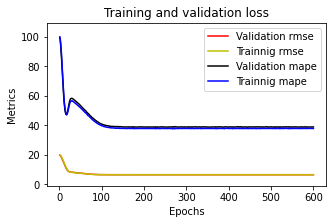

In [29]:
plotme(model2_1)

In [24]:
# inputs: distance + hour
model2_2 = nnmodel(10, num_hlayers=1,Epoch=500)
model2_2

Epoch 1/500
395/395 [==============================] - 0s 863us/step - loss: 1425548.7500 - mape: 99.8652 - rmse: 1193.9635 - val_loss: 1419063.6250 - val_mape: 99.6074 - val_rmse: 1191.2446
Epoch 2/500
395/395 [==============================] - 0s 757us/step - loss: 1413809.1250 - mape: 99.1676 - rmse: 1189.0371 - val_loss: 1402349.0000 - val_mape: 98.6072 - val_rmse: 1184.2081
Epoch 3/500
395/395 [==============================] - 0s 736us/step - loss: 1391783.7500 - mape: 97.8751 - rmse: 1179.7389 - val_loss: 1374898.6250 - val_mape: 96.9694 - val_rmse: 1172.5607
Epoch 4/500
395/395 [==============================] - 0s 711us/step - loss: 1358751.2500 - mape: 95.9213 - rmse: 1165.6549 - val_loss: 1336461.3750 - val_mape: 94.6619 - val_rmse: 1156.0542
Epoch 5/500
395/395 [==============================] - 0s 736us/step - loss: 1316197.2500 - mape: 93.3346 - rmse: 1147.2563 - val_loss: 1290458.5000 - val_mape: 91.8436 - val_rmse: 1135.9835
Epoch 6/500
395/395 [========================

395/395 [==============================] - 0s 761us/step - loss: 226534.6875 - mape: 55.8197 - rmse: 475.9566 - val_loss: 233729.1406 - val_mape: 57.4315 - val_rmse: 483.4554
Epoch 45/500
395/395 [==============================] - 0s 737us/step - loss: 225174.3594 - mape: 55.4420 - rmse: 474.5254 - val_loss: 232360.5625 - val_mape: 57.2779 - val_rmse: 482.0379
Epoch 46/500
395/395 [==============================] - 0s 731us/step - loss: 223813.1719 - mape: 55.3705 - rmse: 473.0890 - val_loss: 230984.2812 - val_mape: 57.1198 - val_rmse: 480.6082
Epoch 47/500
395/395 [==============================] - 0s 746us/step - loss: 222456.6094 - mape: 55.1809 - rmse: 471.6530 - val_loss: 229614.1719 - val_mape: 56.8872 - val_rmse: 479.1807
Epoch 48/500
395/395 [==============================] - 0s 728us/step - loss: 221105.6562 - mape: 54.9785 - rmse: 470.2187 - val_loss: 228221.4219 - val_mape: 56.6693 - val_rmse: 477.7253
Epoch 49/500
395/395 [==============================] - 0s 721us/step - l

Epoch 88/500
395/395 [==============================] - 0s 726us/step - loss: 171770.7188 - mape: 46.3660 - rmse: 414.4523 - val_loss: 176138.5156 - val_mape: 47.7218 - val_rmse: 419.6886
Epoch 89/500
395/395 [==============================] - 0s 708us/step - loss: 170839.0781 - mape: 46.1593 - rmse: 413.3268 - val_loss: 175103.9844 - val_mape: 47.4752 - val_rmse: 418.4543
Epoch 90/500
395/395 [==============================] - 0s 710us/step - loss: 169928.3906 - mape: 45.8676 - rmse: 412.2237 - val_loss: 174099.4062 - val_mape: 47.3737 - val_rmse: 417.2522
Epoch 91/500
395/395 [==============================] - 0s 737us/step - loss: 169036.9844 - mape: 45.7669 - rmse: 411.1411 - val_loss: 173137.8438 - val_mape: 47.0926 - val_rmse: 416.0984
Epoch 92/500
395/395 [==============================] - 0s 726us/step - loss: 168183.7344 - mape: 45.5007 - rmse: 410.1021 - val_loss: 172193.9375 - val_mape: 46.8174 - val_rmse: 414.9626
Epoch 93/500
395/395 [==============================] - 0s 7

395/395 [==============================] - 0s 720us/step - loss: 152672.4688 - mape: 39.3684 - rmse: 390.7332 - val_loss: 154274.1875 - val_mape: 40.6735 - val_rmse: 392.7775
Epoch 132/500
395/395 [==============================] - 0s 713us/step - loss: 152590.2188 - mape: 39.4746 - rmse: 390.6280 - val_loss: 154144.3438 - val_mape: 40.6105 - val_rmse: 392.6122
Epoch 133/500
395/395 [==============================] - 0s 719us/step - loss: 152518.4531 - mape: 39.4540 - rmse: 390.5361 - val_loss: 154033.9531 - val_mape: 40.4641 - val_rmse: 392.4716
Epoch 134/500
395/395 [==============================] - 0s 723us/step - loss: 152448.3594 - mape: 39.3124 - rmse: 390.4464 - val_loss: 153939.6562 - val_mape: 40.3374 - val_rmse: 392.3514
Epoch 135/500
395/395 [==============================] - 0s 686us/step - loss: 152380.6562 - mape: 39.2423 - rmse: 390.3596 - val_loss: 153834.9375 - val_mape: 40.2698 - val_rmse: 392.2180
Epoch 136/500
395/395 [==============================] - 0s 685us/ste

395/395 [==============================] - 0s 687us/step - loss: 151736.1719 - mape: 38.1380 - rmse: 389.5333 - val_loss: 152610.3906 - val_mape: 38.9117 - val_rmse: 390.6538
Epoch 175/500
395/395 [==============================] - 0s 685us/step - loss: 151741.8594 - mape: 37.9536 - rmse: 389.5406 - val_loss: 152602.9531 - val_mape: 38.9536 - val_rmse: 390.6443
Epoch 176/500
395/395 [==============================] - 0s 723us/step - loss: 151745.0312 - mape: 37.9276 - rmse: 389.5446 - val_loss: 152599.3594 - val_mape: 38.9611 - val_rmse: 390.6397
Epoch 177/500
395/395 [==============================] - 0s 748us/step - loss: 151741.7656 - mape: 38.0048 - rmse: 389.5405 - val_loss: 152587.5156 - val_mape: 38.9736 - val_rmse: 390.6245
Epoch 178/500
395/395 [==============================] - 0s 724us/step - loss: 151743.4062 - mape: 37.9475 - rmse: 389.5426 - val_loss: 152582.9375 - val_mape: 38.9636 - val_rmse: 390.6187
Epoch 179/500
395/395 [==============================] - 0s 707us/ste

395/395 [==============================] - 0s 711us/step - loss: 151727.5469 - mape: 37.8752 - rmse: 389.5222 - val_loss: 152488.3906 - val_mape: 38.8473 - val_rmse: 390.4976
Epoch 218/500
395/395 [==============================] - 0s 711us/step - loss: 151724.5156 - mape: 37.9607 - rmse: 389.5183 - val_loss: 152464.1094 - val_mape: 38.8327 - val_rmse: 390.4665
Epoch 219/500
395/395 [==============================] - 0s 710us/step - loss: 151728.7656 - mape: 37.7964 - rmse: 389.5238 - val_loss: 152471.7656 - val_mape: 38.8260 - val_rmse: 390.4763
Epoch 220/500
395/395 [==============================] - 0s 693us/step - loss: 151729.1875 - mape: 37.7988 - rmse: 389.5243 - val_loss: 152466.6719 - val_mape: 38.7957 - val_rmse: 390.4698
Epoch 221/500
395/395 [==============================] - 0s 703us/step - loss: 151730.4531 - mape: 37.7490 - rmse: 389.5259 - val_loss: 152450.7656 - val_mape: 38.9297 - val_rmse: 390.4494
Epoch 222/500
395/395 [==============================] - 0s 667us/ste

395/395 [==============================] - 0s 711us/step - loss: 151733.2500 - mape: 37.7864 - rmse: 389.5295 - val_loss: 152466.9375 - val_mape: 38.7927 - val_rmse: 390.4702
Epoch 261/500
395/395 [==============================] - 0s 737us/step - loss: 151733.2812 - mape: 37.7764 - rmse: 389.5296 - val_loss: 152482.2969 - val_mape: 38.7455 - val_rmse: 390.4898
Epoch 262/500
395/395 [==============================] - 0s 753us/step - loss: 151726.3125 - mape: 37.7098 - rmse: 389.5206 - val_loss: 152464.6094 - val_mape: 38.8168 - val_rmse: 390.4672
Epoch 263/500
395/395 [==============================] - 0s 736us/step - loss: 151730.7344 - mape: 37.8427 - rmse: 389.5263 - val_loss: 152475.9062 - val_mape: 38.7366 - val_rmse: 390.4816
Epoch 264/500
395/395 [==============================] - 0s 710us/step - loss: 151729.7344 - mape: 37.7810 - rmse: 389.5250 - val_loss: 152461.7812 - val_mape: 38.7521 - val_rmse: 390.4635
Epoch 265/500
395/395 [==============================] - 0s 736us/ste

395/395 [==============================] - 0s 717us/step - loss: 151730.9844 - mape: 37.7657 - rmse: 389.5266 - val_loss: 152437.8750 - val_mape: 38.8447 - val_rmse: 390.4329
Epoch 304/500
395/395 [==============================] - 0s 736us/step - loss: 151732.6094 - mape: 37.7850 - rmse: 389.5287 - val_loss: 152454.0625 - val_mape: 38.8360 - val_rmse: 390.4537
Epoch 305/500
395/395 [==============================] - 0s 736us/step - loss: 151731.2656 - mape: 37.7767 - rmse: 389.5270 - val_loss: 152442.0781 - val_mape: 38.8345 - val_rmse: 390.4383
Epoch 306/500
395/395 [==============================] - 0s 711us/step - loss: 151730.2812 - mape: 37.7794 - rmse: 389.5257 - val_loss: 152459.6875 - val_mape: 38.8682 - val_rmse: 390.4609
Epoch 307/500
395/395 [==============================] - 0s 711us/step - loss: 151732.5000 - mape: 37.8137 - rmse: 389.5286 - val_loss: 152460.0156 - val_mape: 38.8841 - val_rmse: 390.4613
Epoch 308/500
395/395 [==============================] - 0s 710us/ste

395/395 [==============================] - 0s 711us/step - loss: 151730.1250 - mape: 37.7771 - rmse: 389.5255 - val_loss: 152456.5156 - val_mape: 38.8189 - val_rmse: 390.4568
Epoch 347/500
395/395 [==============================] - 0s 698us/step - loss: 151731.7031 - mape: 37.7641 - rmse: 389.5275 - val_loss: 152454.9219 - val_mape: 38.8052 - val_rmse: 390.4548
Epoch 348/500
395/395 [==============================] - 0s 725us/step - loss: 151729.5469 - mape: 37.8173 - rmse: 389.5248 - val_loss: 152448.7969 - val_mape: 38.7904 - val_rmse: 390.4469
Epoch 349/500
395/395 [==============================] - 0s 698us/step - loss: 151727.7812 - mape: 37.7735 - rmse: 389.5225 - val_loss: 152461.4844 - val_mape: 38.8087 - val_rmse: 390.4632
Epoch 350/500
395/395 [==============================] - 0s 723us/step - loss: 151734.5938 - mape: 37.7481 - rmse: 389.5312 - val_loss: 152447.2969 - val_mape: 38.8080 - val_rmse: 390.4450
Epoch 351/500
395/395 [==============================] - 0s 711us/ste

395/395 [==============================] - 0s 736us/step - loss: 151730.3438 - mape: 37.8719 - rmse: 389.5258 - val_loss: 152440.5156 - val_mape: 38.8233 - val_rmse: 390.4363
Epoch 390/500
395/395 [==============================] - 0s 710us/step - loss: 151734.7500 - mape: 37.8292 - rmse: 389.5315 - val_loss: 152443.1875 - val_mape: 38.8247 - val_rmse: 390.4397
Epoch 391/500
395/395 [==============================] - 0s 710us/step - loss: 151731.0781 - mape: 37.8248 - rmse: 389.5267 - val_loss: 152453.7188 - val_mape: 38.7766 - val_rmse: 390.4532
Epoch 392/500
395/395 [==============================] - 0s 725us/step - loss: 151733.5000 - mape: 37.7256 - rmse: 389.5298 - val_loss: 152445.4062 - val_mape: 38.8087 - val_rmse: 390.4426
Epoch 393/500
395/395 [==============================] - 0s 720us/step - loss: 151731.3594 - mape: 37.7790 - rmse: 389.5271 - val_loss: 152444.5781 - val_mape: 38.8011 - val_rmse: 390.4415
Epoch 394/500
395/395 [==============================] - 0s 752us/ste

395/395 [==============================] - 0s 704us/step - loss: 151730.1719 - mape: 37.7585 - rmse: 389.5256 - val_loss: 152444.6250 - val_mape: 38.8243 - val_rmse: 390.4416
Epoch 433/500
395/395 [==============================] - 0s 725us/step - loss: 151730.6094 - mape: 37.8294 - rmse: 389.5261 - val_loss: 152440.5312 - val_mape: 38.7914 - val_rmse: 390.4363
Epoch 434/500
395/395 [==============================] - 0s 733us/step - loss: 151729.4219 - mape: 37.7826 - rmse: 389.5246 - val_loss: 152459.2500 - val_mape: 38.7721 - val_rmse: 390.4603
Epoch 435/500
395/395 [==============================] - 0s 723us/step - loss: 151733.4375 - mape: 37.8431 - rmse: 389.5298 - val_loss: 152456.0000 - val_mape: 38.8217 - val_rmse: 390.4561
Epoch 436/500
395/395 [==============================] - 0s 736us/step - loss: 151729.2031 - mape: 37.7841 - rmse: 389.5243 - val_loss: 152472.2188 - val_mape: 38.7861 - val_rmse: 390.4769
Epoch 437/500
395/395 [==============================] - 0s 761us/ste

395/395 [==============================] - 0s 686us/step - loss: 151727.5938 - mape: 37.7730 - rmse: 389.5223 - val_loss: 152474.2188 - val_mape: 38.8039 - val_rmse: 390.4795
Epoch 476/500
395/395 [==============================] - 0s 686us/step - loss: 151732.8594 - mape: 37.8275 - rmse: 389.5290 - val_loss: 152461.5156 - val_mape: 38.8872 - val_rmse: 390.4632
Epoch 477/500
395/395 [==============================] - 0s 715us/step - loss: 151731.4062 - mape: 37.9607 - rmse: 389.5272 - val_loss: 152451.7500 - val_mape: 38.7714 - val_rmse: 390.4507
Epoch 478/500
395/395 [==============================] - 0s 724us/step - loss: 151723.5938 - mape: 37.7550 - rmse: 389.5171 - val_loss: 152458.7500 - val_mape: 38.7913 - val_rmse: 390.4597
Epoch 479/500
395/395 [==============================] - 0s 735us/step - loss: 151727.5625 - mape: 37.8309 - rmse: 389.5222 - val_loss: 152460.4688 - val_mape: 38.7924 - val_rmse: 390.4619
Epoch 480/500
395/395 [==============================] - 0s 749us/ste

In [31]:
# plotme(model2_2)

In [25]:
# inputs: distance + hour
model2_3 = nnmodel(5, num_hlayers=1,Epoch=500)
model2_3

Epoch 1/500
395/395 [==============================] - 0s 862us/step - loss: 1426713.0000 - mape: 99.9351 - rmse: 1194.4509 - val_loss: 1422916.8750 - val_mape: 99.8462 - val_rmse: 1192.8608
Epoch 2/500
395/395 [==============================] - 0s 734us/step - loss: 1422855.8750 - mape: 99.7131 - rmse: 1192.8352 - val_loss: 1417385.0000 - val_mape: 99.5225 - val_rmse: 1190.5398
Epoch 3/500
395/395 [==============================] - 0s 749us/step - loss: 1414894.8750 - mape: 99.2560 - rmse: 1189.4935 - val_loss: 1407128.3750 - val_mape: 98.9294 - val_rmse: 1186.2244
Epoch 4/500
395/395 [==============================] - 0s 723us/step - loss: 1402518.2500 - mape: 98.5465 - rmse: 1184.2797 - val_loss: 1392949.0000 - val_mape: 98.1002 - val_rmse: 1180.2325
Epoch 5/500
395/395 [==============================] - 0s 725us/step - loss: 1386958.0000 - mape: 97.6391 - rmse: 1177.6918 - val_loss: 1376139.7500 - val_mape: 97.1089 - val_rmse: 1173.0898
Epoch 6/500
395/395 [========================

395/395 [==============================] - 0s 710us/step - loss: 345253.1562 - mape: 48.1653 - rmse: 587.5825 - val_loss: 338635.6250 - val_mape: 48.7495 - val_rmse: 581.9241
Epoch 45/500
395/395 [==============================] - 0s 736us/step - loss: 330986.3125 - mape: 48.6458 - rmse: 575.3141 - val_loss: 325348.3750 - val_mape: 49.3626 - val_rmse: 570.3932
Epoch 46/500
395/395 [==============================] - 0s 737us/step - loss: 317990.6875 - mape: 49.2087 - rmse: 563.9066 - val_loss: 313327.8125 - val_mape: 50.0712 - val_rmse: 559.7569
Epoch 47/500
395/395 [==============================] - 0s 736us/step - loss: 306256.2188 - mape: 49.8744 - rmse: 553.4042 - val_loss: 302632.1562 - val_mape: 50.7996 - val_rmse: 550.1201
Epoch 48/500
395/395 [==============================] - 0s 710us/step - loss: 295806.6875 - mape: 50.5669 - rmse: 543.8811 - val_loss: 293180.5000 - val_mape: 51.5856 - val_rmse: 541.4614
Epoch 49/500
395/395 [==============================] - 0s 745us/step - l

Epoch 88/500
395/395 [==============================] - 0s 721us/step - loss: 216909.8281 - mape: 54.3438 - rmse: 465.7358 - val_loss: 224165.6250 - val_mape: 56.1032 - val_rmse: 473.4613
Epoch 89/500
395/395 [==============================] - 0s 736us/step - loss: 216124.8438 - mape: 54.2610 - rmse: 464.8923 - val_loss: 223348.6875 - val_mape: 56.0383 - val_rmse: 472.5978
Epoch 90/500
395/395 [==============================] - 0s 711us/step - loss: 215345.2031 - mape: 54.2220 - rmse: 464.0530 - val_loss: 222564.7188 - val_mape: 55.9451 - val_rmse: 471.7676
Epoch 91/500
395/395 [==============================] - 0s 736us/step - loss: 214572.0938 - mape: 54.1104 - rmse: 463.2193 - val_loss: 221750.5625 - val_mape: 55.8219 - val_rmse: 470.9040
Epoch 92/500
395/395 [==============================] - 0s 739us/step - loss: 213798.5469 - mape: 53.9752 - rmse: 462.3835 - val_loss: 220948.2500 - val_mape: 55.6794 - val_rmse: 470.0513
Epoch 93/500
395/395 [==============================] - 0s 7

395/395 [==============================] - 0s 762us/step - loss: 184327.5469 - mape: 49.1316 - rmse: 429.3338 - val_loss: 189840.9062 - val_mape: 50.6015 - val_rmse: 435.7074
Epoch 132/500
395/395 [==============================] - 0s 694us/step - loss: 183631.8281 - mape: 48.9524 - rmse: 428.5229 - val_loss: 189091.9844 - val_mape: 50.4767 - val_rmse: 434.8471
Epoch 133/500
395/395 [==============================] - 0s 747us/step - loss: 182943.7031 - mape: 48.8325 - rmse: 427.7192 - val_loss: 188352.2656 - val_mape: 50.3317 - val_rmse: 433.9957
Epoch 134/500
395/395 [==============================] - 0s 705us/step - loss: 182266.4219 - mape: 48.7574 - rmse: 426.9267 - val_loss: 187655.7188 - val_mape: 50.2062 - val_rmse: 433.1925
Epoch 135/500
395/395 [==============================] - 0s 710us/step - loss: 181592.9531 - mape: 48.5346 - rmse: 426.1372 - val_loss: 186925.8281 - val_mape: 50.0441 - val_rmse: 432.3492
Epoch 136/500
395/395 [==============================] - 0s 735us/ste

395/395 [==============================] - 0s 721us/step - loss: 161179.0625 - mape: 43.4995 - rmse: 401.4711 - val_loss: 164599.3125 - val_mape: 44.8197 - val_rmse: 405.7084
Epoch 175/500
395/395 [==============================] - 0s 736us/step - loss: 160824.0469 - mape: 43.4555 - rmse: 401.0287 - val_loss: 164199.5156 - val_mape: 44.7102 - val_rmse: 405.2154
Epoch 176/500
395/395 [==============================] - 0s 723us/step - loss: 160484.5781 - mape: 43.4042 - rmse: 400.6053 - val_loss: 163812.9688 - val_mape: 44.5704 - val_rmse: 404.7382
Epoch 177/500
395/395 [==============================] - 0s 723us/step - loss: 160156.7344 - mape: 43.2195 - rmse: 400.1959 - val_loss: 163440.2656 - val_mape: 44.4564 - val_rmse: 404.2775
Epoch 178/500
395/395 [==============================] - 0s 710us/step - loss: 159833.2188 - mape: 43.0657 - rmse: 399.7915 - val_loss: 163066.6875 - val_mape: 44.3240 - val_rmse: 403.8152
Epoch 179/500
395/395 [==============================] - 0s 736us/ste

395/395 [==============================] - 0s 710us/step - loss: 153050.6562 - mape: 39.8974 - rmse: 391.2169 - val_loss: 154862.0156 - val_mape: 41.0300 - val_rmse: 393.5251
Epoch 218/500
395/395 [==============================] - 0s 736us/step - loss: 152982.9844 - mape: 39.8880 - rmse: 391.1304 - val_loss: 154771.0000 - val_mape: 40.9273 - val_rmse: 393.4095
Epoch 219/500
395/395 [==============================] - 0s 743us/step - loss: 152920.0312 - mape: 39.6877 - rmse: 391.0499 - val_loss: 154684.9844 - val_mape: 40.8494 - val_rmse: 393.3001
Epoch 220/500
395/395 [==============================] - 0s 724us/step - loss: 152862.1250 - mape: 39.6481 - rmse: 390.9759 - val_loss: 154609.2500 - val_mape: 40.7786 - val_rmse: 393.2038
Epoch 221/500
395/395 [==============================] - 0s 720us/step - loss: 152800.1094 - mape: 39.6612 - rmse: 390.8965 - val_loss: 154517.6719 - val_mape: 40.7823 - val_rmse: 393.0874
Epoch 222/500
395/395 [==============================] - 0s 715us/ste

395/395 [==============================] - 0s 732us/step - loss: 151846.8594 - mape: 38.3916 - rmse: 389.6753 - val_loss: 152923.6562 - val_mape: 39.4608 - val_rmse: 391.0545
Epoch 261/500
395/395 [==============================] - 0s 731us/step - loss: 151840.4062 - mape: 38.3456 - rmse: 389.6671 - val_loss: 152898.6250 - val_mape: 39.4677 - val_rmse: 391.0226
Epoch 262/500
395/395 [==============================] - 0s 712us/step - loss: 151830.1719 - mape: 38.3928 - rmse: 389.6539 - val_loss: 152890.0156 - val_mape: 39.4022 - val_rmse: 391.0115
Epoch 263/500
395/395 [==============================] - 0s 737us/step - loss: 151826.9375 - mape: 38.3870 - rmse: 389.6497 - val_loss: 152868.1719 - val_mape: 39.4073 - val_rmse: 390.9836
Epoch 264/500
395/395 [==============================] - 0s 723us/step - loss: 151819.7812 - mape: 38.4104 - rmse: 389.6406 - val_loss: 152853.0625 - val_mape: 39.3390 - val_rmse: 390.9643
Epoch 265/500
395/395 [==============================] - 0s 743us/ste

395/395 [==============================] - 0s 709us/step - loss: 151731.4688 - mape: 37.9651 - rmse: 389.5273 - val_loss: 152560.7656 - val_mape: 38.9711 - val_rmse: 390.5903
Epoch 304/500
395/395 [==============================] - 0s 711us/step - loss: 151731.5938 - mape: 38.0314 - rmse: 389.5274 - val_loss: 152553.2188 - val_mape: 38.9639 - val_rmse: 390.5806
Epoch 305/500
395/395 [==============================] - 0s 736us/step - loss: 151730.8594 - mape: 37.9972 - rmse: 389.5265 - val_loss: 152551.9219 - val_mape: 38.9478 - val_rmse: 390.5789
Epoch 306/500
395/395 [==============================] - 0s 720us/step - loss: 151732.0469 - mape: 37.9878 - rmse: 389.5280 - val_loss: 152551.8438 - val_mape: 38.9074 - val_rmse: 390.5789
Epoch 307/500
395/395 [==============================] - 0s 727us/step - loss: 151731.0156 - mape: 37.9115 - rmse: 389.5266 - val_loss: 152557.7812 - val_mape: 38.8807 - val_rmse: 390.5865
Epoch 308/500
395/395 [==============================] - 0s 711us/ste

395/395 [==============================] - 0s 736us/step - loss: 151722.3906 - mape: 37.8300 - rmse: 389.5156 - val_loss: 152497.3906 - val_mape: 38.8459 - val_rmse: 390.5092
Epoch 347/500
395/395 [==============================] - 0s 748us/step - loss: 151721.9219 - mape: 37.8920 - rmse: 389.5150 - val_loss: 152475.4844 - val_mape: 38.8624 - val_rmse: 390.4811
Epoch 348/500
395/395 [==============================] - 0s 736us/step - loss: 151720.6562 - mape: 37.8740 - rmse: 389.5134 - val_loss: 152480.1719 - val_mape: 38.8214 - val_rmse: 390.4871
Epoch 349/500
395/395 [==============================] - 0s 736us/step - loss: 151719.6250 - mape: 37.7713 - rmse: 389.5120 - val_loss: 152492.9062 - val_mape: 38.8366 - val_rmse: 390.5034
Epoch 350/500
395/395 [==============================] - 0s 743us/step - loss: 151721.7969 - mape: 37.8315 - rmse: 389.5148 - val_loss: 152478.7188 - val_mape: 38.8288 - val_rmse: 390.4852
Epoch 351/500
395/395 [==============================] - 0s 729us/ste

395/395 [==============================] - 0s 749us/step - loss: 151722.3750 - mape: 37.8989 - rmse: 389.5156 - val_loss: 152470.8750 - val_mape: 38.8489 - val_rmse: 390.4752
Epoch 390/500
395/395 [==============================] - 0s 748us/step - loss: 151719.6250 - mape: 37.8215 - rmse: 389.5120 - val_loss: 152472.6250 - val_mape: 38.7991 - val_rmse: 390.4774
Epoch 391/500
395/395 [==============================] - 0s 724us/step - loss: 151718.3438 - mape: 37.7772 - rmse: 389.5104 - val_loss: 152467.8594 - val_mape: 38.8140 - val_rmse: 390.4713
Epoch 392/500
395/395 [==============================] - 0s 723us/step - loss: 151725.3594 - mape: 37.8316 - rmse: 389.5194 - val_loss: 152472.0156 - val_mape: 38.8223 - val_rmse: 390.4767
Epoch 393/500
395/395 [==============================] - 0s 736us/step - loss: 151722.4844 - mape: 37.7751 - rmse: 389.5157 - val_loss: 152473.4062 - val_mape: 38.8586 - val_rmse: 390.4784
Epoch 394/500
395/395 [==============================] - 0s 763us/ste

395/395 [==============================] - 0s 728us/step - loss: 151718.3438 - mape: 37.7836 - rmse: 389.5104 - val_loss: 152478.4062 - val_mape: 38.7896 - val_rmse: 390.4848
Epoch 433/500
395/395 [==============================] - 0s 711us/step - loss: 151720.3125 - mape: 37.8308 - rmse: 389.5129 - val_loss: 152467.9219 - val_mape: 38.8201 - val_rmse: 390.4714
Epoch 434/500
395/395 [==============================] - 0s 711us/step - loss: 151726.3438 - mape: 37.8253 - rmse: 389.5207 - val_loss: 152473.1875 - val_mape: 38.7955 - val_rmse: 390.4781
Epoch 435/500
395/395 [==============================] - 0s 736us/step - loss: 151720.5469 - mape: 37.8634 - rmse: 389.5132 - val_loss: 152477.7031 - val_mape: 38.7722 - val_rmse: 390.4839
Epoch 436/500
395/395 [==============================] - 0s 706us/step - loss: 151720.0781 - mape: 37.7202 - rmse: 389.5126 - val_loss: 152477.9062 - val_mape: 38.7625 - val_rmse: 390.4842
Epoch 437/500
395/395 [==============================] - 0s 726us/ste

395/395 [==============================] - 0s 698us/step - loss: 151724.4219 - mape: 37.8674 - rmse: 389.5182 - val_loss: 152465.8281 - val_mape: 38.8715 - val_rmse: 390.4687
Epoch 476/500
395/395 [==============================] - 0s 725us/step - loss: 151718.5156 - mape: 37.7696 - rmse: 389.5106 - val_loss: 152458.8750 - val_mape: 38.8691 - val_rmse: 390.4598
Epoch 477/500
395/395 [==============================] - 0s 724us/step - loss: 151721.5938 - mape: 37.8529 - rmse: 389.5146 - val_loss: 152456.0625 - val_mape: 38.8489 - val_rmse: 390.4562
Epoch 478/500
395/395 [==============================] - 0s 736us/step - loss: 151722.4375 - mape: 37.8201 - rmse: 389.5157 - val_loss: 152466.2344 - val_mape: 38.7955 - val_rmse: 390.4692
Epoch 479/500
395/395 [==============================] - 0s 717us/step - loss: 151723.3594 - mape: 37.8276 - rmse: 389.5168 - val_loss: 152469.8438 - val_mape: 38.7787 - val_rmse: 390.4739
Epoch 480/500
395/395 [==============================] - 0s 714us/ste

In [26]:
# inputs: distance + hour
model2_4 = nnmodel(10,5, num_hlayers=2,Epoch=500)
model2_4

Epoch 1/500
395/395 [==============================] - 1s 863us/step - loss: 1420651.3750 - mape: 99.5781 - rmse: 1191.9108 - val_loss: 1401318.6250 - val_mape: 98.5572 - val_rmse: 1183.7731
Epoch 2/500
395/395 [==============================] - 0s 787us/step - loss: 1344723.5000 - mape: 95.0319 - rmse: 1159.6222 - val_loss: 1254672.7500 - val_mape: 89.5457 - val_rmse: 1120.1217
Epoch 3/500
395/395 [==============================] - 0s 761us/step - loss: 1118770.1250 - mape: 80.5426 - rmse: 1057.7194 - val_loss: 959194.0625 - val_mape: 69.5785 - val_rmse: 979.3845
Epoch 4/500
395/395 [==============================] - 0s 778us/step - loss: 796704.2500 - mape: 60.2499 - rmse: 892.5829 - val_loss: 637928.3125 - val_mape: 53.1642 - val_rmse: 798.7042
Epoch 5/500
395/395 [==============================] - 0s 746us/step - loss: 522512.5625 - mape: 50.6923 - rmse: 722.8503 - val_loss: 422075.8750 - val_mape: 49.4045 - val_rmse: 649.6736
Epoch 6/500
395/395 [==============================] - 

395/395 [==============================] - 0s 718us/step - loss: 151909.8906 - mape: 38.1647 - rmse: 389.7562 - val_loss: 152772.2500 - val_mape: 39.0711 - val_rmse: 390.8609
Epoch 45/500
395/395 [==============================] - 0s 736us/step - loss: 151889.6719 - mape: 38.1818 - rmse: 389.7303 - val_loss: 152687.8906 - val_mape: 39.1023 - val_rmse: 390.7530
Epoch 46/500
395/395 [==============================] - 0s 736us/step - loss: 151853.0625 - mape: 38.1065 - rmse: 389.6833 - val_loss: 152661.4688 - val_mape: 39.0355 - val_rmse: 390.7192
Epoch 47/500
395/395 [==============================] - 0s 744us/step - loss: 151852.5781 - mape: 38.1968 - rmse: 389.6827 - val_loss: 152581.4375 - val_mape: 39.0742 - val_rmse: 390.6167
Epoch 48/500
395/395 [==============================] - 0s 724us/step - loss: 151838.9844 - mape: 38.0777 - rmse: 389.6652 - val_loss: 152688.2969 - val_mape: 38.7975 - val_rmse: 390.7535
Epoch 49/500
395/395 [==============================] - 0s 765us/step - l

Epoch 88/500
395/395 [==============================] - 0s 742us/step - loss: 151758.0000 - mape: 37.9060 - rmse: 389.5613 - val_loss: 152442.9844 - val_mape: 38.8295 - val_rmse: 390.4395
Epoch 89/500
395/395 [==============================] - 0s 755us/step - loss: 151793.7969 - mape: 37.8387 - rmse: 389.6072 - val_loss: 152523.3125 - val_mape: 39.0615 - val_rmse: 390.5423
Epoch 90/500
395/395 [==============================] - 0s 746us/step - loss: 151744.2344 - mape: 38.0388 - rmse: 389.5436 - val_loss: 152526.2031 - val_mape: 38.3485 - val_rmse: 390.5460
Epoch 91/500
395/395 [==============================] - 0s 726us/step - loss: 151807.0000 - mape: 37.7979 - rmse: 389.6242 - val_loss: 152478.2812 - val_mape: 38.4847 - val_rmse: 390.4847
Epoch 92/500
395/395 [==============================] - 0s 736us/step - loss: 151802.8906 - mape: 37.8608 - rmse: 389.6189 - val_loss: 152377.0469 - val_mape: 38.8908 - val_rmse: 390.3550
Epoch 93/500
395/395 [==============================] - 0s 7

395/395 [==============================] - 0s 739us/step - loss: 151768.0312 - mape: 37.8570 - rmse: 389.5742 - val_loss: 152593.9062 - val_mape: 38.2789 - val_rmse: 390.6327
Epoch 132/500
395/395 [==============================] - 0s 736us/step - loss: 151819.3438 - mape: 37.6887 - rmse: 389.6400 - val_loss: 152461.3750 - val_mape: 39.1125 - val_rmse: 390.4630
Epoch 133/500
395/395 [==============================] - 0s 737us/step - loss: 151797.0625 - mape: 38.0056 - rmse: 389.6114 - val_loss: 152601.6719 - val_mape: 38.4626 - val_rmse: 390.6426
Epoch 134/500
395/395 [==============================] - 0s 736us/step - loss: 151770.0000 - mape: 37.8563 - rmse: 389.5767 - val_loss: 152477.9844 - val_mape: 38.5473 - val_rmse: 390.4843
Epoch 135/500
395/395 [==============================] - 0s 752us/step - loss: 151789.5938 - mape: 37.7758 - rmse: 389.6018 - val_loss: 152472.2031 - val_mape: 38.7617 - val_rmse: 390.4769
Epoch 136/500
395/395 [==============================] - 0s 740us/ste

395/395 [==============================] - 0s 760us/step - loss: 151792.5469 - mape: 37.7053 - rmse: 389.6056 - val_loss: 152464.1562 - val_mape: 38.5655 - val_rmse: 390.4666
Epoch 175/500
395/395 [==============================] - 0s 735us/step - loss: 151770.4688 - mape: 37.8203 - rmse: 389.5773 - val_loss: 152368.1094 - val_mape: 39.0639 - val_rmse: 390.3436
Epoch 176/500
395/395 [==============================] - 0s 750us/step - loss: 151778.3125 - mape: 37.8539 - rmse: 389.5874 - val_loss: 152610.8750 - val_mape: 39.0620 - val_rmse: 390.6544
Epoch 177/500
395/395 [==============================] - 0s 734us/step - loss: 151781.7656 - mape: 37.8078 - rmse: 389.5918 - val_loss: 152406.8125 - val_mape: 39.1109 - val_rmse: 390.3932
Epoch 178/500
395/395 [==============================] - 0s 736us/step - loss: 151775.7656 - mape: 37.9290 - rmse: 389.5841 - val_loss: 152478.4219 - val_mape: 38.4957 - val_rmse: 390.4849
Epoch 179/500
395/395 [==============================] - 0s 736us/ste

395/395 [==============================] - 0s 731us/step - loss: 151757.1094 - mape: 37.7839 - rmse: 389.5602 - val_loss: 152547.7188 - val_mape: 39.0265 - val_rmse: 390.5736
Epoch 218/500
395/395 [==============================] - 0s 736us/step - loss: 151765.3906 - mape: 37.9377 - rmse: 389.5708 - val_loss: 152520.8594 - val_mape: 38.3840 - val_rmse: 390.5392
Epoch 219/500
395/395 [==============================] - 0s 724us/step - loss: 151787.5312 - mape: 37.6654 - rmse: 389.5992 - val_loss: 152376.6250 - val_mape: 39.0365 - val_rmse: 390.3545
Epoch 220/500
395/395 [==============================] - 0s 736us/step - loss: 151782.6562 - mape: 37.7250 - rmse: 389.5929 - val_loss: 152388.8750 - val_mape: 39.1978 - val_rmse: 390.3702
Epoch 221/500
395/395 [==============================] - 0s 736us/step - loss: 151799.6719 - mape: 37.7834 - rmse: 389.6148 - val_loss: 152392.0938 - val_mape: 39.0712 - val_rmse: 390.3743
Epoch 222/500
395/395 [==============================] - 0s 736us/ste

395/395 [==============================] - 0s 736us/step - loss: 151771.3906 - mape: 37.7548 - rmse: 389.5785 - val_loss: 152378.6719 - val_mape: 38.8051 - val_rmse: 390.3571
Epoch 261/500
395/395 [==============================] - 0s 735us/step - loss: 151756.9062 - mape: 37.7121 - rmse: 389.5599 - val_loss: 152426.3281 - val_mape: 39.2496 - val_rmse: 390.4182
Epoch 262/500
395/395 [==============================] - 0s 759us/step - loss: 151778.1406 - mape: 37.9685 - rmse: 389.5871 - val_loss: 152491.6875 - val_mape: 38.4613 - val_rmse: 390.5018
Epoch 263/500
395/395 [==============================] - 0s 730us/step - loss: 151776.0312 - mape: 37.6973 - rmse: 389.5844 - val_loss: 152579.7500 - val_mape: 38.7308 - val_rmse: 390.6146
Epoch 264/500
395/395 [==============================] - 0s 754us/step - loss: 151785.0625 - mape: 37.9293 - rmse: 389.5960 - val_loss: 152471.9375 - val_mape: 38.6480 - val_rmse: 390.4766
Epoch 265/500
395/395 [==============================] - 0s 739us/ste

395/395 [==============================] - 0s 719us/step - loss: 151763.4531 - mape: 37.9104 - rmse: 389.5683 - val_loss: 152393.7344 - val_mape: 38.7012 - val_rmse: 390.3764
Epoch 304/500
395/395 [==============================] - 0s 735us/step - loss: 151774.7031 - mape: 37.8372 - rmse: 389.5827 - val_loss: 152438.2188 - val_mape: 38.6959 - val_rmse: 390.4334
Epoch 305/500
395/395 [==============================] - 0s 749us/step - loss: 151786.9844 - mape: 37.8561 - rmse: 389.5985 - val_loss: 152497.2500 - val_mape: 38.5823 - val_rmse: 390.5090
Epoch 306/500
395/395 [==============================] - 0s 748us/step - loss: 151796.2500 - mape: 37.7943 - rmse: 389.6104 - val_loss: 152481.4062 - val_mape: 38.5813 - val_rmse: 390.4887
Epoch 307/500
395/395 [==============================] - 0s 737us/step - loss: 151793.0000 - mape: 37.7267 - rmse: 389.6062 - val_loss: 152487.3594 - val_mape: 39.1181 - val_rmse: 390.4963
Epoch 308/500
395/395 [==============================] - 0s 749us/ste

395/395 [==============================] - 0s 731us/step - loss: 151797.8438 - mape: 37.7163 - rmse: 389.6124 - val_loss: 152454.4219 - val_mape: 39.0877 - val_rmse: 390.4541
Epoch 347/500
395/395 [==============================] - 0s 718us/step - loss: 151785.1875 - mape: 37.9953 - rmse: 389.5962 - val_loss: 152459.8906 - val_mape: 38.4753 - val_rmse: 390.4611
Epoch 348/500
395/395 [==============================] - 0s 724us/step - loss: 151783.3281 - mape: 37.7842 - rmse: 389.5938 - val_loss: 152514.2188 - val_mape: 38.4220 - val_rmse: 390.5307
Epoch 349/500
395/395 [==============================] - 0s 736us/step - loss: 151805.2188 - mape: 37.7151 - rmse: 389.6219 - val_loss: 152439.5625 - val_mape: 38.7434 - val_rmse: 390.4351
Epoch 350/500
395/395 [==============================] - 0s 739us/step - loss: 151812.0781 - mape: 37.7505 - rmse: 389.6307 - val_loss: 152451.1719 - val_mape: 38.8673 - val_rmse: 390.4500
Epoch 351/500
395/395 [==============================] - 0s 760us/ste

395/395 [==============================] - 0s 749us/step - loss: 151767.7188 - mape: 37.8085 - rmse: 389.5738 - val_loss: 152477.2344 - val_mape: 38.3460 - val_rmse: 390.4833
Epoch 390/500
395/395 [==============================] - 0s 749us/step - loss: 151780.5938 - mape: 37.6674 - rmse: 389.5903 - val_loss: 152419.5469 - val_mape: 38.8898 - val_rmse: 390.4095
Epoch 391/500
395/395 [==============================] - 0s 735us/step - loss: 151770.5469 - mape: 37.7188 - rmse: 389.5774 - val_loss: 152456.1875 - val_mape: 39.1607 - val_rmse: 390.4564
Epoch 392/500
395/395 [==============================] - 0s 748us/step - loss: 151784.0469 - mape: 37.9721 - rmse: 389.5947 - val_loss: 152518.3281 - val_mape: 38.3118 - val_rmse: 390.5359
Epoch 393/500
395/395 [==============================] - 0s 745us/step - loss: 151773.6250 - mape: 37.6999 - rmse: 389.5814 - val_loss: 152493.6719 - val_mape: 38.6680 - val_rmse: 390.5044
Epoch 394/500
395/395 [==============================] - 0s 722us/ste

395/395 [==============================] - 0s 751us/step - loss: 151785.0469 - mape: 37.7723 - rmse: 389.5960 - val_loss: 152531.6562 - val_mape: 38.6480 - val_rmse: 390.5530
Epoch 433/500
395/395 [==============================] - 0s 735us/step - loss: 151797.0781 - mape: 37.8080 - rmse: 389.6115 - val_loss: 152412.8594 - val_mape: 38.7225 - val_rmse: 390.4009
Epoch 434/500
395/395 [==============================] - 0s 737us/step - loss: 151807.7188 - mape: 37.7613 - rmse: 389.6251 - val_loss: 152562.9375 - val_mape: 38.7193 - val_rmse: 390.5930
Epoch 435/500
395/395 [==============================] - 0s 736us/step - loss: 151793.3906 - mape: 37.8524 - rmse: 389.6067 - val_loss: 152496.8438 - val_mape: 38.6837 - val_rmse: 390.5085
Epoch 436/500
395/395 [==============================] - 0s 726us/step - loss: 151772.4688 - mape: 37.8164 - rmse: 389.5799 - val_loss: 152585.1406 - val_mape: 38.8446 - val_rmse: 390.6215
Epoch 437/500
395/395 [==============================] - 0s 761us/ste

395/395 [==============================] - 0s 742us/step - loss: 151789.3906 - mape: 37.6639 - rmse: 389.6016 - val_loss: 152472.7188 - val_mape: 38.9981 - val_rmse: 390.4775
Epoch 476/500
395/395 [==============================] - 0s 736us/step - loss: 151792.0000 - mape: 37.7831 - rmse: 389.6049 - val_loss: 152460.2031 - val_mape: 38.9478 - val_rmse: 390.4615
Epoch 477/500
395/395 [==============================] - 0s 732us/step - loss: 151768.9531 - mape: 37.8351 - rmse: 389.5753 - val_loss: 152471.1250 - val_mape: 38.9124 - val_rmse: 390.4755
Epoch 478/500
395/395 [==============================] - 0s 745us/step - loss: 151750.4219 - mape: 37.6420 - rmse: 389.5516 - val_loss: 152491.3750 - val_mape: 39.3326 - val_rmse: 390.5014
Epoch 479/500
395/395 [==============================] - 0s 749us/step - loss: 151781.8594 - mape: 37.9854 - rmse: 389.5919 - val_loss: 152610.1250 - val_mape: 38.3967 - val_rmse: 390.6535
Epoch 480/500
395/395 [==============================] - 0s 748us/ste

In [27]:
# inputs: distance + hour
model2_5 = nnmodel(20,10, num_hlayers=2,Epoch=500)
model2_5

Epoch 1/500
395/395 [==============================] - 1s 893us/step - loss: 1387497.2500 - mape: 97.6001 - rmse: 1177.9208 - val_loss: 1281688.5000 - val_mape: 91.1993 - val_rmse: 1132.1168
Epoch 2/500
395/395 [==============================] - 0s 761us/step - loss: 1005323.0000 - mape: 72.9528 - rmse: 1002.6580 - val_loss: 681454.0625 - val_mape: 54.3330 - val_rmse: 825.5023
Epoch 3/500
395/395 [==============================] - 0s 761us/step - loss: 467145.6875 - mape: 50.8285 - rmse: 683.4806 - val_loss: 327754.2812 - val_mape: 52.1517 - val_rmse: 572.4983
Epoch 4/500
395/395 [==============================] - 0s 749us/step - loss: 278730.8125 - mape: 54.6273 - rmse: 527.9496 - val_loss: 257075.0312 - val_mape: 57.9011 - val_rmse: 507.0257
Epoch 5/500
395/395 [==============================] - 0s 754us/step - loss: 243063.6562 - mape: 57.0933 - rmse: 493.0149 - val_loss: 244348.9531 - val_mape: 58.4075 - val_rmse: 494.3167
Epoch 6/500
395/395 [==============================] - 0s 7

395/395 [==============================] - 0s 717us/step - loss: 151793.8281 - mape: 37.7666 - rmse: 389.6073 - val_loss: 152568.7656 - val_mape: 39.2289 - val_rmse: 390.6005
Epoch 45/500
395/395 [==============================] - 0s 754us/step - loss: 151808.1719 - mape: 37.8397 - rmse: 389.6257 - val_loss: 152385.4688 - val_mape: 38.7105 - val_rmse: 390.3658
Epoch 46/500
395/395 [==============================] - 0s 735us/step - loss: 151864.0469 - mape: 37.7569 - rmse: 389.6974 - val_loss: 152482.4844 - val_mape: 38.8757 - val_rmse: 390.4901
Epoch 47/500
395/395 [==============================] - 0s 748us/step - loss: 151827.1094 - mape: 37.8087 - rmse: 389.6500 - val_loss: 152684.9844 - val_mape: 39.2798 - val_rmse: 390.7493
Epoch 48/500
395/395 [==============================] - 0s 723us/step - loss: 151844.4375 - mape: 37.8512 - rmse: 389.6722 - val_loss: 152253.8125 - val_mape: 38.9054 - val_rmse: 390.1971
Epoch 49/500
395/395 [==============================] - 0s 732us/step - l

Epoch 88/500
395/395 [==============================] - 0s 736us/step - loss: 151840.4531 - mape: 37.8158 - rmse: 389.6671 - val_loss: 152381.5000 - val_mape: 39.1231 - val_rmse: 390.3607
Epoch 89/500
395/395 [==============================] - 0s 737us/step - loss: 151856.8594 - mape: 37.8514 - rmse: 389.6882 - val_loss: 152571.3594 - val_mape: 39.2226 - val_rmse: 390.6039
Epoch 90/500
395/395 [==============================] - 0s 735us/step - loss: 151852.4375 - mape: 37.8578 - rmse: 389.6825 - val_loss: 152396.7344 - val_mape: 38.8561 - val_rmse: 390.3802
Epoch 91/500
395/395 [==============================] - 0s 742us/step - loss: 151863.9688 - mape: 37.7684 - rmse: 389.6973 - val_loss: 152463.6250 - val_mape: 38.6055 - val_rmse: 390.4659
Epoch 92/500
395/395 [==============================] - 0s 731us/step - loss: 151854.6406 - mape: 37.8215 - rmse: 389.6853 - val_loss: 152466.2500 - val_mape: 38.7927 - val_rmse: 390.4693
Epoch 93/500
395/395 [==============================] - 0s 7

395/395 [==============================] - 0s 729us/step - loss: 151851.8906 - mape: 37.7720 - rmse: 389.6818 - val_loss: 152551.4375 - val_mape: 38.6018 - val_rmse: 390.5783
Epoch 132/500
395/395 [==============================] - 0s 739us/step - loss: 151831.8125 - mape: 37.8366 - rmse: 389.6560 - val_loss: 152589.2344 - val_mape: 39.5298 - val_rmse: 390.6267
Epoch 133/500
395/395 [==============================] - 0s 759us/step - loss: 151839.5156 - mape: 37.7761 - rmse: 389.6659 - val_loss: 152492.2812 - val_mape: 39.5512 - val_rmse: 390.5026
Epoch 134/500
395/395 [==============================] - 0s 736us/step - loss: 151827.1719 - mape: 37.9312 - rmse: 389.6501 - val_loss: 152743.2812 - val_mape: 39.4327 - val_rmse: 390.8239
Epoch 135/500
395/395 [==============================] - 0s 736us/step - loss: 151826.6094 - mape: 37.7907 - rmse: 389.6494 - val_loss: 152437.6406 - val_mape: 39.1523 - val_rmse: 390.4326
Epoch 136/500
395/395 [==============================] - 0s 745us/ste

395/395 [==============================] - 0s 752us/step - loss: 151820.0938 - mape: 37.8065 - rmse: 389.6410 - val_loss: 152431.9688 - val_mape: 38.6332 - val_rmse: 390.4254
Epoch 175/500
395/395 [==============================] - 0s 735us/step - loss: 151731.2188 - mape: 37.7138 - rmse: 389.5269 - val_loss: 152667.5625 - val_mape: 39.6602 - val_rmse: 390.7270
Epoch 176/500
395/395 [==============================] - 0s 726us/step - loss: 151813.5938 - mape: 37.8375 - rmse: 389.6326 - val_loss: 152392.0625 - val_mape: 38.8915 - val_rmse: 390.3743
Epoch 177/500
395/395 [==============================] - 0s 750us/step - loss: 151886.7500 - mape: 37.8538 - rmse: 389.7265 - val_loss: 152371.9062 - val_mape: 38.7810 - val_rmse: 390.3484
Epoch 178/500
395/395 [==============================] - 0s 737us/step - loss: 151789.1875 - mape: 37.7577 - rmse: 389.6013 - val_loss: 152449.0156 - val_mape: 38.6180 - val_rmse: 390.4472
Epoch 179/500
395/395 [==============================] - 0s 748us/ste

395/395 [==============================] - 0s 754us/step - loss: 151846.5781 - mape: 37.8051 - rmse: 389.6750 - val_loss: 152657.9844 - val_mape: 38.4287 - val_rmse: 390.7147
Epoch 218/500
395/395 [==============================] - 0s 743us/step - loss: 151858.1719 - mape: 37.7324 - rmse: 389.6898 - val_loss: 152464.7500 - val_mape: 38.7633 - val_rmse: 390.4673
Epoch 219/500
395/395 [==============================] - 0s 727us/step - loss: 151831.3906 - mape: 37.8327 - rmse: 389.6555 - val_loss: 152310.4375 - val_mape: 38.2825 - val_rmse: 390.2697
Epoch 220/500
395/395 [==============================] - 0s 740us/step - loss: 151851.5156 - mape: 37.8218 - rmse: 389.6813 - val_loss: 152314.1406 - val_mape: 38.3351 - val_rmse: 390.2744
Epoch 221/500
395/395 [==============================] - 0s 735us/step - loss: 151873.1719 - mape: 37.8064 - rmse: 389.7091 - val_loss: 152465.2344 - val_mape: 38.4219 - val_rmse: 390.4680
Epoch 222/500
395/395 [==============================] - 0s 755us/ste

395/395 [==============================] - 0s 736us/step - loss: 151782.2656 - mape: 37.7979 - rmse: 389.5924 - val_loss: 152357.8906 - val_mape: 38.7212 - val_rmse: 390.3305
Epoch 261/500
395/395 [==============================] - 0s 741us/step - loss: 151823.6875 - mape: 37.8408 - rmse: 389.6456 - val_loss: 152361.0469 - val_mape: 39.1466 - val_rmse: 390.3345
Epoch 262/500
395/395 [==============================] - 0s 755us/step - loss: 151839.5938 - mape: 37.8332 - rmse: 389.6660 - val_loss: 152540.2031 - val_mape: 38.5732 - val_rmse: 390.5640
Epoch 263/500
395/395 [==============================] - 0s 750us/step - loss: 151840.3438 - mape: 37.8079 - rmse: 389.6670 - val_loss: 152499.0156 - val_mape: 38.9885 - val_rmse: 390.5112
Epoch 264/500
395/395 [==============================] - 0s 748us/step - loss: 151784.5781 - mape: 37.8067 - rmse: 389.5954 - val_loss: 152781.0781 - val_mape: 38.6606 - val_rmse: 390.8722
Epoch 265/500
395/395 [==============================] - 0s 736us/ste

395/395 [==============================] - 0s 732us/step - loss: 151839.7656 - mape: 37.7315 - rmse: 389.6662 - val_loss: 152376.6406 - val_mape: 39.0492 - val_rmse: 390.3545
Epoch 304/500
395/395 [==============================] - 0s 735us/step - loss: 151815.2969 - mape: 37.8046 - rmse: 389.6348 - val_loss: 152222.6406 - val_mape: 38.9705 - val_rmse: 390.1572
Epoch 305/500
395/395 [==============================] - 0s 735us/step - loss: 151837.0469 - mape: 37.7764 - rmse: 389.6627 - val_loss: 152754.9844 - val_mape: 39.5965 - val_rmse: 390.8388
Epoch 306/500
395/395 [==============================] - 0s 711us/step - loss: 151850.5938 - mape: 37.8929 - rmse: 389.6801 - val_loss: 152497.1562 - val_mape: 39.1952 - val_rmse: 390.5089
Epoch 307/500
395/395 [==============================] - 0s 735us/step - loss: 151848.1875 - mape: 37.8186 - rmse: 389.6770 - val_loss: 152354.8594 - val_mape: 38.9513 - val_rmse: 390.3266
Epoch 308/500
395/395 [==============================] - 0s 737us/ste

395/395 [==============================] - 0s 751us/step - loss: 151815.0000 - mape: 37.8533 - rmse: 389.6344 - val_loss: 152856.7031 - val_mape: 38.3693 - val_rmse: 390.9689
Epoch 347/500
395/395 [==============================] - 0s 723us/step - loss: 151801.5312 - mape: 37.8375 - rmse: 389.6172 - val_loss: 152599.7969 - val_mape: 38.4289 - val_rmse: 390.6402
Epoch 348/500
395/395 [==============================] - 0s 741us/step - loss: 151848.9844 - mape: 37.7429 - rmse: 389.6780 - val_loss: 152428.3281 - val_mape: 38.8223 - val_rmse: 390.4207
Epoch 349/500
395/395 [==============================] - 0s 731us/step - loss: 151826.3438 - mape: 37.8584 - rmse: 389.6490 - val_loss: 152632.8906 - val_mape: 38.2253 - val_rmse: 390.6826
Epoch 350/500
395/395 [==============================] - 0s 747us/step - loss: 151852.5000 - mape: 37.6565 - rmse: 389.6826 - val_loss: 152380.2031 - val_mape: 39.0882 - val_rmse: 390.3591
Epoch 351/500
395/395 [==============================] - 0s 750us/ste

395/395 [==============================] - 0s 726us/step - loss: 151810.2344 - mape: 37.8048 - rmse: 389.6283 - val_loss: 152396.0625 - val_mape: 39.0232 - val_rmse: 390.3794
Epoch 390/500
395/395 [==============================] - 0s 735us/step - loss: 151846.4062 - mape: 37.7768 - rmse: 389.6747 - val_loss: 152600.0156 - val_mape: 39.6867 - val_rmse: 390.6405
Epoch 391/500
395/395 [==============================] - 0s 726us/step - loss: 151825.9688 - mape: 37.9212 - rmse: 389.6485 - val_loss: 152363.3125 - val_mape: 39.1653 - val_rmse: 390.3374
Epoch 392/500
395/395 [==============================] - 0s 726us/step - loss: 151857.4219 - mape: 37.9236 - rmse: 389.6889 - val_loss: 152440.0781 - val_mape: 38.8730 - val_rmse: 390.4358
Epoch 393/500
395/395 [==============================] - 0s 733us/step - loss: 151859.3125 - mape: 37.7529 - rmse: 389.6913 - val_loss: 152511.1094 - val_mape: 38.9697 - val_rmse: 390.5267
Epoch 394/500
395/395 [==============================] - 0s 736us/ste

395/395 [==============================] - 0s 735us/step - loss: 151822.8594 - mape: 37.8944 - rmse: 389.6445 - val_loss: 152369.3281 - val_mape: 38.6389 - val_rmse: 390.3452
Epoch 433/500
395/395 [==============================] - 0s 737us/step - loss: 151815.7500 - mape: 37.8770 - rmse: 389.6354 - val_loss: 152619.1562 - val_mape: 38.5571 - val_rmse: 390.6650
Epoch 434/500
395/395 [==============================] - 0s 735us/step - loss: 151836.1406 - mape: 37.7549 - rmse: 389.6616 - val_loss: 152284.2500 - val_mape: 38.8095 - val_rmse: 390.2361
Epoch 435/500
395/395 [==============================] - 0s 736us/step - loss: 151821.1406 - mape: 37.7385 - rmse: 389.6423 - val_loss: 152444.6875 - val_mape: 38.6219 - val_rmse: 390.4417
Epoch 436/500
395/395 [==============================] - 0s 736us/step - loss: 151806.4844 - mape: 37.8990 - rmse: 389.6235 - val_loss: 152650.9219 - val_mape: 38.0090 - val_rmse: 390.7057
Epoch 437/500
395/395 [==============================] - 0s 736us/ste

395/395 [==============================] - 0s 733us/step - loss: 151845.9688 - mape: 37.8036 - rmse: 389.6742 - val_loss: 152534.7188 - val_mape: 39.6181 - val_rmse: 390.5569
Epoch 476/500
395/395 [==============================] - 0s 739us/step - loss: 151829.7656 - mape: 38.0117 - rmse: 389.6534 - val_loss: 152585.9375 - val_mape: 38.3955 - val_rmse: 390.6225
Epoch 477/500
395/395 [==============================] - 0s 736us/step - loss: 151839.8906 - mape: 37.8632 - rmse: 389.6664 - val_loss: 152637.3594 - val_mape: 39.0531 - val_rmse: 390.6883
Epoch 478/500
395/395 [==============================] - 0s 729us/step - loss: 151839.2188 - mape: 37.8505 - rmse: 389.6655 - val_loss: 152357.4531 - val_mape: 38.9004 - val_rmse: 390.3299
Epoch 479/500
395/395 [==============================] - 0s 720us/step - loss: 151861.1562 - mape: 37.8920 - rmse: 389.6937 - val_loss: 152733.6094 - val_mape: 38.9077 - val_rmse: 390.8115
Epoch 480/500
395/395 [==============================] - 0s 735us/ste